# Generative Adversarial Networks for Beginners
## Build a neural network that learns to generate handwritten digits.
### By [Jon Bruner](https://github.com/jonbruner) and [Adit Deshpande](https://github.com/adeshpande3)

This notebook accompanies [the O'Reilly interactive tutorial on generative adversarial networks](https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners). See the original tutorial to run this code in a pre-built environment on O'Reilly's servers with cell-by-cell guidance, or run this notebook on your own machine.

Also, see [gan-script.py](gan-script.py) in this repository for a straight Python implementation of this code.

### Prerequisites

You'll need [TensorFlow](https://www.tensorflow.org/install/), [NumPy](https://docs.scipy.org/doc/numpy/user/install.html), [matplotlib](https://matplotlib.org/) and [Jupyter](https://jupyter.readthedocs.io/en/latest/install.html) in order to run this notebook on your machine. See [the readme](https://github.com/jonbruner/generative-adversarial-networks) for advice on installing these packages.

## Introduction

According to Yann LeCun, “adversarial training is the coolest thing since sliced bread.” Sliced bread certainly never created this much excitement within the deep learning community. Generative adversarial networks—or GANs, for short—have dramatically sharpened the possibility of AI-generated content, and have drawn active research efforts since they were [first described by Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661).

GANs are neural networks that learn to create synthetic data similar to some known input data. For instance, researchers have generated convincing images from [photographs of everything from bedrooms to album covers](https://github.com/Newmu/dcgan_code), and they display a remarkable ability to reflect [higher-order semantic logic](https://github.com/Newmu/dcgan_code).

Those examples are fairly complex, but it's easy to build a GAN that generates very simple images. In this tutorial, we'll build a GAN that analyzes lots of images of handwritten digits and gradually learns to generate new images from scratch—*essentially, we'll be teaching a neural network how to write*.

<img src="notebook-images/gan-animation.gif" />
_Sample images from the generative adversarial network that we'll build in this tutorial. During training, it gradually refines its ability to generate digits._

## GAN architecture

Generative adversarial networks consist of two models: a generative model and a discriminative model.

![caption](notebook-images/GAN_Overall.png)

The discriminator model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).

The generator model takes random input values and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.

## Getting started

We’re going to create a GAN that will generate handwritten digits that can fool even the best classifiers (and humans too, of course). We'll use [TensorFlow](https://www.tensorflow.org/), a deep learning library open-sourced by Google that makes it easy to train neural networks on GPUs.

This tutorial expects that you're already at least a little bit familiar with TensorFlow. If you're not, we recommend reading "[Hello, TensorFlow!](https://www.oreilly.com/learning/hello-tensorflow)" or watching the "[Hello, Tensorflow!](https://www.safaribooksonline.com/oriole/hello-tensorflow-oriole)" interactive tutorial on Safari before proceeding.

## Loading MNIST data

We need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images. We'll use [MNIST](http://yann.lecun.com/exdb/mnist/), a benchmark dataset in deep learning. It consists of 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students.

Let's start by importing TensorFlow along with a couple of other helpful libraries. We'll also import our MNIST images using a TensorFlow convenience function called `read_data_sets`.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The MNIST variable we created above contains both the images and their labels, divided into a training set called `train` and a validation set called `validation`. (We won't need to worry about the labels in this tutorial.) We can retrieve batches of images by calling `next_batch` on `mnist`. Let's load one image and look at it.

The images are initially formatted as a single row of 784 pixels. We can reshape them into 28 x 28-pixel images and view them using pyplot.

(1, 784)


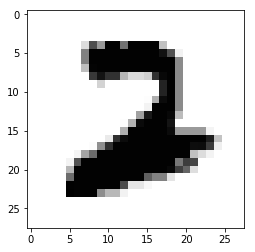

In [2]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

If you run the cell above again, you'll see a different image from the MNIST training set.

## Discriminator network

Our discriminator is a convolutional neural network that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake"—that is, whether it's drawn from the set of MNIST images or generated by the generator.

![caption](notebook-images/GAN_Discriminator.png)

The structure of our discriminator network is based closely on [TensorFlow's sample CNN classifier model](https://www.tensorflow.org/get_started/mnist/pros). It features two convolutional layers that find 5x5-pixel features, and two "fully connected" layers that multiply weights by every pixel in the image.

To set up each layer, we start by creating weight and bias variables through [`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable). Weights are initialized from a [truncated normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) distribution, and biases are initialized at zero.

[`tf.nn.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) is TensorFlow's standard convolution function. It takes 4 arguments. The first is the input volume (our `28 x 28 x 1` images in this case). The next argument is the filter/weight matrix. Finally, you can also change the stride and padding of the convolution. Those two values affect the dimensions of the output volume.

If you're already comfortable with CNNs, you'll recognize this as a simple binary classifier—nothing fancy. 

In [3]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

## Generator network

![caption](notebook-images/GAN_Generator.png)

Now that we have our discriminator defined, let’s take a look at the generator model. We'll base the overall structure of our model on a simple generator published by [Tim O'Shea](https://github.com/osh/KerasGAN).

You can think of the generator as a kind of reverse convolutional neural network. A typical CNN like our discriminator network transforms a 2- or 3-dimensional matrix of pixel values into a single probability. A generator, however, takes a `d`-dimensional vector of noise and upsamples it to become a 28 x 28 image. ReLU and batch normalization are used to stabilize the outputs of each layer.

In our generator network, we use three convolutional layers along with interpolation until a `28 x 28` pixel image is formed. (Actually, as you'll see below, we've taken care to form `28 x 28 x 1` images; many TensorFlow tools for dealing with images anticipate that the images will have some number of _channels_—usually 1 for greyscale images or 3 for RGB color images.)

At the output layer we add a [`tf.sigmoid()`](https://www.tensorflow.org/api_docs/python/tf/sigmoid) activation function; this squeezes pixels that would appear grey toward either black or white, resulting in a crisper image.

In [4]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

## Generating a sample image

Now we’ve defined both the generator and discriminator functions. Let’s see what a sample output from an untrained generator looks like.

We need to open a TensorFlow session and create a placeholder for the input to our generator. The shape of the placeholder will be `None, z_dimensions`. The `None` keyword means that the value can be determined at session runtime. We normally have `None` as our first dimension so that we can have variable batch sizes. (With a batch size of 50, the input to the generator would be 50 x 100). With the `None` keywoard, we don't have to specify `batch_size` until later. 

In [5]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

Now, we create a variable (`generated_image_output`) that holds the output of the generator, and we'll also initialize the random noise vector that we're going to use as input. The [`np.random.normal()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) function has three arguments. The first and second define the mean and standard deviation for the normal distribution (0 and 1 in our case), and the third defines the the shape of the vector (`1 x 100`).

In [6]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

Next, we initialize all the variables, feed our `z_batch` into the placeholder, and run the session.

The [`sess.run()`](https://www.tensorflow.org/api_docs/python/tf/Session#run) function has two arguments. The first is called the "fetches" argument; it defines the value you're interested in computing. In our case, we want to see what the output of the generator is. If you look back at the last code snippet, you'll see that the output of the generator function is stored in `generated_image_output`, so we'll use `generated_image_output` for our first argument.

The second argument takes a dictionary of inputs that are substituted into the graph when it runs. This is where we feed in our placeholders. In our example, we need to feed our `z_batch` variable into the `z_placeholder` that we defined earlier. As before, we'll view the image by reshaping it to `28 x 28` pixels and show it with PyPlot.

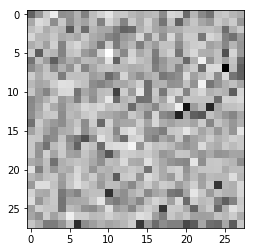

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

That looks like noise, right? Now we need to train the weights and biases in the generator network to convert random numbers into recognizable digits. Let's look at loss functions and optimization!

## Training a GAN

One of the trickiest parts about building and tuning GANs is that they have two loss functions: one that encourages the generator to create better images, and the other that encourages the discriminator to distinguish generated images from real images.

We train both the generator and the discriminator simultaneously. As the discriminator gets better at distinguishing real images from generated images, the generator is able to better tune its weights and biases to generate convincing images.

Here are the inputs and outputs for our networks.

In [8]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

So, let’s first think about what we want out of our networks. The discriminator's goal is to correctly label real MNIST images as real (return a higher output) and generated images as fake (return a lower output). We'll calculate two losses for the discriminator: one loss that compares `Dx` and 1 for real images from the MNIST set, as well as a loss that compares `Dg` and 0 for images from the generator. We'll do this with TensorFlow's [`tf.nn.sigmoid_cross_entropy_with_logits()`](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) function, which calculates the cross-entropy losses between `Dx` and 1 and between `Dg` and 0.

`sigmoid_cross_entropy_with_logits` operates on unscaled values rather than probability values from 0 to 1. Take a look at the last line of our discriminator: there's no softmax or sigmoid layer at the end. GANs can fail if their discriminators "saturate," or become confident enough to return exactly 0 when they're given a generated image; that leaves the discriminator without a useful gradient to descend.

The [`tf.reduce_mean()`](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) function takes the mean value of all of the components in the matrix returned by the cross entropy function. This is a way of reducing the loss to a single scalar value, instead of a vector or matrix.

In [9]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

Now let's set up the generator's loss function. We want the generator network to create images that will fool the discriminator: the generator wants the discriminator to output a value close to 1 when it's given an image from the generator. Therefore, we want to compute the loss between `Dg` and 1.

In [10]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

Now that we have our loss functions, we need to define our optimizers. The optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. Likewise, when we train the discriminator, we want to hold the generator's weights fixed.

In order to make this distinction, we need to create two lists of variables, one with the discriminator’s weights and biases and another with the generator’s weights and biases. This is where naming all of your TensorFlow variables with a thoughtful scheme can come in handy.

In [11]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

[u'd_w1:0', u'd_b1:0', u'd_w2:0', u'd_b2:0', u'd_w3:0', u'd_b3:0', u'd_w4:0', u'd_b4:0']
[u'g_w1:0', u'g_b1:0', u'g_b1/beta:0', u'g_w2:0', u'g_b2:0', u'g_b2/beta:0', u'g_w3:0', u'g_b3:0', u'g_b3/beta:0', u'g_w4:0', u'g_b4:0']


Next, we specify our two optimizers. [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) is usually the optimization algorithm of choice for GANs; it utilizes adaptive learning rates and momentum. We call Adam's minimize function and also specify the variables that we want it to update—the generator's weights and biases when we train the generator, and the discriminator's weights and biases when we train the discriminator.

We're setting up two different training operations for the discriminator here: one that trains the discriminator on real images and one that trains the discrmnator on fake images. It's sometimes useful to use different learning rates for these two training operations, or to use them separately to [regulate learning in other ways](https://github.com/jonbruner/ezgan).

In [12]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

It can be tricky to get GANs to converge, and moreover they often need to train for a very long time. [TensorBoard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) is useful for tracking the training process; it can graph scalar properties like losses, display sample images during training, and illustrate the topology of the neural networks.

If you run this script on your own machine, include the cell below. Then, in a terminal window from the directory that this notebook lives in, run

```
tensorboard --logdir=tensorboard/
```

and open TensorBoard by visiting [`http://localhost:6006`](http://localhost:6006) in your web browser.

In [13]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

And now we iterate. We begin by briefly giving the discriminator some initial training; this helps it develop a gradient that's useful to the generator.

Then we move on to the main training loop. When we train the generator, we’ll feed a random `z` vector into the generator and pass its output to the discriminator (this is the `Dg` variable we specified earlier). The generator’s weights and biases will be updated in order to produce images that the discriminator is more likely to classify as real.

To train the discriminator, we’ll feed it a batch of images from the MNIST set to serve as the positive examples, and then train the discriminator again on generated images, using them as negative examples. Remember that as the generator improves its output, the discriminator continues to learn to classify the improved generator images as fake.

Because it takes a long time to train a GAN, **we recommend not running this code block if you're going through this tutorial for the first time**. Instead, follow along but then run the following code block, which loads a pre-trained model for us to continue the tutorial.

**If you want to run this code yourself, prepare to wait: it takes about three hours on a fast GPU, but could take ten times that long on a desktop CPU.**

('dLossReal:', 0.69323027, 'dLossFake:', 0.71143866)


('dLossReal:', 0.0081365034, 'dLossFake:', 0.019889046)


('dLossReal:', 0.0013866425, 'dLossFake:', 0.0028247677)


('Iteration:', 0, 'at', datetime.datetime(2018, 3, 12, 12, 42, 53, 33096))


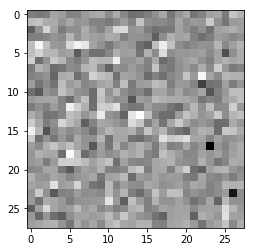

('Estimate:', array([[-6.13183641]], dtype=float32))


('Iteration:', 100, 'at', datetime.datetime(2018, 3, 12, 12, 42, 55, 668850))


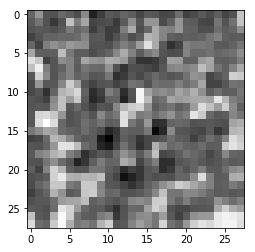

('Estimate:', array([[-6.65235472]], dtype=float32))


('Iteration:', 200, 'at', datetime.datetime(2018, 3, 12, 12, 42, 58, 289344))


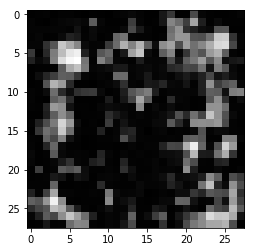

('Estimate:', array([[-8.03553677]], dtype=float32))


('Iteration:', 300, 'at', datetime.datetime(2018, 3, 12, 12, 43, 0, 960257))


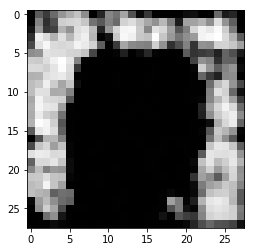

('Estimate:', array([[-4.95006561]], dtype=float32))


('Iteration:', 400, 'at', datetime.datetime(2018, 3, 12, 12, 43, 3, 580150))


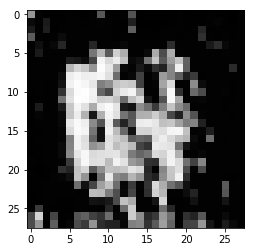

('Estimate:', array([[-3.22176933]], dtype=float32))


('Iteration:', 500, 'at', datetime.datetime(2018, 3, 12, 12, 43, 6, 275507))


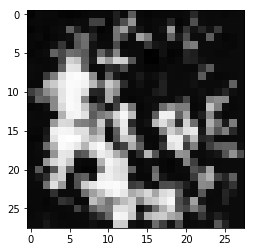

('Estimate:', array([[-7.15779066]], dtype=float32))


('Iteration:', 600, 'at', datetime.datetime(2018, 3, 12, 12, 43, 8, 962263))


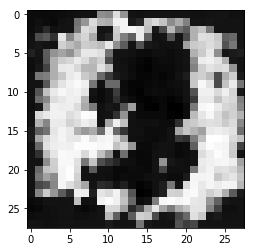

('Estimate:', array([[-9.24379921]], dtype=float32))


('Iteration:', 700, 'at', datetime.datetime(2018, 3, 12, 12, 43, 11, 641894))


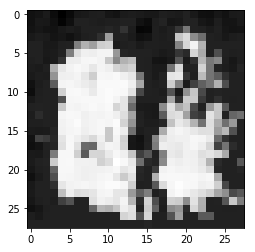

('Estimate:', array([[-7.75920916]], dtype=float32))


('Iteration:', 800, 'at', datetime.datetime(2018, 3, 12, 12, 43, 14, 381326))


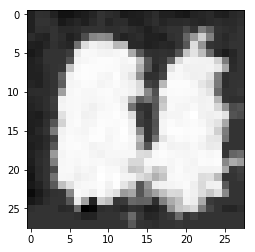

('Estimate:', array([[-7.21160746]], dtype=float32))


('Iteration:', 900, 'at', datetime.datetime(2018, 3, 12, 12, 43, 17, 4221))


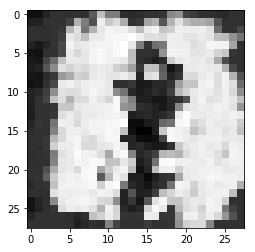

('Estimate:', array([[-6.59043503]], dtype=float32))


('Iteration:', 1000, 'at', datetime.datetime(2018, 3, 12, 12, 43, 19, 811261))


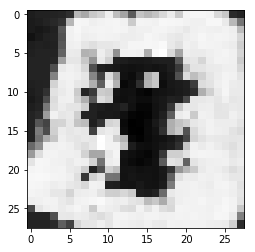

('Estimate:', array([[-10.69809628]], dtype=float32))


('Iteration:', 1100, 'at', datetime.datetime(2018, 3, 12, 12, 43, 22, 536890))


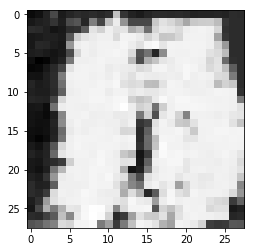

('Estimate:', array([[-8.5639658]], dtype=float32))


('Iteration:', 1200, 'at', datetime.datetime(2018, 3, 12, 12, 43, 25, 214680))


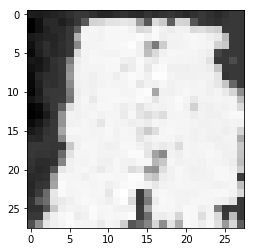

('Estimate:', array([[-8.22859573]], dtype=float32))


('Iteration:', 1300, 'at', datetime.datetime(2018, 3, 12, 12, 43, 27, 953918))


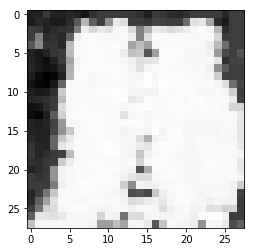

('Estimate:', array([[-8.68778419]], dtype=float32))


('Iteration:', 1400, 'at', datetime.datetime(2018, 3, 12, 12, 43, 30, 635573))


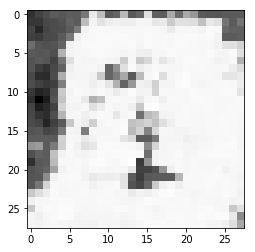

('Estimate:', array([[-8.7883215]], dtype=float32))


('Iteration:', 1500, 'at', datetime.datetime(2018, 3, 12, 12, 43, 33, 303553))


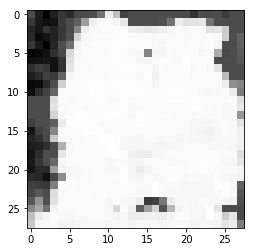

('Estimate:', array([[-6.94902039]], dtype=float32))


('Iteration:', 1600, 'at', datetime.datetime(2018, 3, 12, 12, 43, 36, 53749))


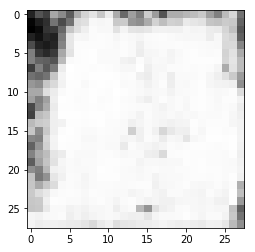

('Estimate:', array([[-6.80697584]], dtype=float32))


('Iteration:', 1700, 'at', datetime.datetime(2018, 3, 12, 12, 43, 38, 708965))


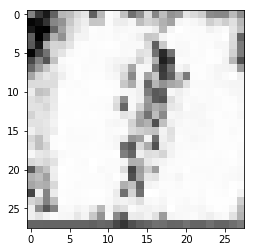

('Estimate:', array([[-8.21417904]], dtype=float32))


('Iteration:', 1800, 'at', datetime.datetime(2018, 3, 12, 12, 43, 41, 354194))


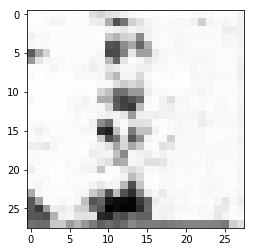

('Estimate:', array([[-7.56785488]], dtype=float32))


('Iteration:', 1900, 'at', datetime.datetime(2018, 3, 12, 12, 43, 44, 145296))


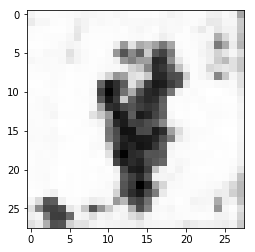

('Estimate:', array([[-6.53339577]], dtype=float32))


('Iteration:', 2000, 'at', datetime.datetime(2018, 3, 12, 12, 43, 46, 796711))


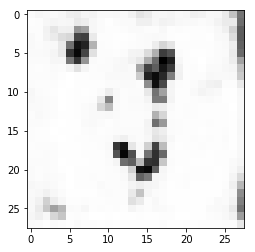

('Estimate:', array([[-3.36968088]], dtype=float32))


('Iteration:', 2100, 'at', datetime.datetime(2018, 3, 12, 12, 43, 49, 560660))


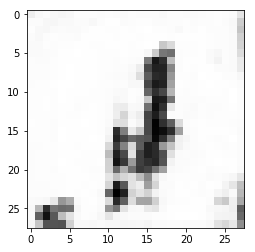

('Estimate:', array([[-5.45191479]], dtype=float32))


('Iteration:', 2200, 'at', datetime.datetime(2018, 3, 12, 12, 43, 52, 242606))


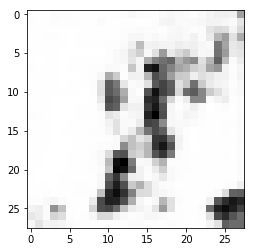

('Estimate:', array([[-7.21129847]], dtype=float32))


('Iteration:', 2300, 'at', datetime.datetime(2018, 3, 12, 12, 43, 54, 928506))


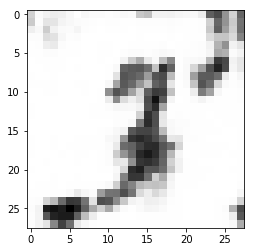

('Estimate:', array([[-4.66847467]], dtype=float32))


('Iteration:', 2400, 'at', datetime.datetime(2018, 3, 12, 12, 43, 57, 607532))


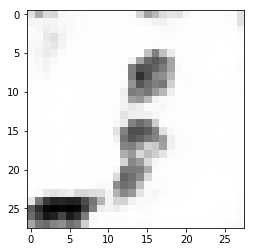

('Estimate:', array([[-6.99062967]], dtype=float32))


('Iteration:', 2500, 'at', datetime.datetime(2018, 3, 12, 12, 44, 0, 858246))


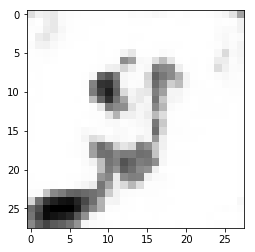

('Estimate:', array([[-11.18849468]], dtype=float32))


('Iteration:', 2600, 'at', datetime.datetime(2018, 3, 12, 12, 44, 3, 832783))


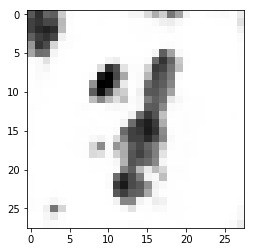

('Estimate:', array([[-6.20993948]], dtype=float32))


('Iteration:', 2700, 'at', datetime.datetime(2018, 3, 12, 12, 44, 6, 949930))


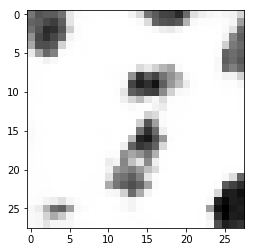

('Estimate:', array([[ 12.47811317]], dtype=float32))


('Iteration:', 2800, 'at', datetime.datetime(2018, 3, 12, 12, 44, 9, 884898))


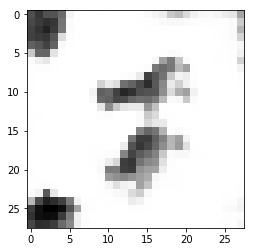

('Estimate:', array([[-4.89876175]], dtype=float32))


('Iteration:', 2900, 'at', datetime.datetime(2018, 3, 12, 12, 44, 12, 738412))


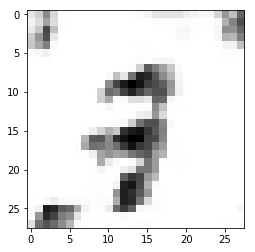

('Estimate:', array([[-12.14506912]], dtype=float32))


('Iteration:', 3000, 'at', datetime.datetime(2018, 3, 12, 12, 44, 15, 679794))


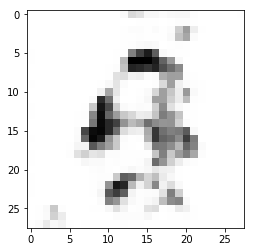

('Estimate:', array([[-5.63101435]], dtype=float32))


('Iteration:', 3100, 'at', datetime.datetime(2018, 3, 12, 12, 44, 18, 560641))


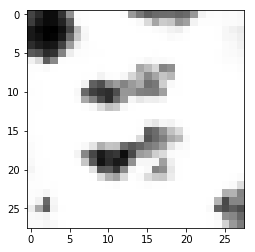

('Estimate:', array([[-5.11451244]], dtype=float32))


('Iteration:', 3200, 'at', datetime.datetime(2018, 3, 12, 12, 44, 21, 395713))


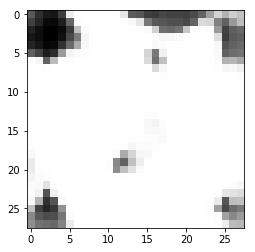

('Estimate:', array([[ 16.17891312]], dtype=float32))


('Iteration:', 3300, 'at', datetime.datetime(2018, 3, 12, 12, 44, 24, 264164))


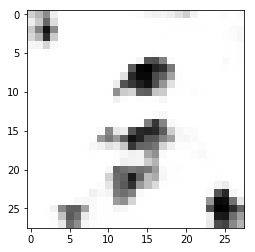

('Estimate:', array([[ 9.64735222]], dtype=float32))


('Iteration:', 3400, 'at', datetime.datetime(2018, 3, 12, 12, 44, 26, 989034))


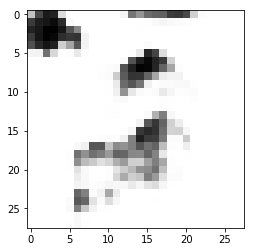

('Estimate:', array([[ 10.58153152]], dtype=float32))


('Iteration:', 3500, 'at', datetime.datetime(2018, 3, 12, 12, 44, 29, 671918))


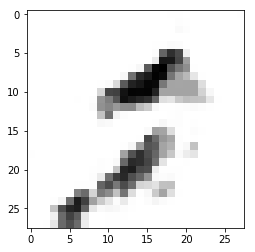

('Estimate:', array([[-11.57753563]], dtype=float32))


('Iteration:', 3600, 'at', datetime.datetime(2018, 3, 12, 12, 44, 32, 434273))


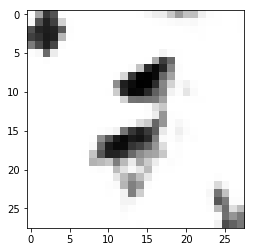

('Estimate:', array([[-6.88496542]], dtype=float32))


('Iteration:', 3700, 'at', datetime.datetime(2018, 3, 12, 12, 44, 35, 157151))


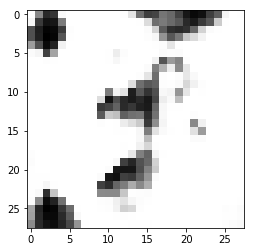

('Estimate:', array([[-11.00890064]], dtype=float32))


('Iteration:', 3800, 'at', datetime.datetime(2018, 3, 12, 12, 44, 37, 845949))


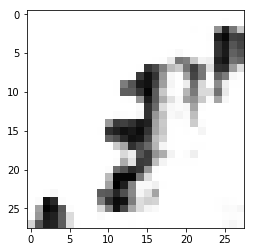

('Estimate:', array([[-4.47207499]], dtype=float32))


('Iteration:', 3900, 'at', datetime.datetime(2018, 3, 12, 12, 44, 40, 605420))


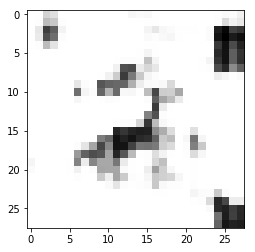

('Estimate:', array([[-3.62373137]], dtype=float32))


('Iteration:', 4000, 'at', datetime.datetime(2018, 3, 12, 12, 44, 43, 582239))


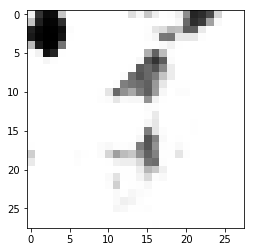

('Estimate:', array([[ 9.7520752]], dtype=float32))


('Iteration:', 4100, 'at', datetime.datetime(2018, 3, 12, 12, 44, 46, 460872))


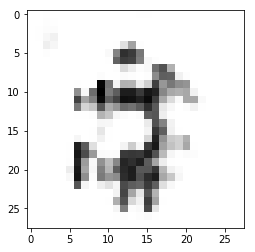

('Estimate:', array([[ 4.52465248]], dtype=float32))


('Iteration:', 4200, 'at', datetime.datetime(2018, 3, 12, 12, 44, 49, 198886))


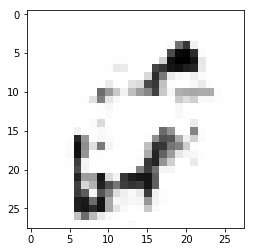

('Estimate:', array([[ 6.42159557]], dtype=float32))


('Iteration:', 4300, 'at', datetime.datetime(2018, 3, 12, 12, 44, 52, 2131))


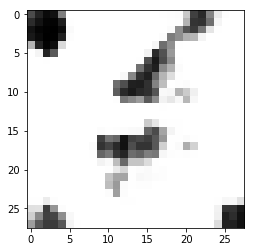

('Estimate:', array([[ 1.33304238]], dtype=float32))


('Iteration:', 4400, 'at', datetime.datetime(2018, 3, 12, 12, 44, 54, 693765))


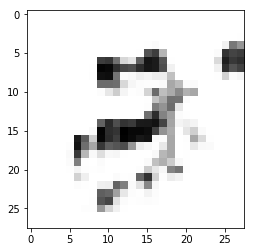

('Estimate:', array([[-5.94874001]], dtype=float32))


('Iteration:', 4500, 'at', datetime.datetime(2018, 3, 12, 12, 44, 57, 419930))


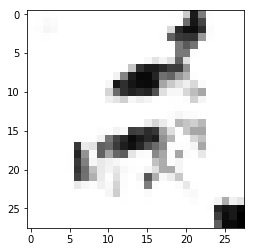

('Estimate:', array([[-4.33223486]], dtype=float32))


('Iteration:', 4600, 'at', datetime.datetime(2018, 3, 12, 12, 45, 0, 111744))


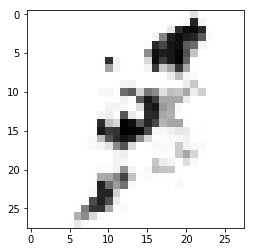

('Estimate:', array([[-6.88318634]], dtype=float32))


('Iteration:', 4700, 'at', datetime.datetime(2018, 3, 12, 12, 45, 3, 134595))


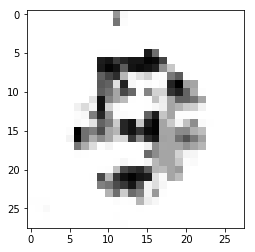

('Estimate:', array([[ 2.67833924]], dtype=float32))


('Iteration:', 4800, 'at', datetime.datetime(2018, 3, 12, 12, 45, 5, 900338))


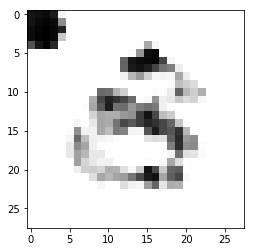

('Estimate:', array([[-2.45980835]], dtype=float32))


('Iteration:', 4900, 'at', datetime.datetime(2018, 3, 12, 12, 45, 8, 631409))


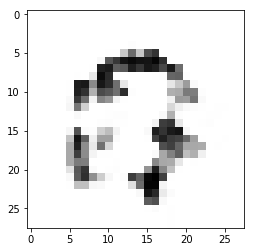

('Estimate:', array([[ 3.84282827]], dtype=float32))


('Iteration:', 5000, 'at', datetime.datetime(2018, 3, 12, 12, 45, 11, 381454))


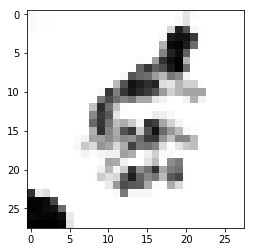

('Estimate:', array([[-5.0491662]], dtype=float32))


('Iteration:', 5100, 'at', datetime.datetime(2018, 3, 12, 12, 45, 14, 138322))


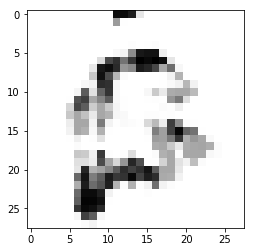

('Estimate:', array([[ 1.58465302]], dtype=float32))


('Iteration:', 5200, 'at', datetime.datetime(2018, 3, 12, 12, 45, 16, 939579))


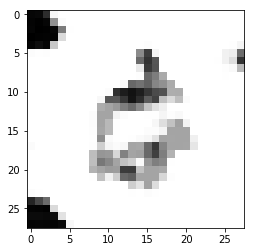

('Estimate:', array([[-9.15307331]], dtype=float32))


('Iteration:', 5300, 'at', datetime.datetime(2018, 3, 12, 12, 45, 19, 698196))


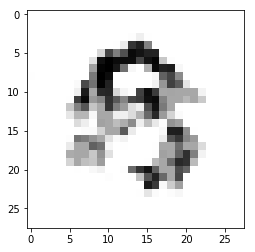

('Estimate:', array([[ 1.37657654]], dtype=float32))


('Iteration:', 5400, 'at', datetime.datetime(2018, 3, 12, 12, 45, 22, 465929))


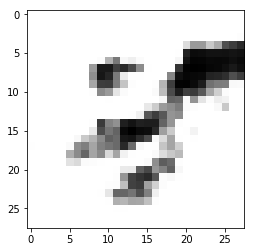

('Estimate:', array([[-0.44915196]], dtype=float32))


('Iteration:', 5500, 'at', datetime.datetime(2018, 3, 12, 12, 45, 25, 175635))


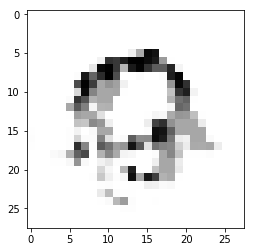

('Estimate:', array([[ 4.36930704]], dtype=float32))


('Iteration:', 5600, 'at', datetime.datetime(2018, 3, 12, 12, 45, 27, 908419))


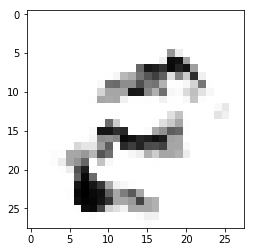

('Estimate:', array([[ 5.86212397]], dtype=float32))


('Iteration:', 5700, 'at', datetime.datetime(2018, 3, 12, 12, 45, 30, 623638))


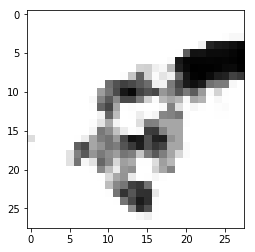

('Estimate:', array([[ 3.07985044]], dtype=float32))


('Iteration:', 5800, 'at', datetime.datetime(2018, 3, 12, 12, 45, 33, 352453))


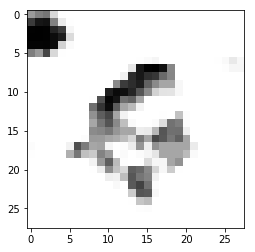

('Estimate:', array([[-16.02475548]], dtype=float32))


('Iteration:', 5900, 'at', datetime.datetime(2018, 3, 12, 12, 45, 36, 68469))


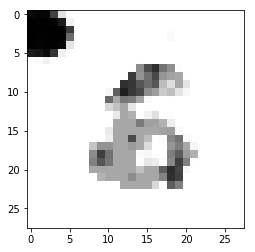

('Estimate:', array([[ 26.04971313]], dtype=float32))


('Iteration:', 6000, 'at', datetime.datetime(2018, 3, 12, 12, 45, 38, 826048))


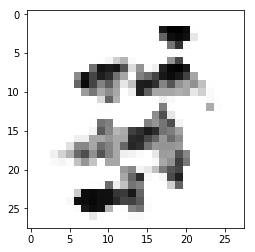

('Estimate:', array([[-6.12049675]], dtype=float32))


('Iteration:', 6100, 'at', datetime.datetime(2018, 3, 12, 12, 45, 41, 562495))


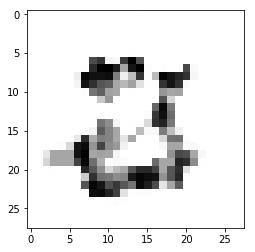

('Estimate:', array([[ 5.64404774]], dtype=float32))


('Iteration:', 6200, 'at', datetime.datetime(2018, 3, 12, 12, 45, 44, 299082))


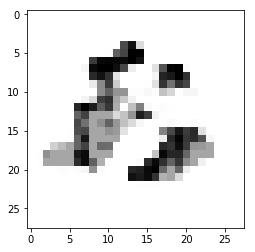

('Estimate:', array([[ 7.40376997]], dtype=float32))


('Iteration:', 6300, 'at', datetime.datetime(2018, 3, 12, 12, 45, 47, 241394))


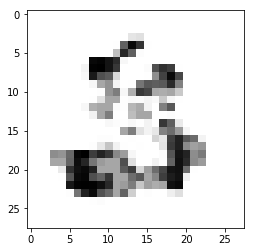

('Estimate:', array([[ 7.31627655]], dtype=float32))


('Iteration:', 6400, 'at', datetime.datetime(2018, 3, 12, 12, 45, 50, 32415))


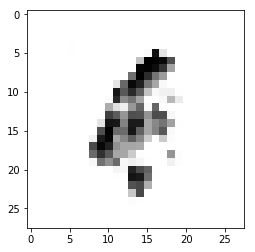

('Estimate:', array([[-0.80279893]], dtype=float32))


('Iteration:', 6500, 'at', datetime.datetime(2018, 3, 12, 12, 45, 52, 812632))


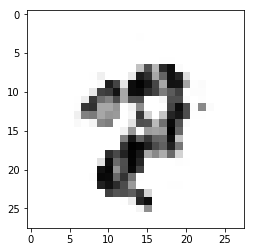

('Estimate:', array([[-2.51623535]], dtype=float32))


('Iteration:', 6600, 'at', datetime.datetime(2018, 3, 12, 12, 45, 55, 605003))


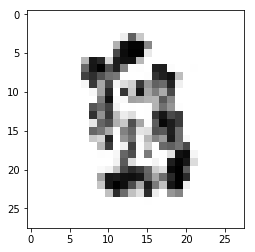

('Estimate:', array([[-0.72234279]], dtype=float32))


('Iteration:', 6700, 'at', datetime.datetime(2018, 3, 12, 12, 45, 58, 414337))


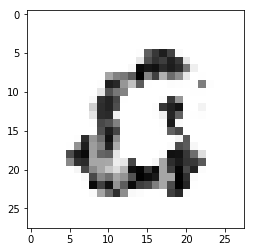

('Estimate:', array([[ 10.85630417]], dtype=float32))


('Iteration:', 6800, 'at', datetime.datetime(2018, 3, 12, 12, 46, 1, 202473))


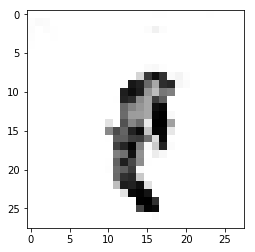

('Estimate:', array([[ 2.82935953]], dtype=float32))


('Iteration:', 6900, 'at', datetime.datetime(2018, 3, 12, 12, 46, 3, 971096))


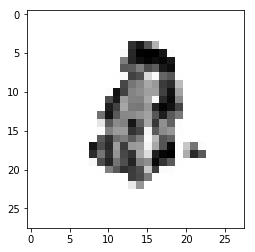

('Estimate:', array([[ 1.97910881]], dtype=float32))


('Iteration:', 7000, 'at', datetime.datetime(2018, 3, 12, 12, 46, 6, 740026))


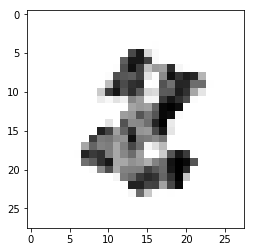

('Estimate:', array([[ 13.86366653]], dtype=float32))


('Iteration:', 7100, 'at', datetime.datetime(2018, 3, 12, 12, 46, 9, 506257))


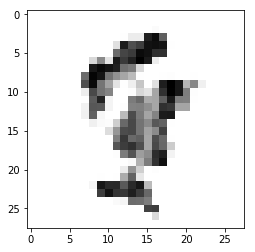

('Estimate:', array([[-4.12821579]], dtype=float32))


('Iteration:', 7200, 'at', datetime.datetime(2018, 3, 12, 12, 46, 12, 271706))


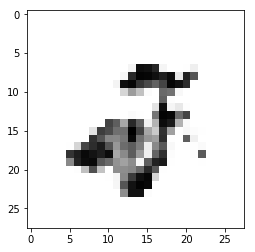

('Estimate:', array([[ 14.56184864]], dtype=float32))


('Iteration:', 7300, 'at', datetime.datetime(2018, 3, 12, 12, 46, 15, 182763))


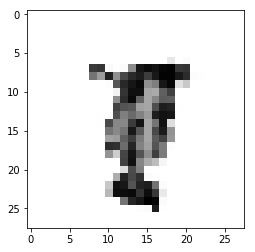

('Estimate:', array([[-3.33616567]], dtype=float32))


('Iteration:', 7400, 'at', datetime.datetime(2018, 3, 12, 12, 46, 18, 233784))


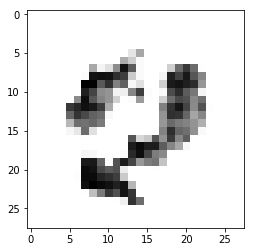

('Estimate:', array([[-2.77886319]], dtype=float32))


('Iteration:', 7500, 'at', datetime.datetime(2018, 3, 12, 12, 46, 21, 239))


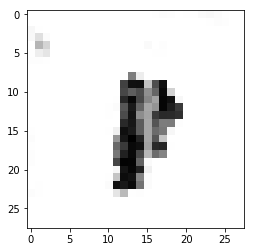

('Estimate:', array([[-7.93655109]], dtype=float32))


('Iteration:', 7600, 'at', datetime.datetime(2018, 3, 12, 12, 46, 23, 778153))


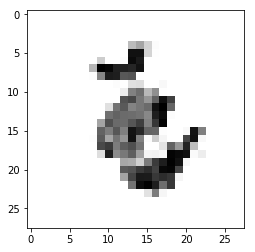

('Estimate:', array([[-1.50685191]], dtype=float32))


('Iteration:', 7700, 'at', datetime.datetime(2018, 3, 12, 12, 46, 26, 644671))


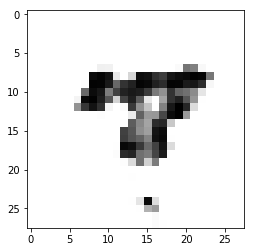

('Estimate:', array([[ 14.86401749]], dtype=float32))


('Iteration:', 7800, 'at', datetime.datetime(2018, 3, 12, 12, 46, 29, 439603))


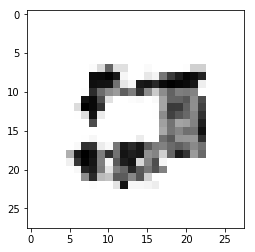

('Estimate:', array([[-2.14516115]], dtype=float32))


('Iteration:', 7900, 'at', datetime.datetime(2018, 3, 12, 12, 46, 32, 243193))


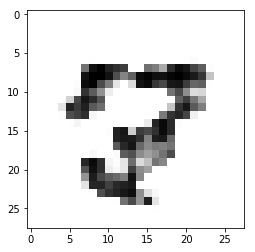

('Estimate:', array([[ 1.70933247]], dtype=float32))


('Iteration:', 8000, 'at', datetime.datetime(2018, 3, 12, 12, 46, 35, 89821))


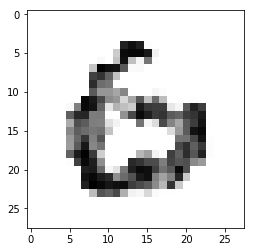

('Estimate:', array([[ 2.82685947]], dtype=float32))


('Iteration:', 8100, 'at', datetime.datetime(2018, 3, 12, 12, 46, 38, 111053))


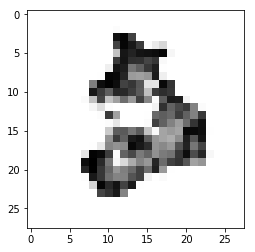

('Estimate:', array([[-4.74713039]], dtype=float32))


('Iteration:', 8200, 'at', datetime.datetime(2018, 3, 12, 12, 46, 40, 982503))


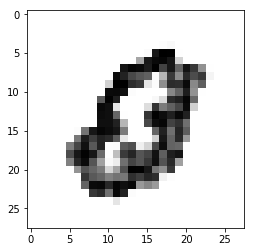

('Estimate:', array([[ 4.90161037]], dtype=float32))


('Iteration:', 8300, 'at', datetime.datetime(2018, 3, 12, 12, 46, 43, 765846))


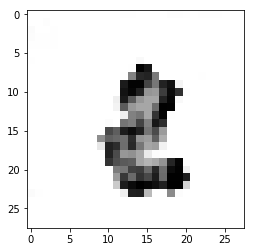

('Estimate:', array([[ 5.64834976]], dtype=float32))


('Iteration:', 8400, 'at', datetime.datetime(2018, 3, 12, 12, 46, 46, 576140))


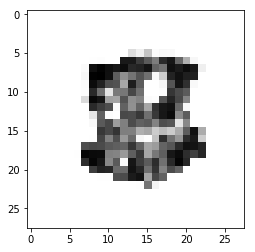

('Estimate:', array([[ 2.89661646]], dtype=float32))


('Iteration:', 8500, 'at', datetime.datetime(2018, 3, 12, 12, 46, 49, 427869))


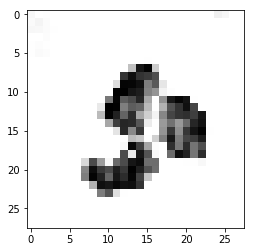

('Estimate:', array([[ 23.29201126]], dtype=float32))


('Iteration:', 8600, 'at', datetime.datetime(2018, 3, 12, 12, 46, 52, 279526))


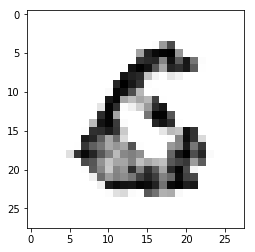

('Estimate:', array([[ 3.08854961]], dtype=float32))


('Iteration:', 8700, 'at', datetime.datetime(2018, 3, 12, 12, 46, 55, 108596))


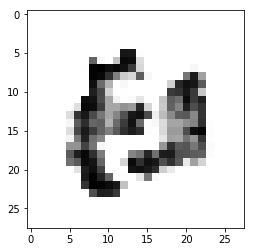

('Estimate:', array([[-13.45801926]], dtype=float32))


('Iteration:', 8800, 'at', datetime.datetime(2018, 3, 12, 12, 46, 57, 950868))


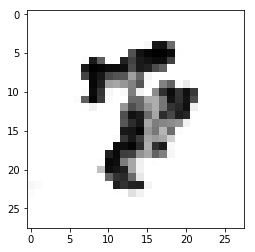

('Estimate:', array([[-0.74636871]], dtype=float32))


('Iteration:', 8900, 'at', datetime.datetime(2018, 3, 12, 12, 47, 0, 808041))


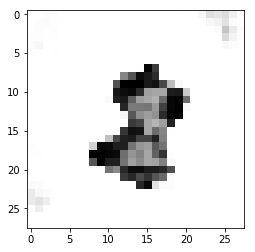

('Estimate:', array([[-2.25985146]], dtype=float32))


('Iteration:', 9000, 'at', datetime.datetime(2018, 3, 12, 12, 47, 3, 633666))


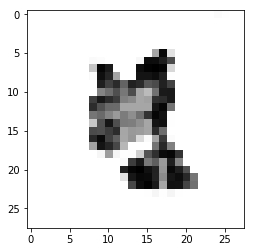

('Estimate:', array([[-7.48760176]], dtype=float32))


('Iteration:', 9100, 'at', datetime.datetime(2018, 3, 12, 12, 47, 6, 529953))


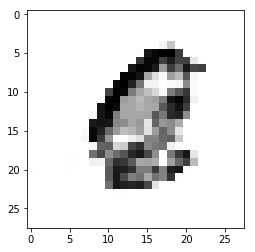

('Estimate:', array([[ 7.78888893]], dtype=float32))


('Iteration:', 9200, 'at', datetime.datetime(2018, 3, 12, 12, 47, 9, 332983))


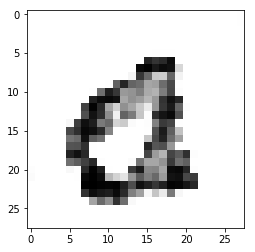

('Estimate:', array([[-1.07171571]], dtype=float32))


('Iteration:', 9300, 'at', datetime.datetime(2018, 3, 12, 12, 47, 12, 190841))


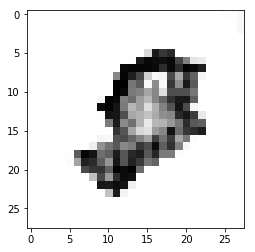

('Estimate:', array([[ 2.47104502]], dtype=float32))


('Iteration:', 9400, 'at', datetime.datetime(2018, 3, 12, 12, 47, 14, 965934))


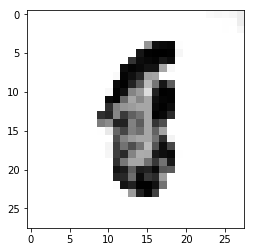

('Estimate:', array([[-1.63418174]], dtype=float32))


('Iteration:', 9500, 'at', datetime.datetime(2018, 3, 12, 12, 47, 17, 804574))


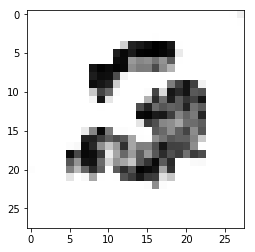

('Estimate:', array([[ 2.07074976]], dtype=float32))


('Iteration:', 9600, 'at', datetime.datetime(2018, 3, 12, 12, 47, 20, 631047))


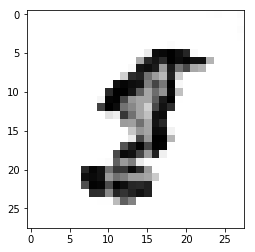

('Estimate:', array([[-5.65905714]], dtype=float32))


('Iteration:', 9700, 'at', datetime.datetime(2018, 3, 12, 12, 47, 23, 429831))


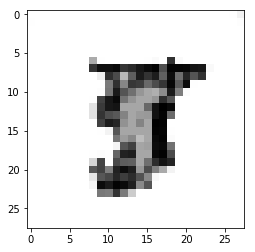

('Estimate:', array([[-1.28730118]], dtype=float32))


('Iteration:', 9800, 'at', datetime.datetime(2018, 3, 12, 12, 47, 26, 330708))


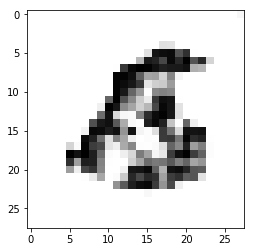

('Estimate:', array([[ 6.35245037]], dtype=float32))


('Iteration:', 9900, 'at', datetime.datetime(2018, 3, 12, 12, 47, 29, 106715))


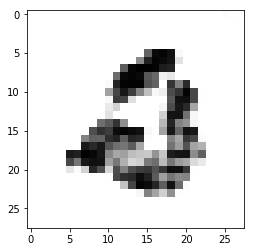

('Estimate:', array([[ 0.37114969]], dtype=float32))


('Iteration:', 10000, 'at', datetime.datetime(2018, 3, 12, 12, 47, 31, 920461))


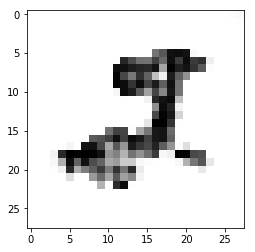

('Estimate:', array([[ 7.6948204]], dtype=float32))


('Iteration:', 10100, 'at', datetime.datetime(2018, 3, 12, 12, 47, 34, 708625))


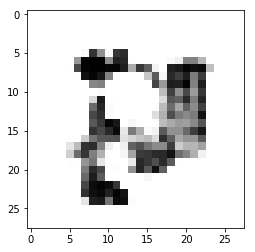

('Estimate:', array([[ 10.18925571]], dtype=float32))


('Iteration:', 10200, 'at', datetime.datetime(2018, 3, 12, 12, 47, 37, 721635))


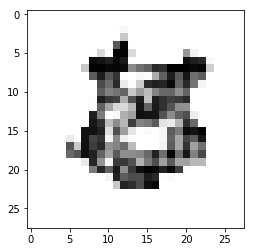

('Estimate:', array([[ 20.22212029]], dtype=float32))


('Iteration:', 10300, 'at', datetime.datetime(2018, 3, 12, 12, 47, 40, 619015))


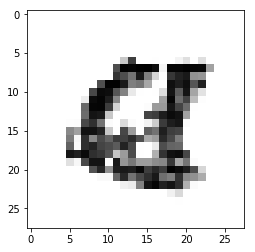

('Estimate:', array([[-2.50905704]], dtype=float32))


('Iteration:', 10400, 'at', datetime.datetime(2018, 3, 12, 12, 47, 43, 453350))


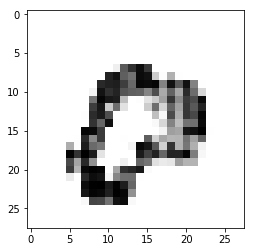

('Estimate:', array([[ 2.77728534]], dtype=float32))


('Iteration:', 10500, 'at', datetime.datetime(2018, 3, 12, 12, 47, 46, 298098))


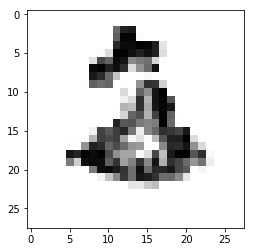

('Estimate:', array([[-0.0206725]], dtype=float32))


('Iteration:', 10600, 'at', datetime.datetime(2018, 3, 12, 12, 47, 49, 216845))


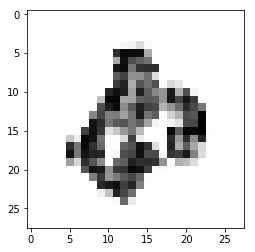

('Estimate:', array([[ 10.67281055]], dtype=float32))


('Iteration:', 10700, 'at', datetime.datetime(2018, 3, 12, 12, 47, 52, 104019))


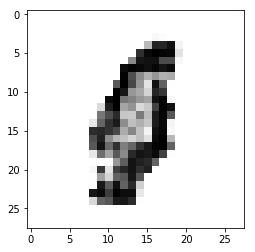

('Estimate:', array([[-2.24376345]], dtype=float32))


('Iteration:', 10800, 'at', datetime.datetime(2018, 3, 12, 12, 47, 55, 32517))


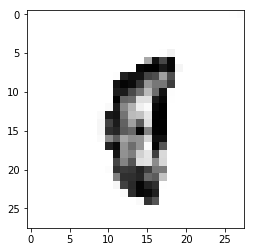

('Estimate:', array([[ 3.58451867]], dtype=float32))


('Iteration:', 10900, 'at', datetime.datetime(2018, 3, 12, 12, 47, 57, 837592))


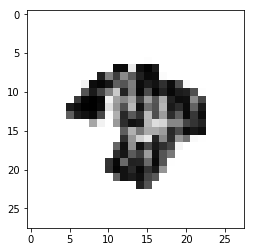

('Estimate:', array([[-0.97038829]], dtype=float32))


('Iteration:', 11000, 'at', datetime.datetime(2018, 3, 12, 12, 48, 0, 872760))


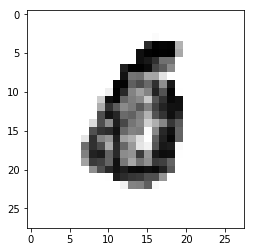

('Estimate:', array([[ 7.57534218]], dtype=float32))


('Iteration:', 11100, 'at', datetime.datetime(2018, 3, 12, 12, 48, 3, 820372))


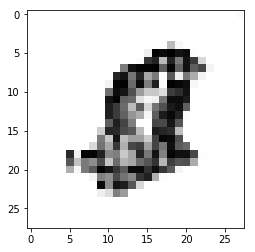

('Estimate:', array([[-12.04642296]], dtype=float32))


('Iteration:', 11200, 'at', datetime.datetime(2018, 3, 12, 12, 48, 6, 710464))


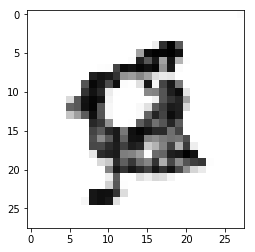

('Estimate:', array([[-4.69181633]], dtype=float32))


('Iteration:', 11300, 'at', datetime.datetime(2018, 3, 12, 12, 48, 9, 616875))


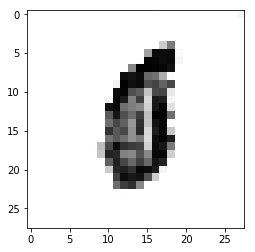

('Estimate:', array([[-10.07356358]], dtype=float32))


('Iteration:', 11400, 'at', datetime.datetime(2018, 3, 12, 12, 48, 12, 554931))


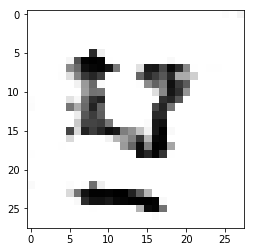

('Estimate:', array([[-6.12890005]], dtype=float32))


('Iteration:', 11500, 'at', datetime.datetime(2018, 3, 12, 12, 48, 15, 453685))


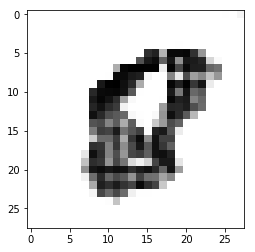

('Estimate:', array([[ 9.29602051]], dtype=float32))


('Iteration:', 11600, 'at', datetime.datetime(2018, 3, 12, 12, 48, 18, 331089))


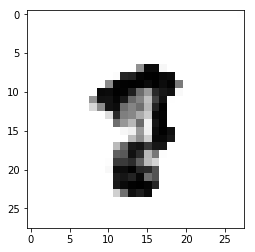

('Estimate:', array([[ 1.72229791]], dtype=float32))


('Iteration:', 11700, 'at', datetime.datetime(2018, 3, 12, 12, 48, 21, 183705))


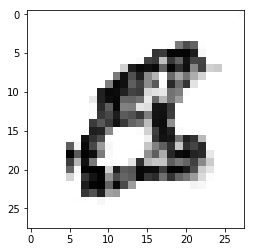

('Estimate:', array([[ 5.92459869]], dtype=float32))


('Iteration:', 11800, 'at', datetime.datetime(2018, 3, 12, 12, 48, 24, 49509))


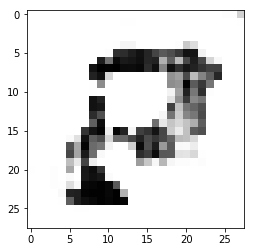

('Estimate:', array([[ 19.83153534]], dtype=float32))


('Iteration:', 11900, 'at', datetime.datetime(2018, 3, 12, 12, 48, 26, 916612))


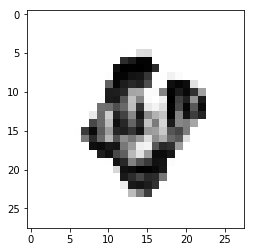

('Estimate:', array([[ 4.86121655]], dtype=float32))


('Iteration:', 12000, 'at', datetime.datetime(2018, 3, 12, 12, 48, 29, 744192))


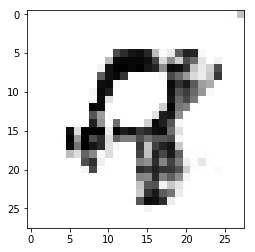

('Estimate:', array([[ 6.66037321]], dtype=float32))


('Iteration:', 12100, 'at', datetime.datetime(2018, 3, 12, 12, 48, 32, 641939))


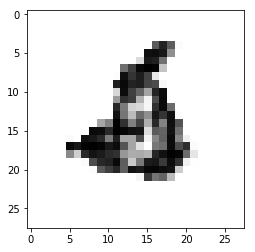

('Estimate:', array([[ 17.24790001]], dtype=float32))


('Iteration:', 12200, 'at', datetime.datetime(2018, 3, 12, 12, 48, 35, 577995))


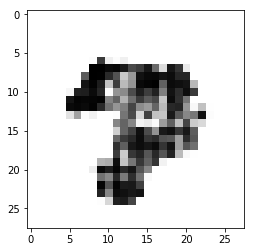

('Estimate:', array([[ 15.8915472]], dtype=float32))


('Iteration:', 12300, 'at', datetime.datetime(2018, 3, 12, 12, 48, 38, 533222))


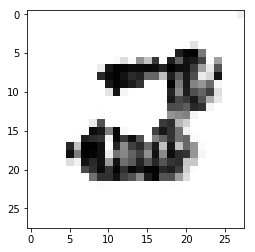

('Estimate:', array([[ 5.10880995]], dtype=float32))


('Iteration:', 12400, 'at', datetime.datetime(2018, 3, 12, 12, 48, 41, 459678))


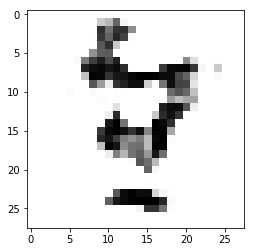

('Estimate:', array([[-12.49995899]], dtype=float32))


('Iteration:', 12500, 'at', datetime.datetime(2018, 3, 12, 12, 48, 44, 385708))


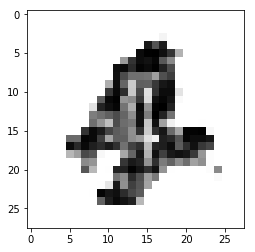

('Estimate:', array([[ 7.54118061]], dtype=float32))


('Iteration:', 12600, 'at', datetime.datetime(2018, 3, 12, 12, 48, 47, 646886))


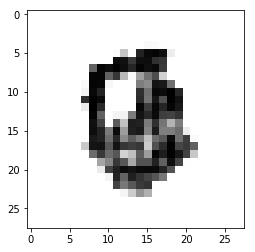

('Estimate:', array([[ 4.95578623]], dtype=float32))


('Iteration:', 12700, 'at', datetime.datetime(2018, 3, 12, 12, 48, 50, 963906))


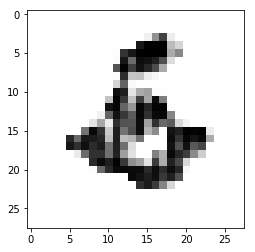

('Estimate:', array([[ 19.93539429]], dtype=float32))


('Iteration:', 12800, 'at', datetime.datetime(2018, 3, 12, 12, 48, 53, 816523))


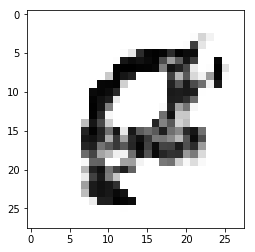

('Estimate:', array([[-6.43783283]], dtype=float32))


('Iteration:', 12900, 'at', datetime.datetime(2018, 3, 12, 12, 48, 56, 734390))


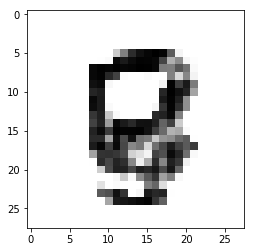

('Estimate:', array([[ 5.26830006]], dtype=float32))


('Iteration:', 13000, 'at', datetime.datetime(2018, 3, 12, 12, 48, 59, 704661))


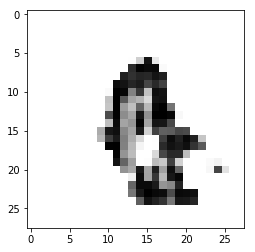

('Estimate:', array([[-1.8135308]], dtype=float32))


('Iteration:', 13100, 'at', datetime.datetime(2018, 3, 12, 12, 49, 2, 569764))


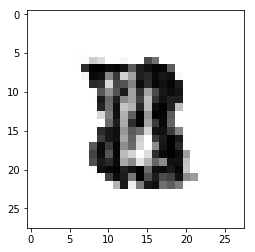

('Estimate:', array([[ 2.74314022]], dtype=float32))


('Iteration:', 13200, 'at', datetime.datetime(2018, 3, 12, 12, 49, 5, 590197))


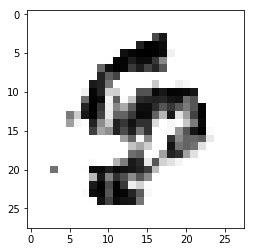

('Estimate:', array([[ 0.12123331]], dtype=float32))


('Iteration:', 13300, 'at', datetime.datetime(2018, 3, 12, 12, 49, 8, 546805))


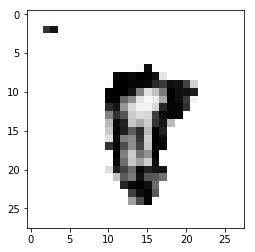

('Estimate:', array([[ 4.89831591]], dtype=float32))


('Iteration:', 13400, 'at', datetime.datetime(2018, 3, 12, 12, 49, 11, 486369))


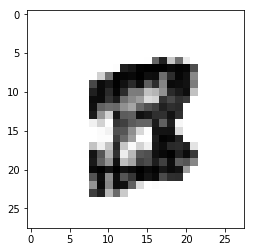

('Estimate:', array([[ 5.31032991]], dtype=float32))


('Iteration:', 13500, 'at', datetime.datetime(2018, 3, 12, 12, 49, 14, 421538))


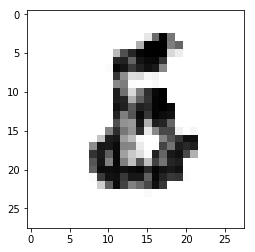

('Estimate:', array([[-1.51293445]], dtype=float32))


('Iteration:', 13600, 'at', datetime.datetime(2018, 3, 12, 12, 49, 17, 334693))


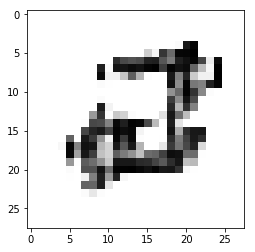

('Estimate:', array([[ 20.30436134]], dtype=float32))


('Iteration:', 13700, 'at', datetime.datetime(2018, 3, 12, 12, 49, 20, 241328))


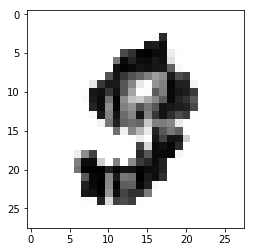

('Estimate:', array([[ 3.13973117]], dtype=float32))


('Iteration:', 13800, 'at', datetime.datetime(2018, 3, 12, 12, 49, 23, 198894))


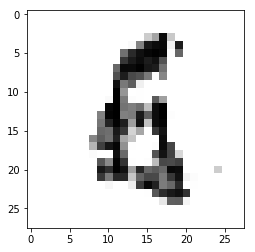

('Estimate:', array([[ 3.77996874]], dtype=float32))


('Iteration:', 13900, 'at', datetime.datetime(2018, 3, 12, 12, 49, 26, 183377))


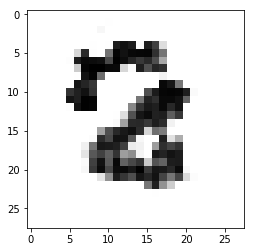

('Estimate:', array([[ 0.0320401]], dtype=float32))


('Iteration:', 14000, 'at', datetime.datetime(2018, 3, 12, 12, 49, 29, 70125))


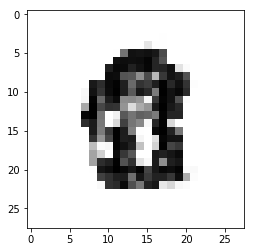

('Estimate:', array([[ 5.42905903]], dtype=float32))


('Iteration:', 14100, 'at', datetime.datetime(2018, 3, 12, 12, 49, 31, 973675))


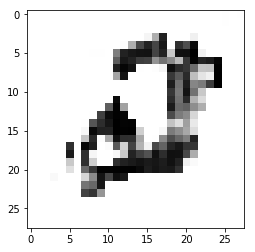

('Estimate:', array([[ 12.14407158]], dtype=float32))


('Iteration:', 14200, 'at', datetime.datetime(2018, 3, 12, 12, 49, 34, 938032))


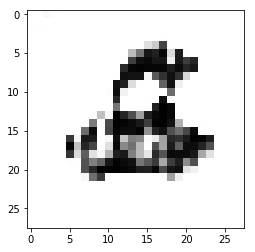

('Estimate:', array([[ 13.63753319]], dtype=float32))


('Iteration:', 14300, 'at', datetime.datetime(2018, 3, 12, 12, 49, 37, 916914))


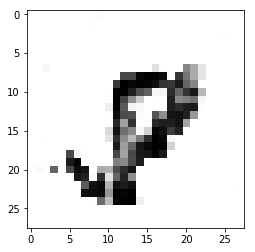

('Estimate:', array([[ 11.17161274]], dtype=float32))


('Iteration:', 14400, 'at', datetime.datetime(2018, 3, 12, 12, 49, 40, 804732))


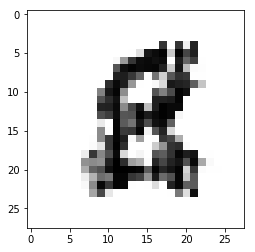

('Estimate:', array([[ 1.62347674]], dtype=float32))


('Iteration:', 14500, 'at', datetime.datetime(2018, 3, 12, 12, 49, 43, 729311))


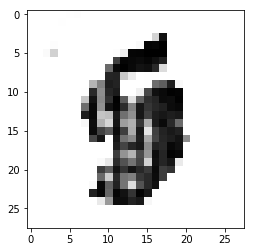

('Estimate:', array([[ 0.7081027]], dtype=float32))


('Iteration:', 14600, 'at', datetime.datetime(2018, 3, 12, 12, 49, 46, 687433))


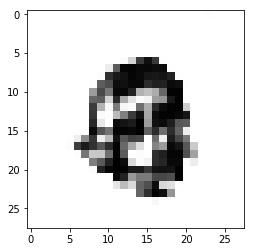

('Estimate:', array([[ 3.59258437]], dtype=float32))


('Iteration:', 14700, 'at', datetime.datetime(2018, 3, 12, 12, 49, 49, 605275))


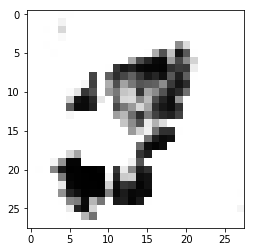

('Estimate:', array([[ 4.21320724]], dtype=float32))


('Iteration:', 14800, 'at', datetime.datetime(2018, 3, 12, 12, 49, 52, 575558))


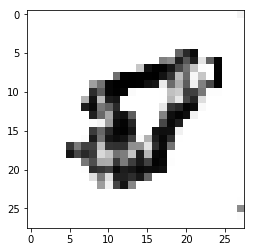

('Estimate:', array([[ 1.19058716]], dtype=float32))


('Iteration:', 14900, 'at', datetime.datetime(2018, 3, 12, 12, 49, 55, 457968))


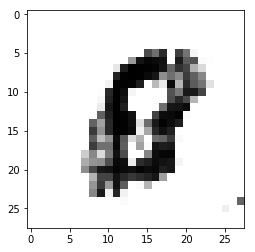

('Estimate:', array([[ 0.80718338]], dtype=float32))


('Iteration:', 15000, 'at', datetime.datetime(2018, 3, 12, 12, 49, 58, 359673))


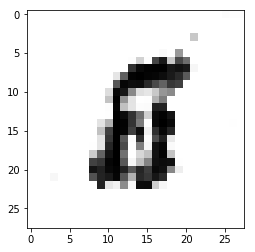

('Estimate:', array([[ 7.28833055]], dtype=float32))


('Iteration:', 15100, 'at', datetime.datetime(2018, 3, 12, 12, 50, 1, 339529))


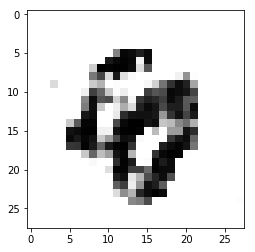

('Estimate:', array([[ 4.39253378]], dtype=float32))


('Iteration:', 15200, 'at', datetime.datetime(2018, 3, 12, 12, 50, 4, 332200))


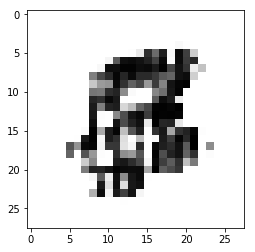

('Estimate:', array([[ 15.36179543]], dtype=float32))


('Iteration:', 15300, 'at', datetime.datetime(2018, 3, 12, 12, 50, 7, 560475))


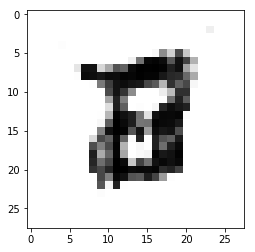

('Estimate:', array([[ 1.1601578]], dtype=float32))


('Iteration:', 15400, 'at', datetime.datetime(2018, 3, 12, 12, 50, 10, 472420))


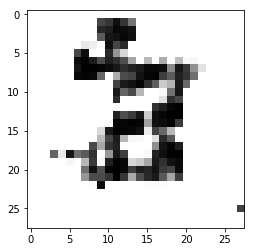

('Estimate:', array([[ 7.9736433]], dtype=float32))


('Iteration:', 15500, 'at', datetime.datetime(2018, 3, 12, 12, 50, 13, 487392))


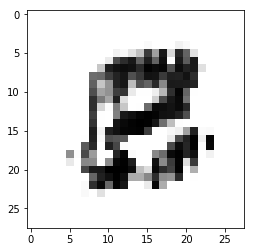

('Estimate:', array([[ 3.92186308]], dtype=float32))


('Iteration:', 15600, 'at', datetime.datetime(2018, 3, 12, 12, 50, 16, 456646))


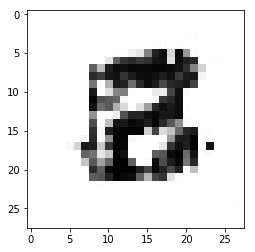

('Estimate:', array([[ 1.94920695]], dtype=float32))


('Iteration:', 15700, 'at', datetime.datetime(2018, 3, 12, 12, 50, 19, 422985))


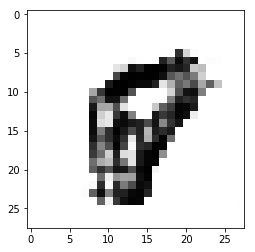

('Estimate:', array([[ 8.21573544]], dtype=float32))


('Iteration:', 15800, 'at', datetime.datetime(2018, 3, 12, 12, 50, 22, 401930))


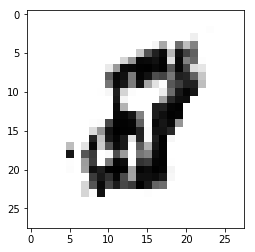

('Estimate:', array([[ 10.15423012]], dtype=float32))


('Iteration:', 15900, 'at', datetime.datetime(2018, 3, 12, 12, 50, 25, 428725))


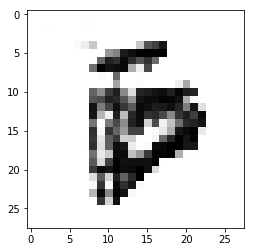

('Estimate:', array([[-4.26173496]], dtype=float32))


('Iteration:', 16000, 'at', datetime.datetime(2018, 3, 12, 12, 50, 28, 356420))


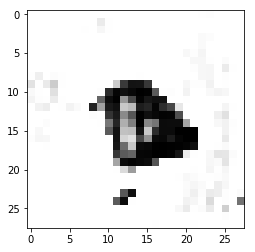

('Estimate:', array([[-9.74649429]], dtype=float32))


('Iteration:', 16100, 'at', datetime.datetime(2018, 3, 12, 12, 50, 31, 317319))


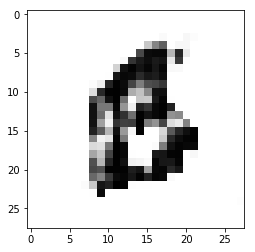

('Estimate:', array([[-1.58989978]], dtype=float32))


('Iteration:', 16200, 'at', datetime.datetime(2018, 3, 12, 12, 50, 34, 311517))


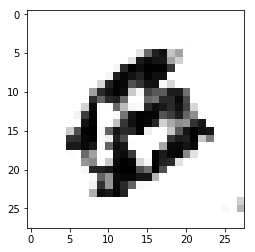

('Estimate:', array([[ 2.78026319]], dtype=float32))


('Iteration:', 16300, 'at', datetime.datetime(2018, 3, 12, 12, 50, 37, 232353))


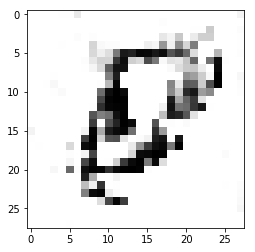

('Estimate:', array([[-13.42014885]], dtype=float32))


('Iteration:', 16400, 'at', datetime.datetime(2018, 3, 12, 12, 50, 40, 243254))


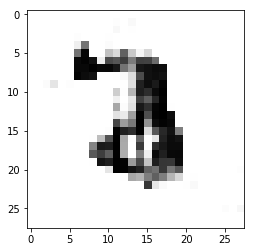

('Estimate:', array([[ 3.6511445]], dtype=float32))


('Iteration:', 16500, 'at', datetime.datetime(2018, 3, 12, 12, 50, 43, 258612))


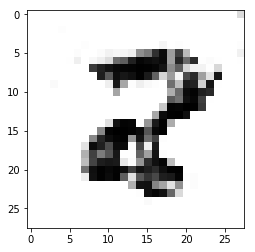

('Estimate:', array([[ 6.29113054]], dtype=float32))


('Iteration:', 16600, 'at', datetime.datetime(2018, 3, 12, 12, 50, 46, 147145))


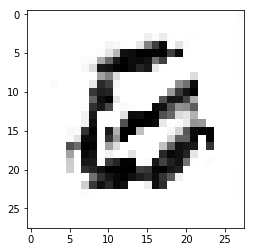

('Estimate:', array([[ 0.91977656]], dtype=float32))


('Iteration:', 16700, 'at', datetime.datetime(2018, 3, 12, 12, 50, 49, 214092))


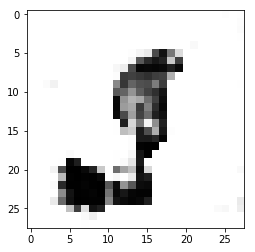

('Estimate:', array([[ 17.56718826]], dtype=float32))


('Iteration:', 16800, 'at', datetime.datetime(2018, 3, 12, 12, 50, 52, 253120))


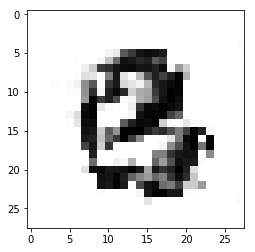

('Estimate:', array([[-5.84401846]], dtype=float32))


('Iteration:', 16900, 'at', datetime.datetime(2018, 3, 12, 12, 50, 55, 208824))


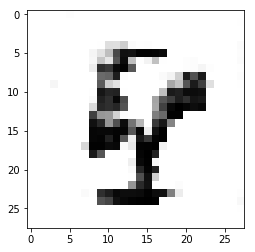

('Estimate:', array([[-0.67721725]], dtype=float32))


('Iteration:', 17000, 'at', datetime.datetime(2018, 3, 12, 12, 50, 58, 199705))


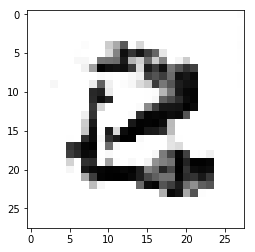

('Estimate:', array([[-1.65251112]], dtype=float32))


('Iteration:', 17100, 'at', datetime.datetime(2018, 3, 12, 12, 51, 1, 170331))


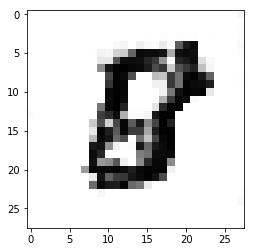

('Estimate:', array([[ 0.69595015]], dtype=float32))


('Iteration:', 17200, 'at', datetime.datetime(2018, 3, 12, 12, 51, 4, 138208))


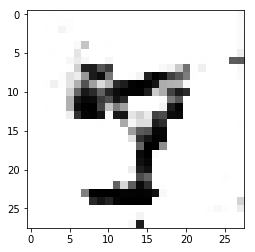

('Estimate:', array([[ 27.38474655]], dtype=float32))


('Iteration:', 17300, 'at', datetime.datetime(2018, 3, 12, 12, 51, 7, 132214))


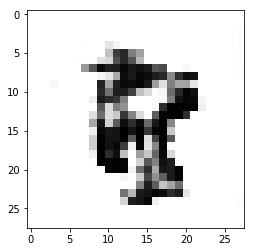

('Estimate:', array([[ 0.69472206]], dtype=float32))


('Iteration:', 17400, 'at', datetime.datetime(2018, 3, 12, 12, 51, 10, 86073))


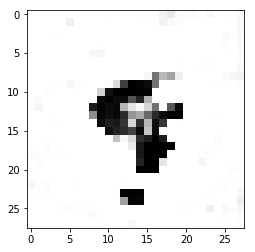

('Estimate:', array([[-7.16639137]], dtype=float32))


('Iteration:', 17500, 'at', datetime.datetime(2018, 3, 12, 12, 51, 13, 51150))


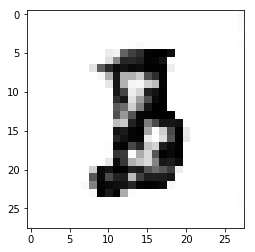

('Estimate:', array([[ 6.03359461]], dtype=float32))


('Iteration:', 17600, 'at', datetime.datetime(2018, 3, 12, 12, 51, 16, 44483))


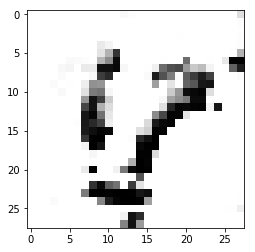

('Estimate:', array([[ 4.20637083]], dtype=float32))


('Iteration:', 17700, 'at', datetime.datetime(2018, 3, 12, 12, 51, 19, 52901))


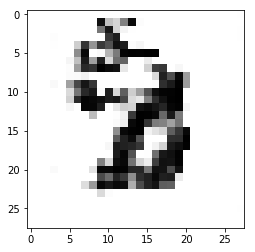

('Estimate:', array([[ 2.88969636]], dtype=float32))


('Iteration:', 17800, 'at', datetime.datetime(2018, 3, 12, 12, 51, 22, 502540))


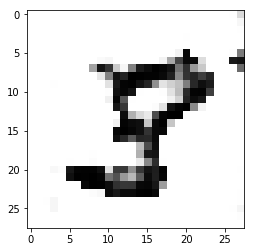

('Estimate:', array([[ 7.81135988]], dtype=float32))


('Iteration:', 17900, 'at', datetime.datetime(2018, 3, 12, 12, 51, 26, 45880))


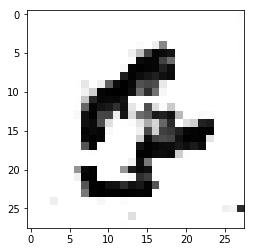

('Estimate:', array([[-1.28494179]], dtype=float32))


('Iteration:', 18000, 'at', datetime.datetime(2018, 3, 12, 12, 51, 29, 463018))


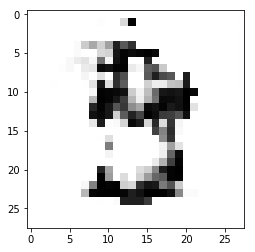

('Estimate:', array([[ 0.33371004]], dtype=float32))


('Iteration:', 18100, 'at', datetime.datetime(2018, 3, 12, 12, 51, 32, 563983))


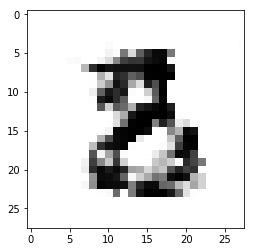

('Estimate:', array([[ 6.0580411]], dtype=float32))


('Iteration:', 18200, 'at', datetime.datetime(2018, 3, 12, 12, 51, 36, 136194))


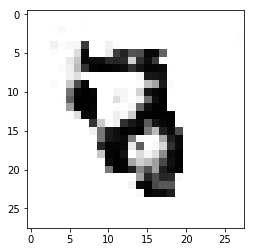

('Estimate:', array([[ 3.64634848]], dtype=float32))


('Iteration:', 18300, 'at', datetime.datetime(2018, 3, 12, 12, 51, 39, 532715))


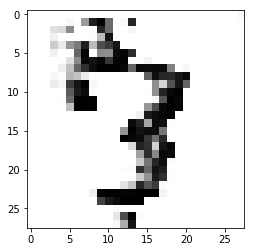

('Estimate:', array([[ 6.15067768]], dtype=float32))


('Iteration:', 18400, 'at', datetime.datetime(2018, 3, 12, 12, 51, 42, 990684))


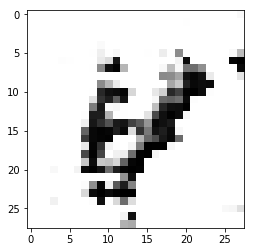

('Estimate:', array([[ 2.3286097]], dtype=float32))


('Iteration:', 18500, 'at', datetime.datetime(2018, 3, 12, 12, 51, 46, 222195))


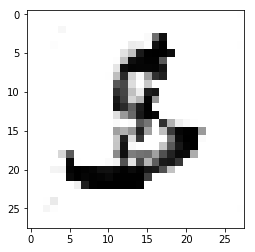

('Estimate:', array([[ 7.73582649]], dtype=float32))


('Iteration:', 18600, 'at', datetime.datetime(2018, 3, 12, 12, 51, 49, 569029))


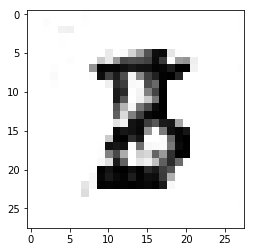

('Estimate:', array([[ 6.52202415]], dtype=float32))


('Iteration:', 18700, 'at', datetime.datetime(2018, 3, 12, 12, 51, 52, 903683))


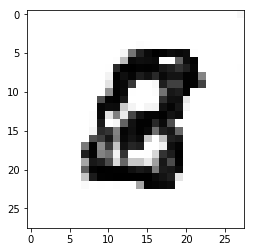

('Estimate:', array([[ 2.6558075]], dtype=float32))


('Iteration:', 18800, 'at', datetime.datetime(2018, 3, 12, 12, 51, 56, 252995))


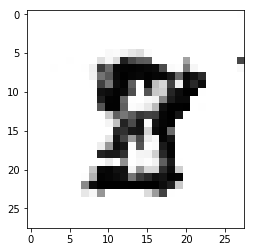

('Estimate:', array([[-0.79369158]], dtype=float32))


('Iteration:', 18900, 'at', datetime.datetime(2018, 3, 12, 12, 51, 59, 655864))


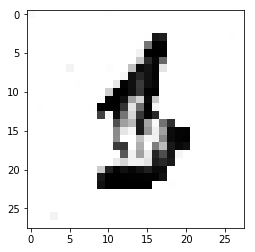

('Estimate:', array([[ 1.79745519]], dtype=float32))


('Iteration:', 19000, 'at', datetime.datetime(2018, 3, 12, 12, 52, 2, 906528))


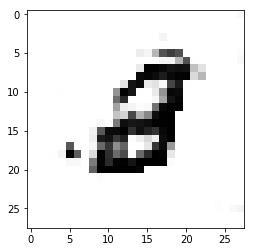

('Estimate:', array([[ 5.26249313]], dtype=float32))


('Iteration:', 19100, 'at', datetime.datetime(2018, 3, 12, 12, 52, 6, 256453))


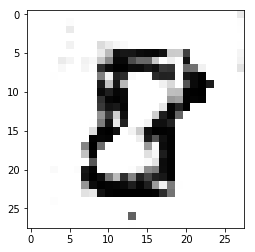

('Estimate:', array([[ 2.97013783]], dtype=float32))


('Iteration:', 19200, 'at', datetime.datetime(2018, 3, 12, 12, 52, 9, 915410))


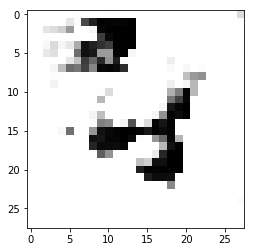

('Estimate:', array([[ 58.18431473]], dtype=float32))


('Iteration:', 19300, 'at', datetime.datetime(2018, 3, 12, 12, 52, 13, 234244))


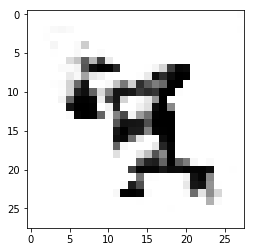

('Estimate:', array([[ 0.40626737]], dtype=float32))


('Iteration:', 19400, 'at', datetime.datetime(2018, 3, 12, 12, 52, 16, 307724))


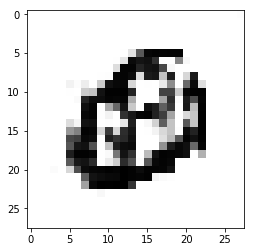

('Estimate:', array([[-8.34970665]], dtype=float32))


('Iteration:', 19500, 'at', datetime.datetime(2018, 3, 12, 12, 52, 19, 299512))


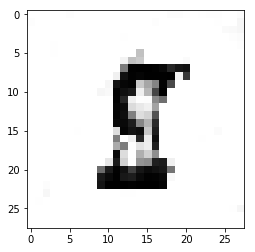

('Estimate:', array([[ 1.35442197]], dtype=float32))


('Iteration:', 19600, 'at', datetime.datetime(2018, 3, 12, 12, 52, 22, 257729))


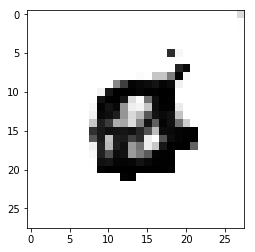

('Estimate:', array([[-7.4187212]], dtype=float32))


('Iteration:', 19700, 'at', datetime.datetime(2018, 3, 12, 12, 52, 25, 291553))


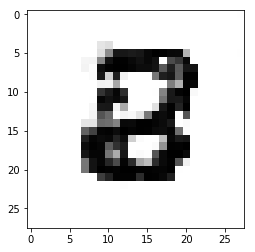

('Estimate:', array([[-0.4607912]], dtype=float32))


('Iteration:', 19800, 'at', datetime.datetime(2018, 3, 12, 12, 52, 28, 321819))


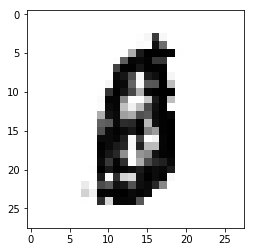

('Estimate:', array([[ 8.12818432]], dtype=float32))


('Iteration:', 19900, 'at', datetime.datetime(2018, 3, 12, 12, 52, 31, 330574))


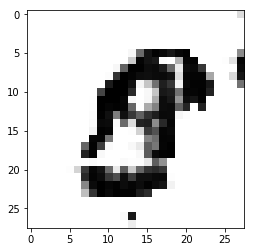

('Estimate:', array([[-1.80226171]], dtype=float32))


('Iteration:', 20000, 'at', datetime.datetime(2018, 3, 12, 12, 52, 34, 450459))


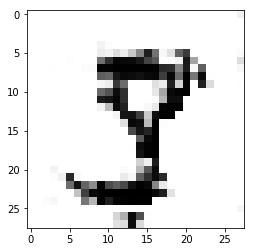

('Estimate:', array([[ 12.494277]], dtype=float32))


('Iteration:', 20100, 'at', datetime.datetime(2018, 3, 12, 12, 52, 37, 496190))


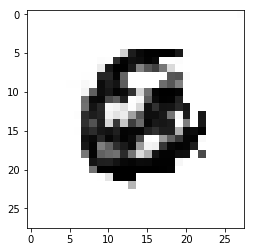

('Estimate:', array([[ 5.90595531]], dtype=float32))


('Iteration:', 20200, 'at', datetime.datetime(2018, 3, 12, 12, 52, 40, 558161))


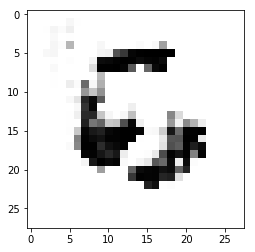

('Estimate:', array([[-0.83474338]], dtype=float32))


('Iteration:', 20300, 'at', datetime.datetime(2018, 3, 12, 12, 52, 43, 671776))


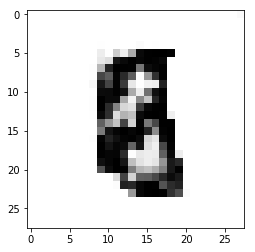

('Estimate:', array([[ 8.90876007]], dtype=float32))


('Iteration:', 20400, 'at', datetime.datetime(2018, 3, 12, 12, 52, 46, 680289))


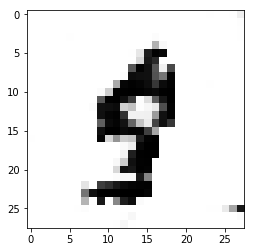

('Estimate:', array([[ 7.57183552]], dtype=float32))


('Iteration:', 20500, 'at', datetime.datetime(2018, 3, 12, 12, 52, 49, 747823))


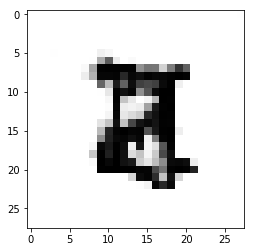

('Estimate:', array([[ 9.02569675]], dtype=float32))


('Iteration:', 20600, 'at', datetime.datetime(2018, 3, 12, 12, 52, 52, 837054))


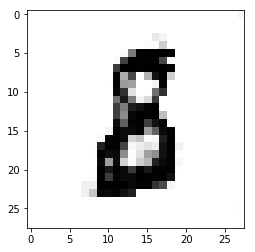

('Estimate:', array([[ 1.606704]], dtype=float32))


('Iteration:', 20700, 'at', datetime.datetime(2018, 3, 12, 12, 52, 55, 923354))


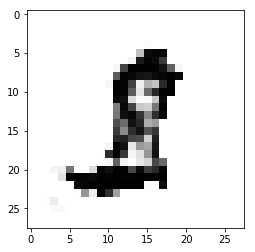

('Estimate:', array([[-4.81770754]], dtype=float32))


('Iteration:', 20800, 'at', datetime.datetime(2018, 3, 12, 12, 52, 59, 61662))


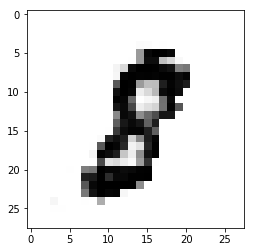

('Estimate:', array([[ 5.10683346]], dtype=float32))


('Iteration:', 20900, 'at', datetime.datetime(2018, 3, 12, 12, 53, 2, 107269))


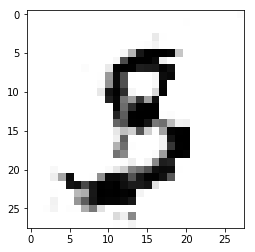

('Estimate:', array([[-8.03563309]], dtype=float32))


('Iteration:', 21000, 'at', datetime.datetime(2018, 3, 12, 12, 53, 5, 161336))


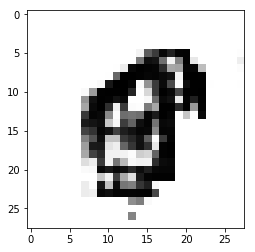

('Estimate:', array([[ 1.37868416]], dtype=float32))


('Iteration:', 21100, 'at', datetime.datetime(2018, 3, 12, 12, 53, 8, 253275))


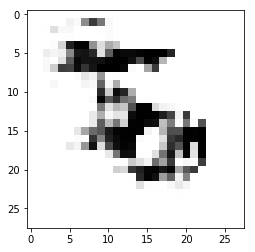

('Estimate:', array([[ 0.82864374]], dtype=float32))


('Iteration:', 21200, 'at', datetime.datetime(2018, 3, 12, 12, 53, 11, 282671))


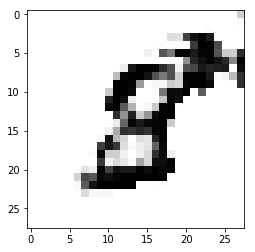

('Estimate:', array([[ 1.4340626]], dtype=float32))


('Iteration:', 21300, 'at', datetime.datetime(2018, 3, 12, 12, 53, 14, 341360))


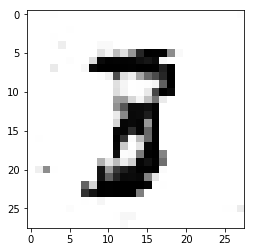

('Estimate:', array([[ 6.12559843]], dtype=float32))


('Iteration:', 21400, 'at', datetime.datetime(2018, 3, 12, 12, 53, 17, 365172))


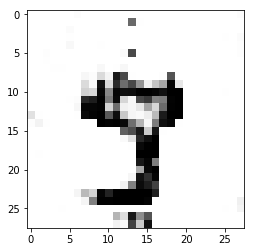

('Estimate:', array([[ 4.68436384]], dtype=float32))


('Iteration:', 21500, 'at', datetime.datetime(2018, 3, 12, 12, 53, 20, 410475))


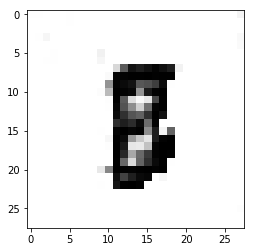

('Estimate:', array([[-8.70606327]], dtype=float32))


('Iteration:', 21600, 'at', datetime.datetime(2018, 3, 12, 12, 53, 23, 515781))


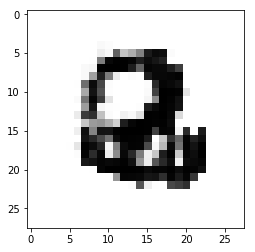

('Estimate:', array([[ 4.73157835]], dtype=float32))


('Iteration:', 21700, 'at', datetime.datetime(2018, 3, 12, 12, 53, 26, 633097))


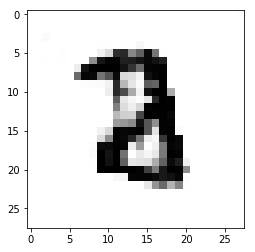

('Estimate:', array([[ 4.08372259]], dtype=float32))


('Iteration:', 21800, 'at', datetime.datetime(2018, 3, 12, 12, 53, 29, 725015))


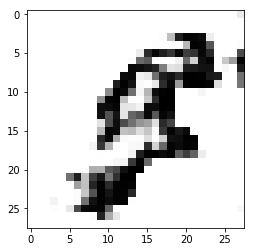

('Estimate:', array([[ 21.06182671]], dtype=float32))


('Iteration:', 21900, 'at', datetime.datetime(2018, 3, 12, 12, 53, 33, 189364))


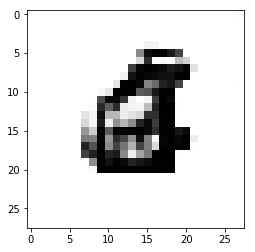

('Estimate:', array([[-5.08062363]], dtype=float32))


('Iteration:', 22000, 'at', datetime.datetime(2018, 3, 12, 12, 53, 36, 279598))


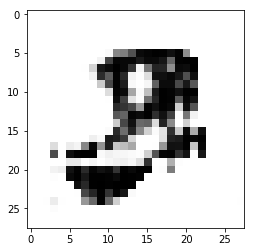

('Estimate:', array([[ 19.40076637]], dtype=float32))


('Iteration:', 22100, 'at', datetime.datetime(2018, 3, 12, 12, 53, 39, 424568))


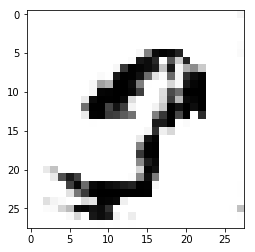

('Estimate:', array([[ 11.8626194]], dtype=float32))


('Iteration:', 22200, 'at', datetime.datetime(2018, 3, 12, 12, 53, 42, 571491))


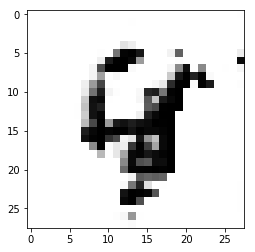

('Estimate:', array([[ 0.35097602]], dtype=float32))


('Iteration:', 22300, 'at', datetime.datetime(2018, 3, 12, 12, 53, 45, 855233))


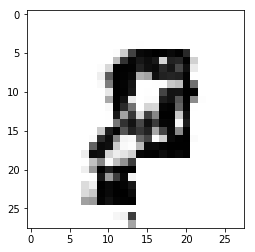

('Estimate:', array([[ 6.98247623]], dtype=float32))


('Iteration:', 22400, 'at', datetime.datetime(2018, 3, 12, 12, 53, 48, 990614))


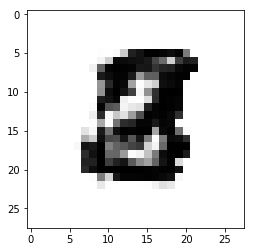

('Estimate:', array([[-5.55750084]], dtype=float32))


('Iteration:', 22500, 'at', datetime.datetime(2018, 3, 12, 12, 53, 52, 211928))


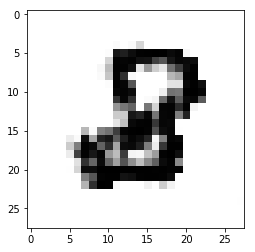

('Estimate:', array([[-6.56590986]], dtype=float32))


('Iteration:', 22600, 'at', datetime.datetime(2018, 3, 12, 12, 53, 55, 320213))


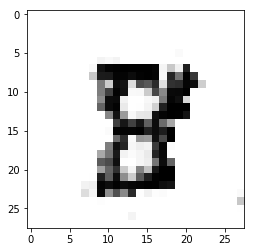

('Estimate:', array([[-10.10239124]], dtype=float32))


('Iteration:', 22700, 'at', datetime.datetime(2018, 3, 12, 12, 53, 58, 544892))


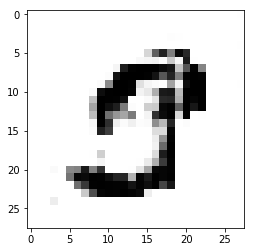

('Estimate:', array([[ 1.61676705]], dtype=float32))


('Iteration:', 22800, 'at', datetime.datetime(2018, 3, 12, 12, 54, 1, 704202))


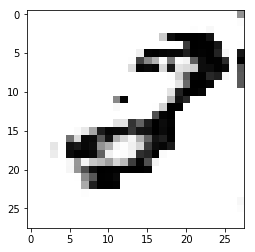

('Estimate:', array([[ 10.99806213]], dtype=float32))


('Iteration:', 22900, 'at', datetime.datetime(2018, 3, 12, 12, 54, 4, 770313))


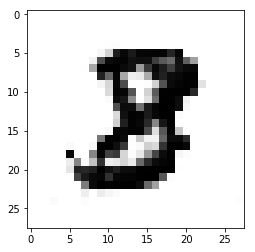

('Estimate:', array([[ 0.56185424]], dtype=float32))


('Iteration:', 23000, 'at', datetime.datetime(2018, 3, 12, 12, 54, 7, 897560))


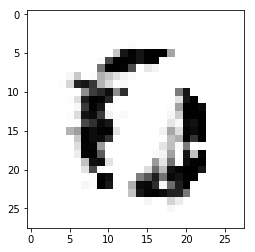

('Estimate:', array([[ 6.49964428]], dtype=float32))


('Iteration:', 23100, 'at', datetime.datetime(2018, 3, 12, 12, 54, 11, 3910))


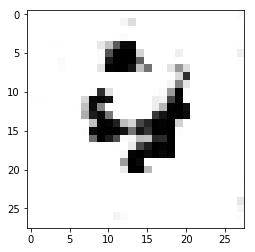

('Estimate:', array([[ 0.01374365]], dtype=float32))


('Iteration:', 23200, 'at', datetime.datetime(2018, 3, 12, 12, 54, 14, 147844))


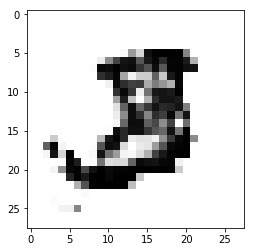

('Estimate:', array([[ 0.45001286]], dtype=float32))


('Iteration:', 23300, 'at', datetime.datetime(2018, 3, 12, 12, 54, 17, 266145))


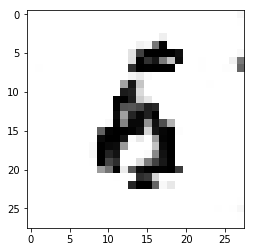

('Estimate:', array([[-1.81797135]], dtype=float32))


('Iteration:', 23400, 'at', datetime.datetime(2018, 3, 12, 12, 54, 20, 349691))


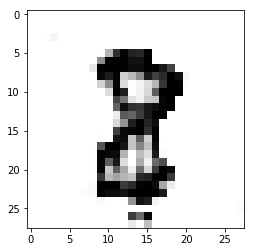

('Estimate:', array([[-7.4808774]], dtype=float32))


('Iteration:', 23500, 'at', datetime.datetime(2018, 3, 12, 12, 54, 23, 471946))


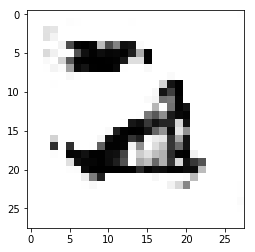

('Estimate:', array([[ 3.26904392]], dtype=float32))


('Iteration:', 23600, 'at', datetime.datetime(2018, 3, 12, 12, 54, 26, 546961))


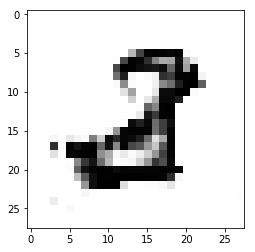

('Estimate:', array([[ 8.02466202]], dtype=float32))


('Iteration:', 23700, 'at', datetime.datetime(2018, 3, 12, 12, 54, 29, 647816))


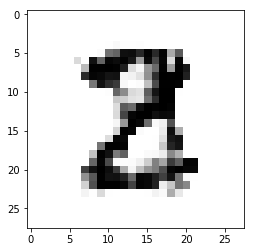

('Estimate:', array([[ 11.67423725]], dtype=float32))


('Iteration:', 23800, 'at', datetime.datetime(2018, 3, 12, 12, 54, 32, 828558))


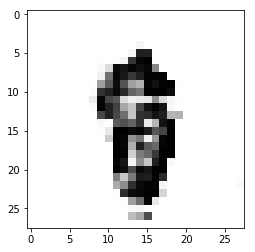

('Estimate:', array([[ 9.28192329]], dtype=float32))


('Iteration:', 23900, 'at', datetime.datetime(2018, 3, 12, 12, 54, 36, 23467))


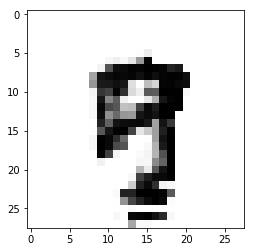

('Estimate:', array([[ 10.08777428]], dtype=float32))


('Iteration:', 24000, 'at', datetime.datetime(2018, 3, 12, 12, 54, 39, 161400))


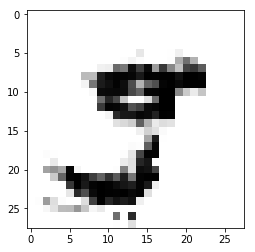

('Estimate:', array([[-10.29062462]], dtype=float32))


('Iteration:', 24100, 'at', datetime.datetime(2018, 3, 12, 12, 54, 42, 269292))


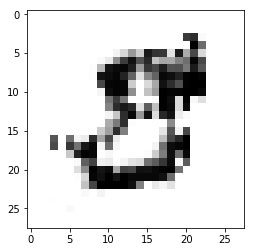

('Estimate:', array([[-6.61211777]], dtype=float32))


('Iteration:', 24200, 'at', datetime.datetime(2018, 3, 12, 12, 54, 45, 481322))


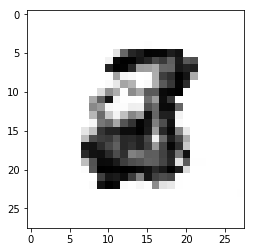

('Estimate:', array([[-12.84647274]], dtype=float32))


('Iteration:', 24300, 'at', datetime.datetime(2018, 3, 12, 12, 54, 48, 592770))


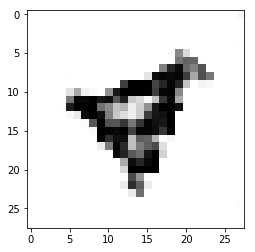

('Estimate:', array([[-8.05915642]], dtype=float32))


('Iteration:', 24400, 'at', datetime.datetime(2018, 3, 12, 12, 54, 51, 654818))


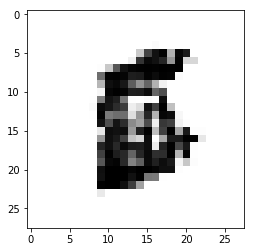

('Estimate:', array([[ 2.42050338]], dtype=float32))


('Iteration:', 24500, 'at', datetime.datetime(2018, 3, 12, 12, 54, 54, 740366))


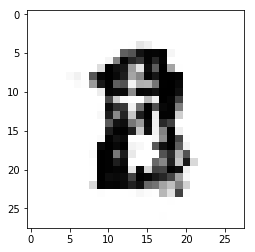

('Estimate:', array([[ 17.52045822]], dtype=float32))


('Iteration:', 24600, 'at', datetime.datetime(2018, 3, 12, 12, 54, 57, 832321))


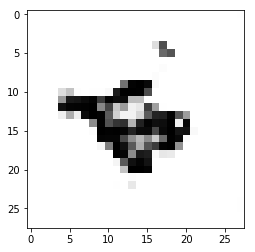

('Estimate:', array([[-6.06518555]], dtype=float32))


('Iteration:', 24700, 'at', datetime.datetime(2018, 3, 12, 12, 55, 0, 947656))


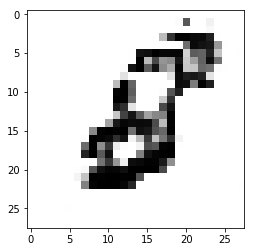

('Estimate:', array([[-7.74277258]], dtype=float32))


('Iteration:', 24800, 'at', datetime.datetime(2018, 3, 12, 12, 55, 4, 85687))


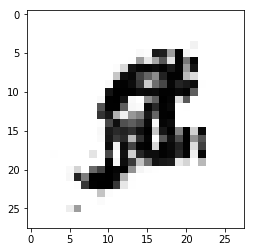

('Estimate:', array([[ 7.61801577]], dtype=float32))


('Iteration:', 24900, 'at', datetime.datetime(2018, 3, 12, 12, 55, 7, 197903))


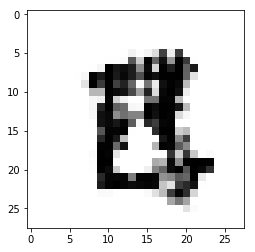

('Estimate:', array([[-10.22589684]], dtype=float32))


('Iteration:', 25000, 'at', datetime.datetime(2018, 3, 12, 12, 55, 10, 329457))


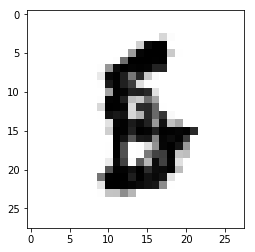

('Estimate:', array([[ 6.0600481]], dtype=float32))


('Iteration:', 25100, 'at', datetime.datetime(2018, 3, 12, 12, 55, 13, 493424))


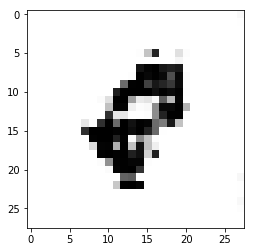

('Estimate:', array([[ 3.97564697]], dtype=float32))


('Iteration:', 25200, 'at', datetime.datetime(2018, 3, 12, 12, 55, 16, 634967))


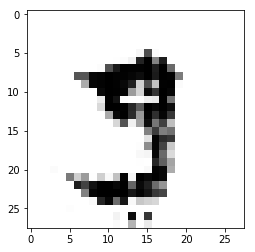

('Estimate:', array([[ 5.03199863]], dtype=float32))


('Iteration:', 25300, 'at', datetime.datetime(2018, 3, 12, 12, 55, 19, 776237))


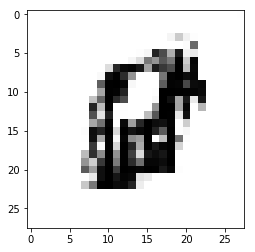

('Estimate:', array([[-0.77875781]], dtype=float32))


('Iteration:', 25400, 'at', datetime.datetime(2018, 3, 12, 12, 55, 22, 887652))


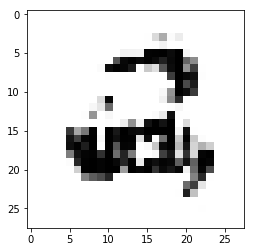

('Estimate:', array([[-1.2735672]], dtype=float32))


('Iteration:', 25500, 'at', datetime.datetime(2018, 3, 12, 12, 55, 26, 5056))


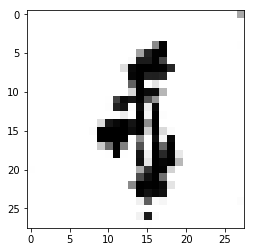

('Estimate:', array([[ 5.53691769]], dtype=float32))


('Iteration:', 25600, 'at', datetime.datetime(2018, 3, 12, 12, 55, 29, 139912))


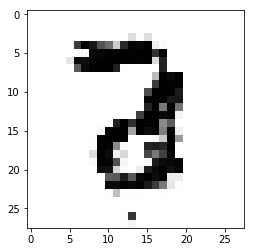

('Estimate:', array([[ 9.97366428]], dtype=float32))


('Iteration:', 25700, 'at', datetime.datetime(2018, 3, 12, 12, 55, 32, 336195))


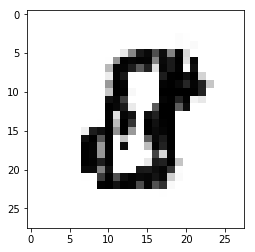

('Estimate:', array([[ 0.36397809]], dtype=float32))


('Iteration:', 25800, 'at', datetime.datetime(2018, 3, 12, 12, 55, 35, 479228))


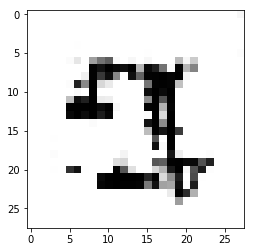

('Estimate:', array([[ 8.16954517]], dtype=float32))


('Iteration:', 25900, 'at', datetime.datetime(2018, 3, 12, 12, 55, 39, 128701))


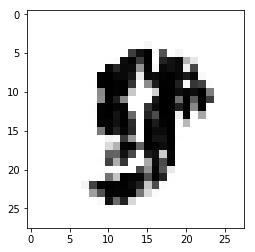

('Estimate:', array([[-3.6838553]], dtype=float32))


('Iteration:', 26000, 'at', datetime.datetime(2018, 3, 12, 12, 55, 42, 710516))


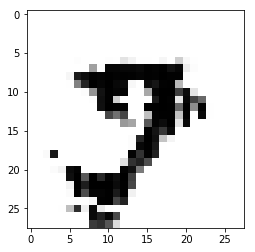

('Estimate:', array([[ 2.25603104]], dtype=float32))


('Iteration:', 26100, 'at', datetime.datetime(2018, 3, 12, 12, 55, 46, 247887))


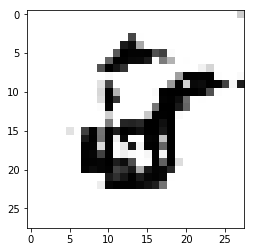

('Estimate:', array([[ 1.76982474]], dtype=float32))


('Iteration:', 26200, 'at', datetime.datetime(2018, 3, 12, 12, 55, 49, 434979))


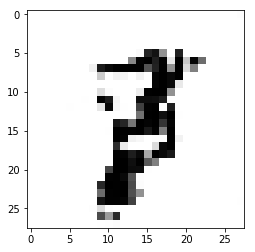

('Estimate:', array([[-6.09964848]], dtype=float32))


('Iteration:', 26300, 'at', datetime.datetime(2018, 3, 12, 12, 55, 52, 725963))


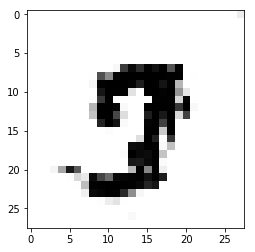

('Estimate:', array([[ 7.04746962]], dtype=float32))


('Iteration:', 26400, 'at', datetime.datetime(2018, 3, 12, 12, 55, 56, 154921))


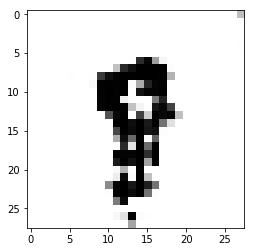

('Estimate:', array([[-2.15287471]], dtype=float32))


('Iteration:', 26500, 'at', datetime.datetime(2018, 3, 12, 12, 55, 59, 451069))


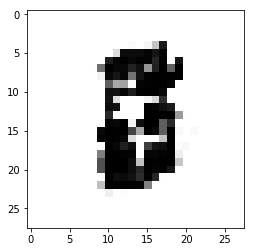

('Estimate:', array([[-5.96569443]], dtype=float32))


('Iteration:', 26600, 'at', datetime.datetime(2018, 3, 12, 12, 56, 2, 677398))


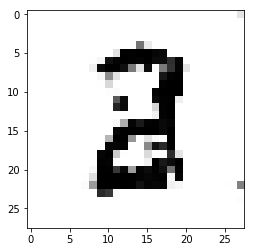

('Estimate:', array([[-0.66330451]], dtype=float32))


('Iteration:', 26700, 'at', datetime.datetime(2018, 3, 12, 12, 56, 6, 22812))


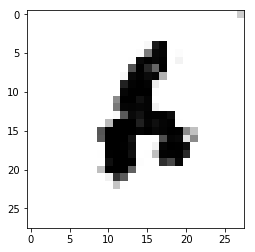

('Estimate:', array([[ 8.35111713]], dtype=float32))


('Iteration:', 26800, 'at', datetime.datetime(2018, 3, 12, 12, 56, 9, 433405))


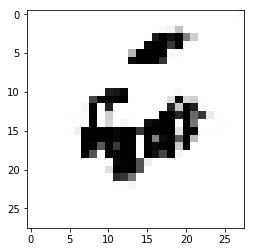

('Estimate:', array([[-0.90462977]], dtype=float32))


('Iteration:', 26900, 'at', datetime.datetime(2018, 3, 12, 12, 56, 13, 113744))


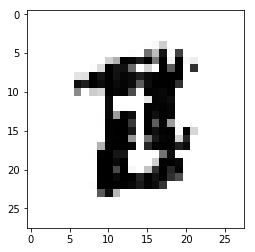

('Estimate:', array([[-2.96513057]], dtype=float32))


('Iteration:', 27000, 'at', datetime.datetime(2018, 3, 12, 12, 56, 16, 807615))


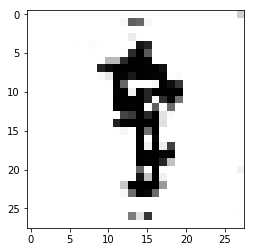

('Estimate:', array([[ 2.33527422]], dtype=float32))


('Iteration:', 27100, 'at', datetime.datetime(2018, 3, 12, 12, 56, 20, 398221))


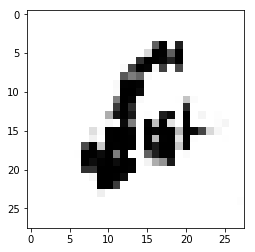

('Estimate:', array([[-3.41616392]], dtype=float32))


('Iteration:', 27200, 'at', datetime.datetime(2018, 3, 12, 12, 56, 23, 886558))


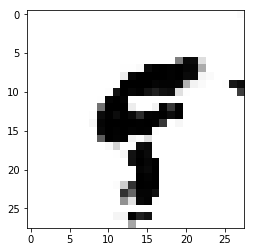

('Estimate:', array([[-3.35085034]], dtype=float32))


('Iteration:', 27300, 'at', datetime.datetime(2018, 3, 12, 12, 56, 27, 159459))


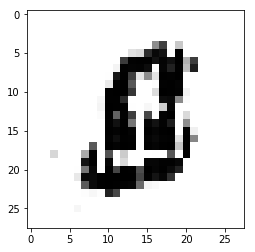

('Estimate:', array([[-8.17326069]], dtype=float32))


('Iteration:', 27400, 'at', datetime.datetime(2018, 3, 12, 12, 56, 32, 110165))


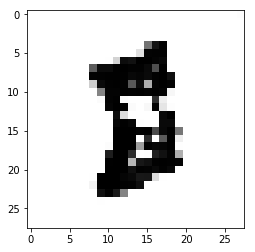

('Estimate:', array([[ 2.66737652]], dtype=float32))


('Iteration:', 27500, 'at', datetime.datetime(2018, 3, 12, 12, 56, 35, 335124))


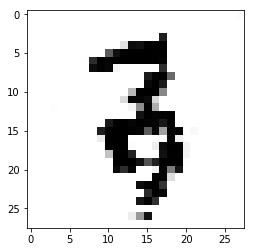

('Estimate:', array([[ 4.78102922]], dtype=float32))


('Iteration:', 27600, 'at', datetime.datetime(2018, 3, 12, 12, 56, 38, 919101))


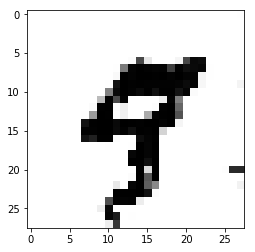

('Estimate:', array([[ 4.68728828]], dtype=float32))


('Iteration:', 27700, 'at', datetime.datetime(2018, 3, 12, 12, 56, 42, 89357))


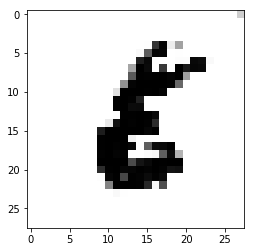

('Estimate:', array([[ 4.09862232]], dtype=float32))


('Iteration:', 27800, 'at', datetime.datetime(2018, 3, 12, 12, 56, 45, 298706))


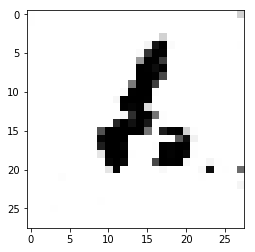

('Estimate:', array([[ 2.64108062]], dtype=float32))


('Iteration:', 27900, 'at', datetime.datetime(2018, 3, 12, 12, 56, 48, 582232))


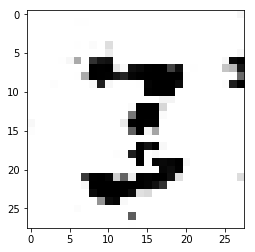

('Estimate:', array([[ 7.73673439]], dtype=float32))


('Iteration:', 28000, 'at', datetime.datetime(2018, 3, 12, 12, 56, 51, 791257))


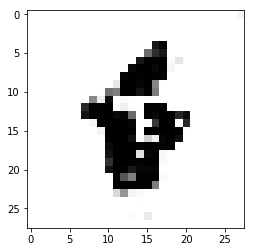

('Estimate:', array([[-0.65227002]], dtype=float32))


('Iteration:', 28100, 'at', datetime.datetime(2018, 3, 12, 12, 56, 55, 24918))


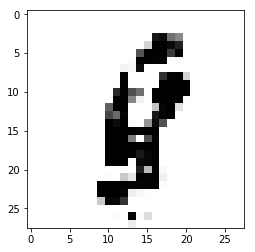

('Estimate:', array([[ 3.68369842]], dtype=float32))


('Iteration:', 28200, 'at', datetime.datetime(2018, 3, 12, 12, 56, 58, 385026))


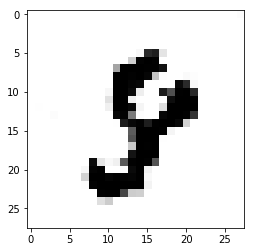

('Estimate:', array([[-3.46249008]], dtype=float32))


('Iteration:', 28300, 'at', datetime.datetime(2018, 3, 12, 12, 57, 2, 238314))


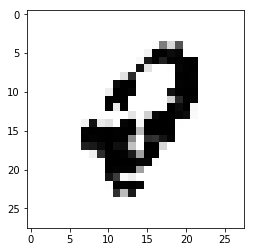

('Estimate:', array([[-2.76155734]], dtype=float32))


('Iteration:', 28400, 'at', datetime.datetime(2018, 3, 12, 12, 57, 5, 511640))


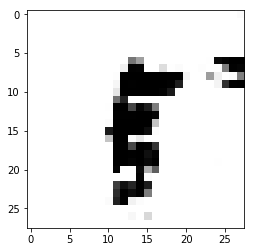

('Estimate:', array([[ 5.88981056]], dtype=float32))


('Iteration:', 28500, 'at', datetime.datetime(2018, 3, 12, 12, 57, 8, 782538))


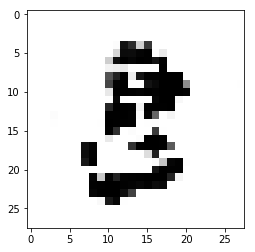

('Estimate:', array([[-0.88425815]], dtype=float32))


('Iteration:', 28600, 'at', datetime.datetime(2018, 3, 12, 12, 57, 11, 970979))


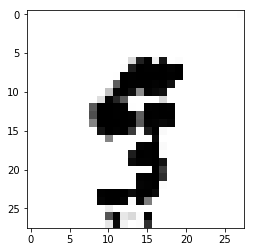

('Estimate:', array([[ 0.7312144]], dtype=float32))


('Iteration:', 28700, 'at', datetime.datetime(2018, 3, 12, 12, 57, 15, 334559))


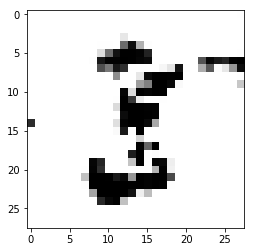

('Estimate:', array([[ 2.88558745]], dtype=float32))


('Iteration:', 28800, 'at', datetime.datetime(2018, 3, 12, 12, 57, 18, 748183))


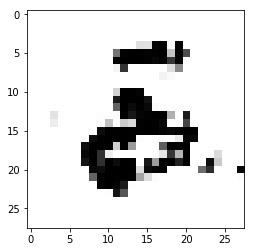

('Estimate:', array([[-4.10636377]], dtype=float32))


('Iteration:', 28900, 'at', datetime.datetime(2018, 3, 12, 12, 57, 22, 105247))


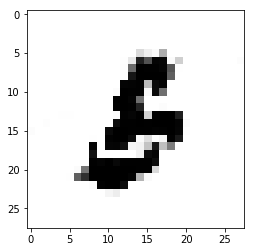

('Estimate:', array([[-1.99075532]], dtype=float32))


('Iteration:', 29000, 'at', datetime.datetime(2018, 3, 12, 12, 57, 25, 522719))


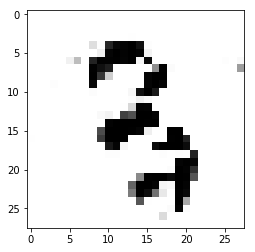

('Estimate:', array([[ 6.86780167]], dtype=float32))


('Iteration:', 29100, 'at', datetime.datetime(2018, 3, 12, 12, 57, 28, 982584))


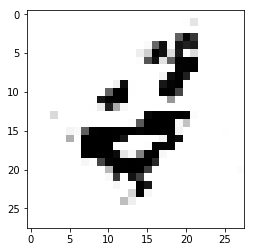

('Estimate:', array([[-4.09905767]], dtype=float32))


('Iteration:', 29200, 'at', datetime.datetime(2018, 3, 12, 12, 57, 32, 575085))


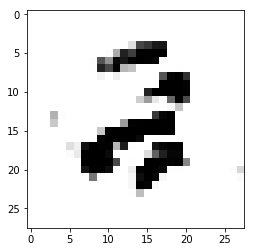

('Estimate:', array([[-1.85653913]], dtype=float32))


('Iteration:', 29300, 'at', datetime.datetime(2018, 3, 12, 12, 57, 35, 946398))


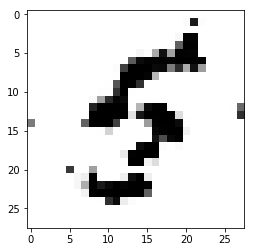

('Estimate:', array([[ 5.56064701]], dtype=float32))


('Iteration:', 29400, 'at', datetime.datetime(2018, 3, 12, 12, 57, 39, 602423))


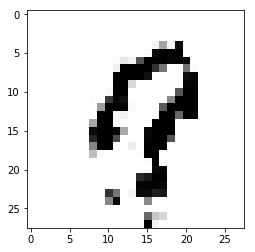

('Estimate:', array([[ 8.3658514]], dtype=float32))


('Iteration:', 29500, 'at', datetime.datetime(2018, 3, 12, 12, 57, 43, 697722))


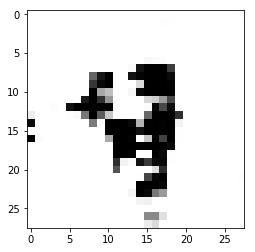

('Estimate:', array([[-3.62687707]], dtype=float32))


('Iteration:', 29600, 'at', datetime.datetime(2018, 3, 12, 12, 57, 47, 217004))


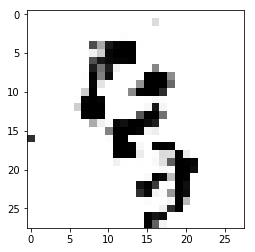

('Estimate:', array([[ 1.21220875]], dtype=float32))


('Iteration:', 29700, 'at', datetime.datetime(2018, 3, 12, 12, 57, 50, 517024))


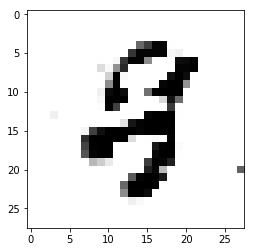

('Estimate:', array([[ 4.39184761]], dtype=float32))


('Iteration:', 29800, 'at', datetime.datetime(2018, 3, 12, 12, 57, 53, 760694))


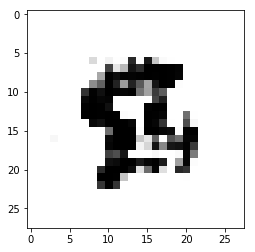

('Estimate:', array([[-6.47919416]], dtype=float32))


('Iteration:', 29900, 'at', datetime.datetime(2018, 3, 12, 12, 57, 57, 6870))


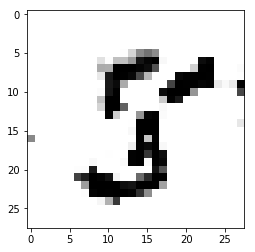

('Estimate:', array([[ 4.43466043]], dtype=float32))


('Iteration:', 30000, 'at', datetime.datetime(2018, 3, 12, 12, 58, 0, 334679))


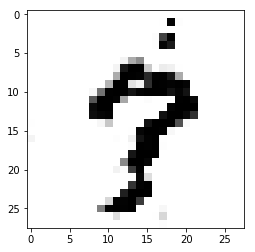

('Estimate:', array([[-2.41815138]], dtype=float32))


('Iteration:', 30100, 'at', datetime.datetime(2018, 3, 12, 12, 58, 4, 70755))


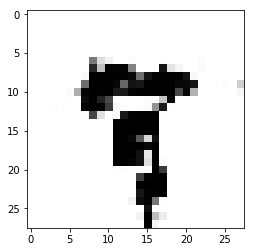

('Estimate:', array([[ 16.70705605]], dtype=float32))


('Iteration:', 30200, 'at', datetime.datetime(2018, 3, 12, 12, 58, 7, 335660))


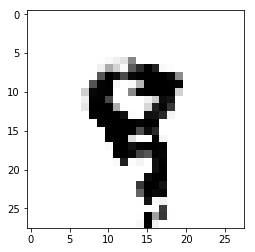

('Estimate:', array([[ 10.44572067]], dtype=float32))


('Iteration:', 30300, 'at', datetime.datetime(2018, 3, 12, 12, 58, 10, 615463))


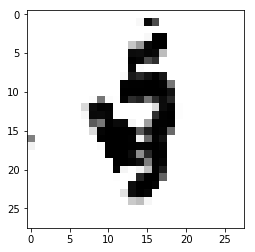

('Estimate:', array([[ 0.79008156]], dtype=float32))


('Iteration:', 30400, 'at', datetime.datetime(2018, 3, 12, 12, 58, 13, 873221))


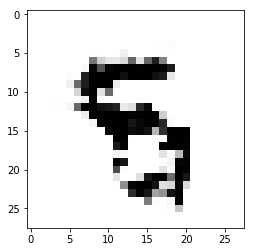

('Estimate:', array([[ 6.53541613]], dtype=float32))


('Iteration:', 30500, 'at', datetime.datetime(2018, 3, 12, 12, 58, 17, 689699))


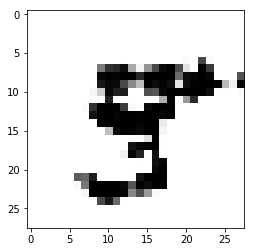

('Estimate:', array([[ 3.21727395]], dtype=float32))


('Iteration:', 30600, 'at', datetime.datetime(2018, 3, 12, 12, 58, 20, 995508))


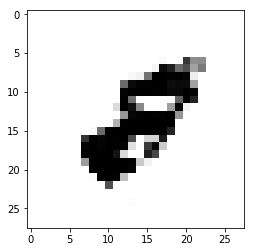

('Estimate:', array([[-2.19860125]], dtype=float32))


('Iteration:', 30700, 'at', datetime.datetime(2018, 3, 12, 12, 58, 24, 307324))


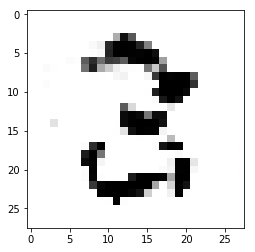

('Estimate:', array([[ 8.62489033]], dtype=float32))


('Iteration:', 30800, 'at', datetime.datetime(2018, 3, 12, 12, 58, 27, 596824))


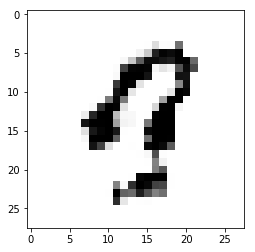

('Estimate:', array([[-13.59549046]], dtype=float32))


('Iteration:', 30900, 'at', datetime.datetime(2018, 3, 12, 12, 58, 30, 851752))


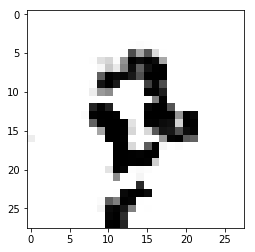

('Estimate:', array([[ 8.00450897]], dtype=float32))


('Iteration:', 31000, 'at', datetime.datetime(2018, 3, 12, 12, 58, 34, 94288))


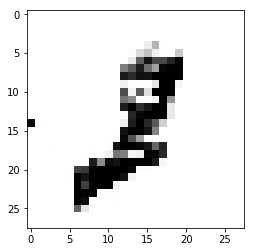

('Estimate:', array([[-2.75240541]], dtype=float32))


('Iteration:', 31100, 'at', datetime.datetime(2018, 3, 12, 12, 58, 37, 336697))


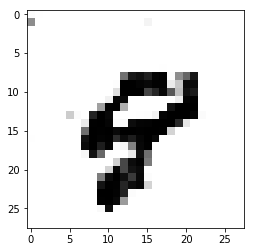

('Estimate:', array([[-1.01700234]], dtype=float32))


('Iteration:', 31200, 'at', datetime.datetime(2018, 3, 12, 12, 58, 40, 583670))


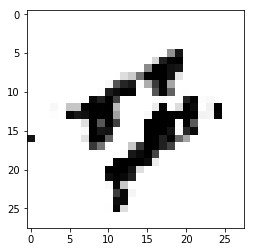

('Estimate:', array([[-3.25737739]], dtype=float32))


('Iteration:', 31300, 'at', datetime.datetime(2018, 3, 12, 12, 58, 43, 845409))


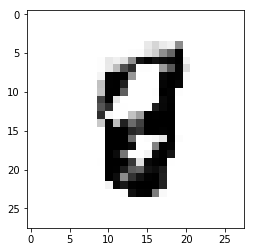

('Estimate:', array([[-2.29421949]], dtype=float32))


('Iteration:', 31400, 'at', datetime.datetime(2018, 3, 12, 12, 58, 47, 141893))


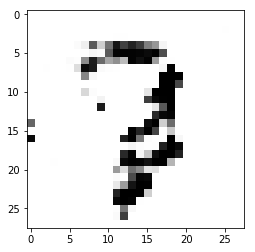

('Estimate:', array([[-3.04175544]], dtype=float32))


('Iteration:', 31500, 'at', datetime.datetime(2018, 3, 12, 12, 58, 50, 472143))


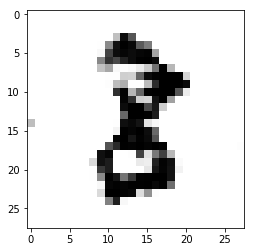

('Estimate:', array([[-9.67651653]], dtype=float32))


('Iteration:', 31600, 'at', datetime.datetime(2018, 3, 12, 12, 58, 53, 812460))


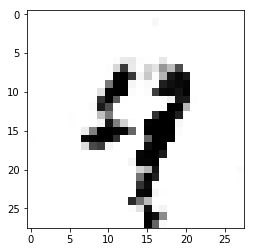

('Estimate:', array([[ 1.5664047]], dtype=float32))


('Iteration:', 31700, 'at', datetime.datetime(2018, 3, 12, 12, 58, 57, 54709))


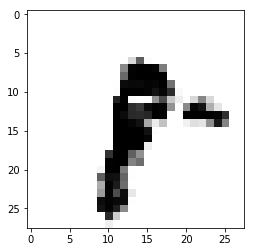

('Estimate:', array([[ 11.41918087]], dtype=float32))


('Iteration:', 31800, 'at', datetime.datetime(2018, 3, 12, 12, 59, 0, 354980))


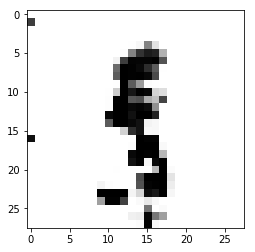

('Estimate:', array([[-5.46598148]], dtype=float32))


('Iteration:', 31900, 'at', datetime.datetime(2018, 3, 12, 12, 59, 3, 668043))


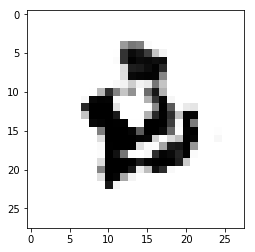

('Estimate:', array([[-4.04122829]], dtype=float32))


('Iteration:', 32000, 'at', datetime.datetime(2018, 3, 12, 12, 59, 6, 956449))


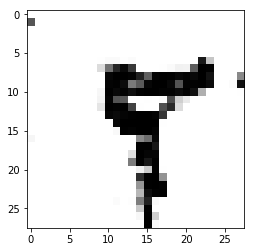

('Estimate:', array([[ 4.11986732]], dtype=float32))


('Iteration:', 32100, 'at', datetime.datetime(2018, 3, 12, 12, 59, 10, 221300))


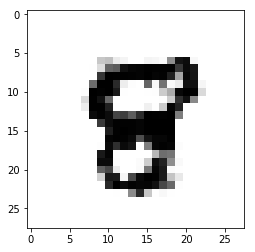

('Estimate:', array([[-2.90218282]], dtype=float32))


('Iteration:', 32200, 'at', datetime.datetime(2018, 3, 12, 12, 59, 13, 558354))


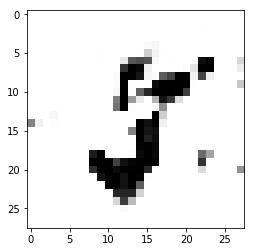

('Estimate:', array([[-8.91200352]], dtype=float32))


('Iteration:', 32300, 'at', datetime.datetime(2018, 3, 12, 12, 59, 16, 783956))


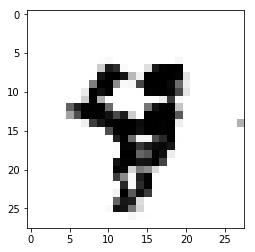

('Estimate:', array([[-0.79244077]], dtype=float32))


('Iteration:', 32400, 'at', datetime.datetime(2018, 3, 12, 12, 59, 20, 36616))


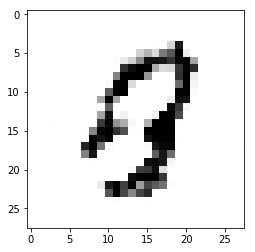

('Estimate:', array([[-4.95736694]], dtype=float32))


('Iteration:', 32500, 'at', datetime.datetime(2018, 3, 12, 12, 59, 23, 305521))


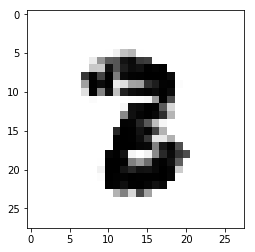

('Estimate:', array([[ 0.81845689]], dtype=float32))


('Iteration:', 32600, 'at', datetime.datetime(2018, 3, 12, 12, 59, 26, 547164))


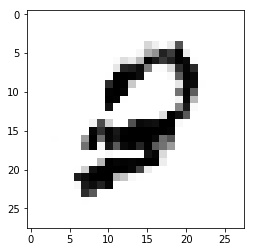

('Estimate:', array([[-0.04081174]], dtype=float32))


('Iteration:', 32700, 'at', datetime.datetime(2018, 3, 12, 12, 59, 29, 894141))


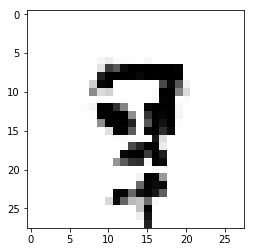

('Estimate:', array([[-5.55909538]], dtype=float32))


('Iteration:', 32800, 'at', datetime.datetime(2018, 3, 12, 12, 59, 33, 153942))


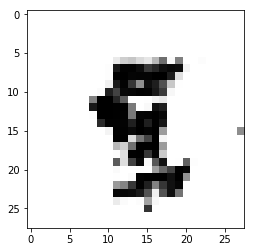

('Estimate:', array([[-3.0303731]], dtype=float32))


('Iteration:', 32900, 'at', datetime.datetime(2018, 3, 12, 12, 59, 36, 396021))


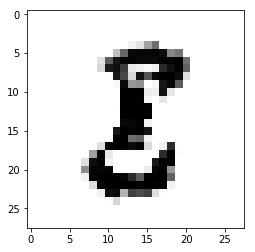

('Estimate:', array([[-0.03073647]], dtype=float32))


('Iteration:', 33000, 'at', datetime.datetime(2018, 3, 12, 12, 59, 39, 684959))


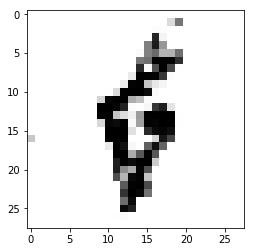

('Estimate:', array([[-0.96859002]], dtype=float32))


('Iteration:', 33100, 'at', datetime.datetime(2018, 3, 12, 12, 59, 42, 955246))


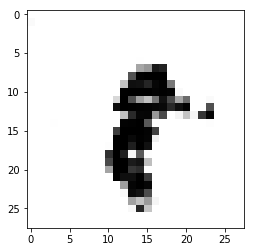

('Estimate:', array([[ 4.59134054]], dtype=float32))


('Iteration:', 33200, 'at', datetime.datetime(2018, 3, 12, 12, 59, 46, 287670))


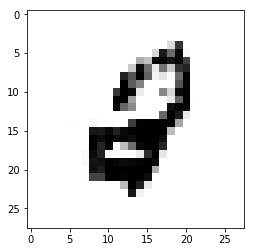

('Estimate:', array([[ 1.78170931]], dtype=float32))


('Iteration:', 33300, 'at', datetime.datetime(2018, 3, 12, 12, 59, 49, 552333))


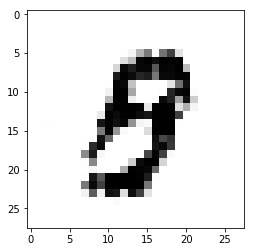

('Estimate:', array([[-6.07103825]], dtype=float32))


('Iteration:', 33400, 'at', datetime.datetime(2018, 3, 12, 12, 59, 52, 912229))


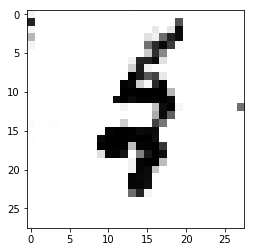

('Estimate:', array([[ 6.18769169]], dtype=float32))


('Iteration:', 33500, 'at', datetime.datetime(2018, 3, 12, 12, 59, 56, 185740))


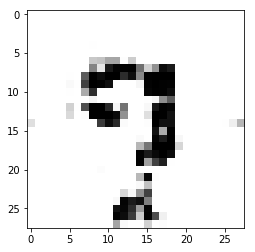

('Estimate:', array([[-5.22292471]], dtype=float32))


('Iteration:', 33600, 'at', datetime.datetime(2018, 3, 12, 12, 59, 59, 504138))


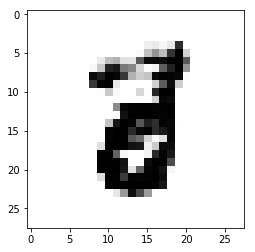

('Estimate:', array([[ 1.12172723]], dtype=float32))


('Iteration:', 33700, 'at', datetime.datetime(2018, 3, 12, 13, 0, 2, 827633))


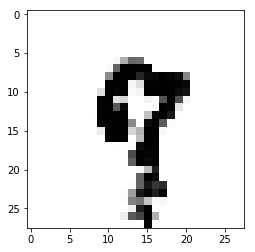

('Estimate:', array([[ 5.84488249]], dtype=float32))


('Iteration:', 33800, 'at', datetime.datetime(2018, 3, 12, 13, 0, 6, 128947))


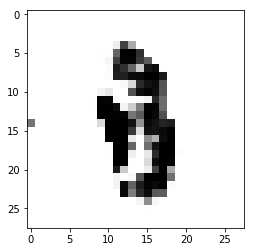

('Estimate:', array([[-5.93048906]], dtype=float32))


('Iteration:', 33900, 'at', datetime.datetime(2018, 3, 12, 13, 0, 9, 433066))


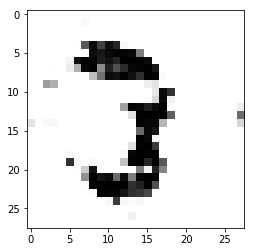

('Estimate:', array([[-17.53713989]], dtype=float32))


('Iteration:', 34000, 'at', datetime.datetime(2018, 3, 12, 13, 0, 12, 760994))


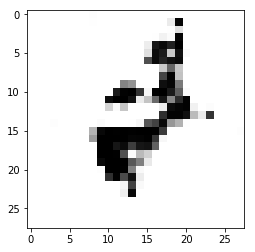

('Estimate:', array([[-5.63923311]], dtype=float32))


('Iteration:', 34100, 'at', datetime.datetime(2018, 3, 12, 13, 0, 16, 70222))


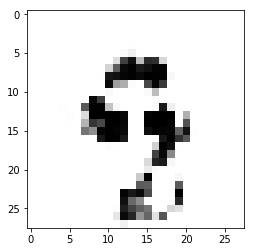

('Estimate:', array([[-8.86929607]], dtype=float32))


('Iteration:', 34200, 'at', datetime.datetime(2018, 3, 12, 13, 0, 19, 405707))


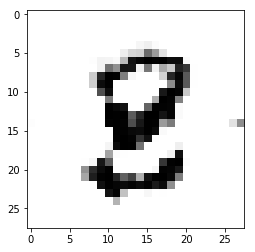

('Estimate:', array([[-3.205024]], dtype=float32))


('Iteration:', 34300, 'at', datetime.datetime(2018, 3, 12, 13, 0, 22, 671503))


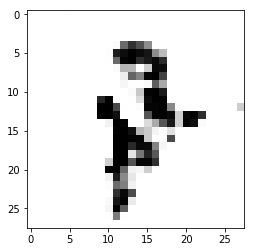

('Estimate:', array([[ 2.53671336]], dtype=float32))


('Iteration:', 34400, 'at', datetime.datetime(2018, 3, 12, 13, 0, 25, 967671))


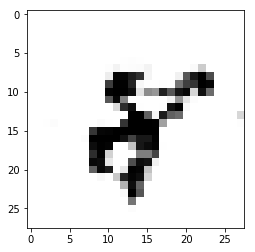

('Estimate:', array([[-3.5479548]], dtype=float32))


('Iteration:', 34500, 'at', datetime.datetime(2018, 3, 12, 13, 0, 29, 277750))


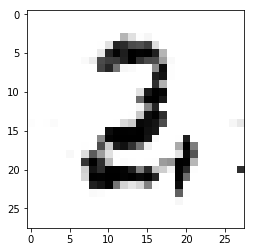

('Estimate:', array([[-8.50514412]], dtype=float32))


('Iteration:', 34600, 'at', datetime.datetime(2018, 3, 12, 13, 0, 32, 600559))


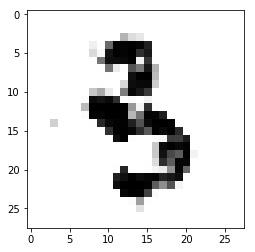

('Estimate:', array([[ 8.32888985]], dtype=float32))


('Iteration:', 34700, 'at', datetime.datetime(2018, 3, 12, 13, 0, 35, 960241))


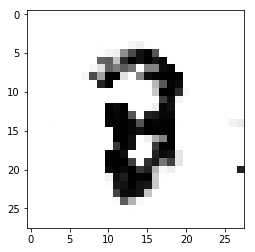

('Estimate:', array([[ 6.11254597]], dtype=float32))


('Iteration:', 34800, 'at', datetime.datetime(2018, 3, 12, 13, 0, 39, 288364))


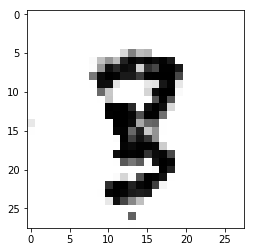

('Estimate:', array([[ 2.51627684]], dtype=float32))


('Iteration:', 34900, 'at', datetime.datetime(2018, 3, 12, 13, 0, 42, 643387))


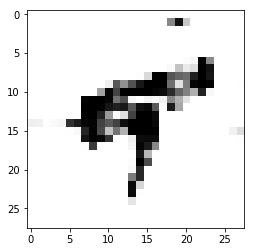

('Estimate:', array([[-4.74334574]], dtype=float32))


('Iteration:', 35000, 'at', datetime.datetime(2018, 3, 12, 13, 0, 45, 964433))


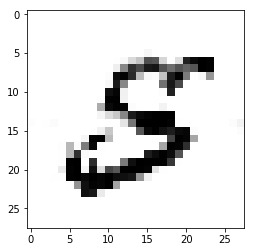

('Estimate:', array([[-5.83710623]], dtype=float32))


('Iteration:', 35100, 'at', datetime.datetime(2018, 3, 12, 13, 0, 49, 289447))


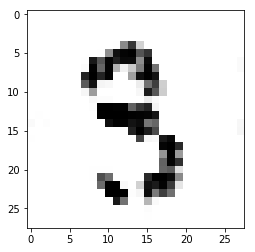

('Estimate:', array([[-7.1918664]], dtype=float32))


('Iteration:', 35200, 'at', datetime.datetime(2018, 3, 12, 13, 0, 52, 630932))


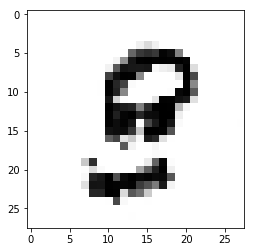

('Estimate:', array([[-5.40262556]], dtype=float32))


('Iteration:', 35300, 'at', datetime.datetime(2018, 3, 12, 13, 0, 55, 902529))


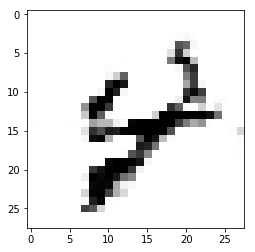

('Estimate:', array([[ 1.11590731]], dtype=float32))


('Iteration:', 35400, 'at', datetime.datetime(2018, 3, 12, 13, 0, 59, 193046))


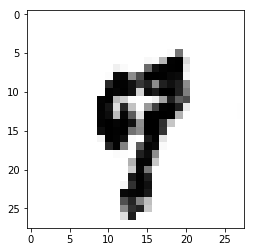

('Estimate:', array([[-1.94799638]], dtype=float32))


('Iteration:', 35500, 'at', datetime.datetime(2018, 3, 12, 13, 1, 2, 556312))


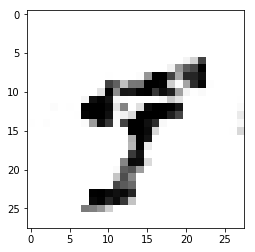

('Estimate:', array([[ 0.74158859]], dtype=float32))


('Iteration:', 35600, 'at', datetime.datetime(2018, 3, 12, 13, 1, 5, 912049))


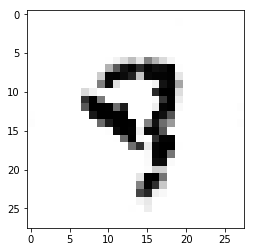

('Estimate:', array([[ 2.57599878]], dtype=float32))


('Iteration:', 35700, 'at', datetime.datetime(2018, 3, 12, 13, 1, 9, 879428))


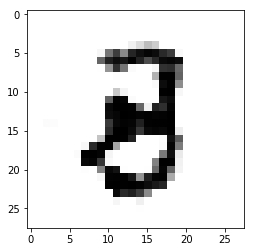

('Estimate:', array([[-3.7185545]], dtype=float32))


('Iteration:', 35800, 'at', datetime.datetime(2018, 3, 12, 13, 1, 13, 271370))


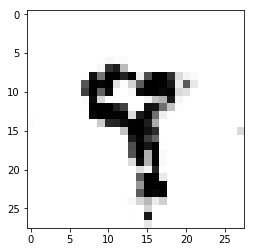

('Estimate:', array([[ 4.06120968]], dtype=float32))


('Iteration:', 35900, 'at', datetime.datetime(2018, 3, 12, 13, 1, 16, 661159))


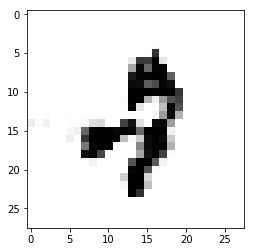

('Estimate:', array([[ 1.31985843]], dtype=float32))


('Iteration:', 36000, 'at', datetime.datetime(2018, 3, 12, 13, 1, 20, 73879))


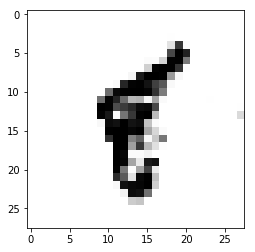

('Estimate:', array([[-11.70430756]], dtype=float32))


('Iteration:', 36100, 'at', datetime.datetime(2018, 3, 12, 13, 1, 23, 524350))


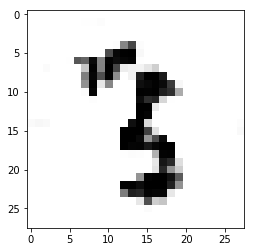

('Estimate:', array([[ 0.8131116]], dtype=float32))


('Iteration:', 36200, 'at', datetime.datetime(2018, 3, 12, 13, 1, 26, 959251))


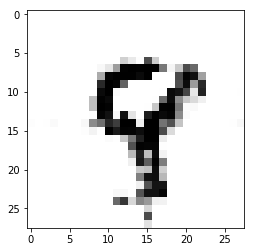

('Estimate:', array([[-5.53237915]], dtype=float32))


('Iteration:', 36300, 'at', datetime.datetime(2018, 3, 12, 13, 1, 30, 303524))


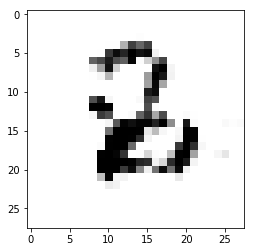

('Estimate:', array([[ 1.90596914]], dtype=float32))


('Iteration:', 36400, 'at', datetime.datetime(2018, 3, 12, 13, 1, 33, 743768))


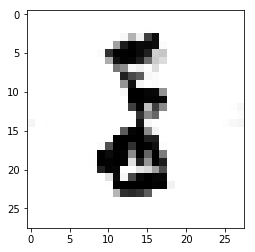

('Estimate:', array([[-7.70332527]], dtype=float32))


('Iteration:', 36500, 'at', datetime.datetime(2018, 3, 12, 13, 1, 37, 80283))


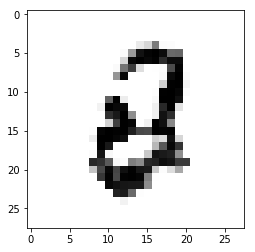

('Estimate:', array([[-2.34829903]], dtype=float32))


('Iteration:', 36600, 'at', datetime.datetime(2018, 3, 12, 13, 1, 40, 450446))


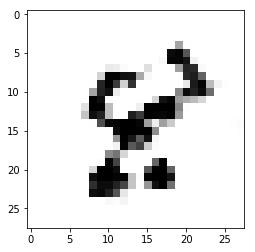

('Estimate:', array([[-9.66933823]], dtype=float32))


('Iteration:', 36700, 'at', datetime.datetime(2018, 3, 12, 13, 1, 43, 830241))


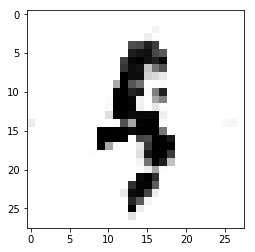

('Estimate:', array([[-3.66691017]], dtype=float32))


('Iteration:', 36800, 'at', datetime.datetime(2018, 3, 12, 13, 1, 47, 206591))


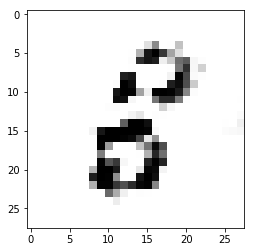

('Estimate:', array([[ 9.77118397]], dtype=float32))


('Iteration:', 36900, 'at', datetime.datetime(2018, 3, 12, 13, 1, 50, 592121))


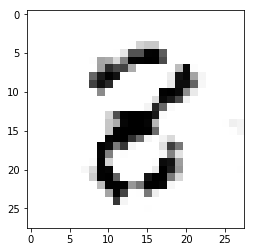

('Estimate:', array([[ 3.39933681]], dtype=float32))


('Iteration:', 37000, 'at', datetime.datetime(2018, 3, 12, 13, 1, 54, 64419))


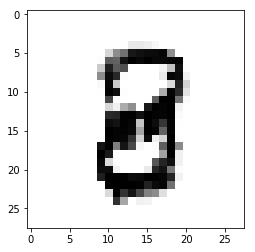

('Estimate:', array([[ 5.28964138]], dtype=float32))


('Iteration:', 37100, 'at', datetime.datetime(2018, 3, 12, 13, 1, 57, 479988))


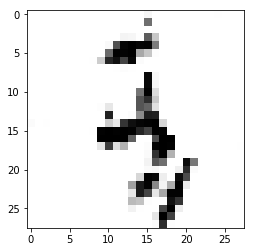

('Estimate:', array([[ 2.55424762]], dtype=float32))


('Iteration:', 37200, 'at', datetime.datetime(2018, 3, 12, 13, 2, 0, 832984))


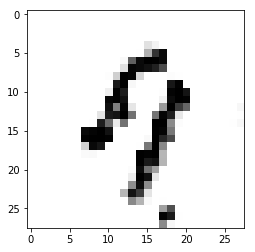

('Estimate:', array([[ 4.76642895]], dtype=float32))


('Iteration:', 37300, 'at', datetime.datetime(2018, 3, 12, 13, 2, 4, 222167))


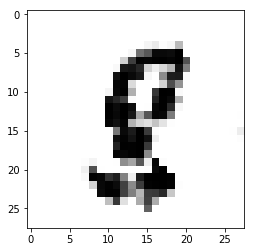

('Estimate:', array([[ 4.55111837]], dtype=float32))


('Iteration:', 37400, 'at', datetime.datetime(2018, 3, 12, 13, 2, 7, 597203))


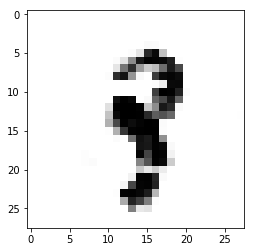

('Estimate:', array([[-4.46835136]], dtype=float32))


('Iteration:', 37500, 'at', datetime.datetime(2018, 3, 12, 13, 2, 11, 30532))


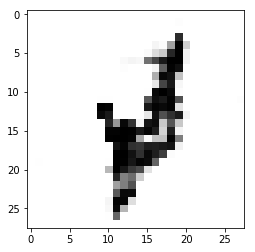

('Estimate:', array([[ 13.66264725]], dtype=float32))


('Iteration:', 37600, 'at', datetime.datetime(2018, 3, 12, 13, 2, 14, 402855))


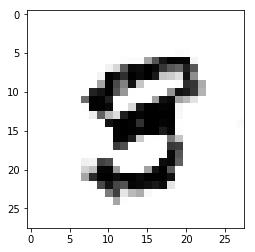

('Estimate:', array([[-3.262923]], dtype=float32))


('Iteration:', 37700, 'at', datetime.datetime(2018, 3, 12, 13, 2, 17, 801569))


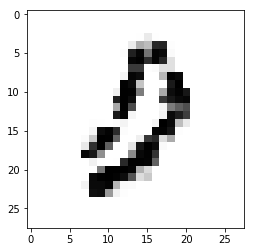

('Estimate:', array([[-8.41994476]], dtype=float32))


('Iteration:', 37800, 'at', datetime.datetime(2018, 3, 12, 13, 2, 21, 141019))


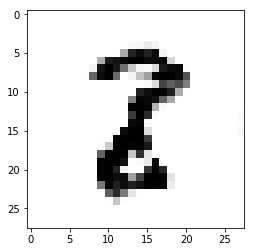

('Estimate:', array([[-0.41480431]], dtype=float32))


('Iteration:', 37900, 'at', datetime.datetime(2018, 3, 12, 13, 2, 24, 552452))


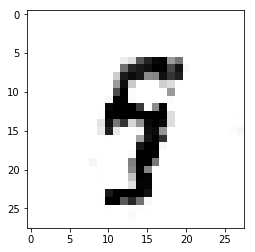

('Estimate:', array([[-0.49599412]], dtype=float32))


('Iteration:', 38000, 'at', datetime.datetime(2018, 3, 12, 13, 2, 27, 935291))


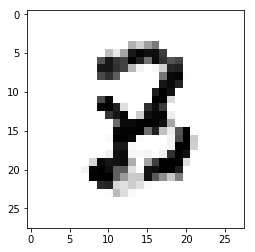

('Estimate:', array([[-8.57027817]], dtype=float32))


('Iteration:', 38100, 'at', datetime.datetime(2018, 3, 12, 13, 2, 31, 256530))


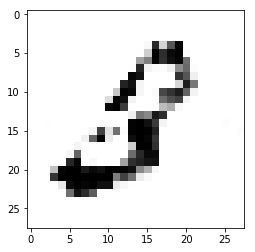

('Estimate:', array([[ 1.21741891]], dtype=float32))


('Iteration:', 38200, 'at', datetime.datetime(2018, 3, 12, 13, 2, 34, 697966))


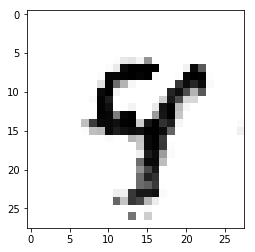

('Estimate:', array([[-2.07057953]], dtype=float32))


('Iteration:', 38300, 'at', datetime.datetime(2018, 3, 12, 13, 2, 38, 61797))


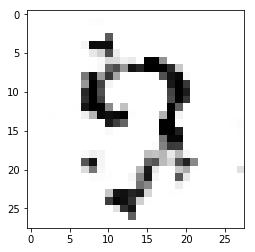

('Estimate:', array([[ 5.63555193]], dtype=float32))


('Iteration:', 38400, 'at', datetime.datetime(2018, 3, 12, 13, 2, 41, 526409))


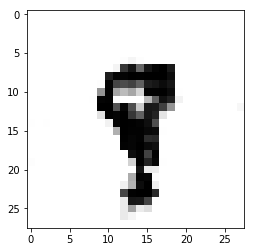

('Estimate:', array([[-1.35390067]], dtype=float32))


('Iteration:', 38500, 'at', datetime.datetime(2018, 3, 12, 13, 2, 44, 977224))


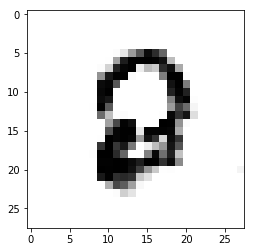

('Estimate:', array([[-7.04854679]], dtype=float32))


('Iteration:', 38600, 'at', datetime.datetime(2018, 3, 12, 13, 2, 48, 362744))


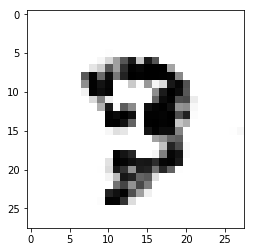

('Estimate:', array([[-4.88385582]], dtype=float32))


('Iteration:', 38700, 'at', datetime.datetime(2018, 3, 12, 13, 2, 51, 806305))


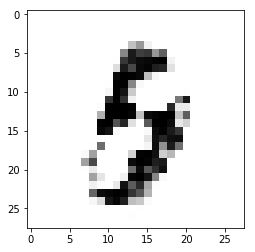

('Estimate:', array([[-4.87098122]], dtype=float32))


('Iteration:', 38800, 'at', datetime.datetime(2018, 3, 12, 13, 2, 55, 188909))


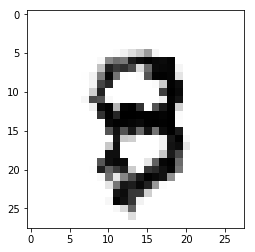

('Estimate:', array([[ 4.7093997]], dtype=float32))


('Iteration:', 38900, 'at', datetime.datetime(2018, 3, 12, 13, 2, 58, 569838))


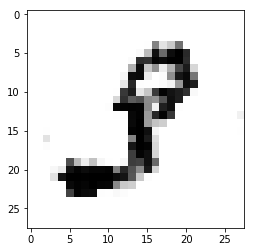

('Estimate:', array([[ 2.30201888]], dtype=float32))


('Iteration:', 39000, 'at', datetime.datetime(2018, 3, 12, 13, 3, 2, 41909))


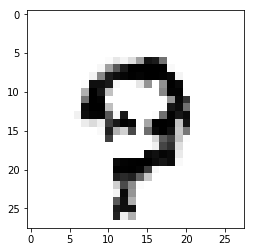

('Estimate:', array([[ 9.43858051]], dtype=float32))


('Iteration:', 39100, 'at', datetime.datetime(2018, 3, 12, 13, 3, 5, 409603))


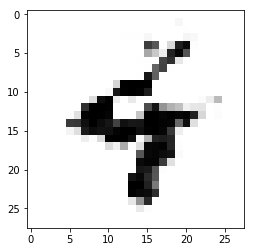

('Estimate:', array([[ 1.27354801]], dtype=float32))


('Iteration:', 39200, 'at', datetime.datetime(2018, 3, 12, 13, 3, 8, 815639))


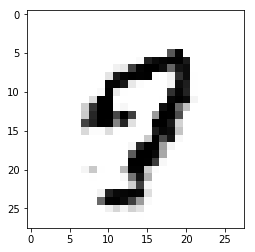

('Estimate:', array([[ 2.43536019]], dtype=float32))


('Iteration:', 39300, 'at', datetime.datetime(2018, 3, 12, 13, 3, 12, 209559))


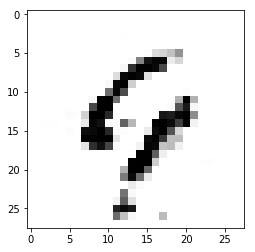

('Estimate:', array([[ 10.59982109]], dtype=float32))


('Iteration:', 39400, 'at', datetime.datetime(2018, 3, 12, 13, 3, 15, 629293))


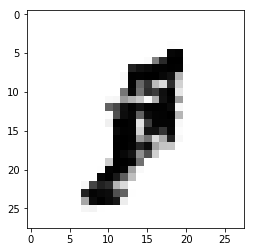

('Estimate:', array([[ 13.86335182]], dtype=float32))


('Iteration:', 39500, 'at', datetime.datetime(2018, 3, 12, 13, 3, 19, 39488))


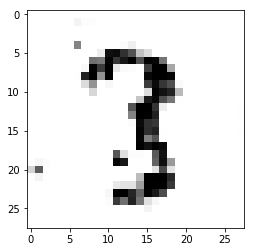

('Estimate:', array([[-7.67069387]], dtype=float32))


('Iteration:', 39600, 'at', datetime.datetime(2018, 3, 12, 13, 3, 22, 456955))


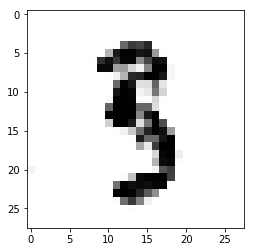

('Estimate:', array([[-9.51778221]], dtype=float32))


('Iteration:', 39700, 'at', datetime.datetime(2018, 3, 12, 13, 3, 25, 911169))


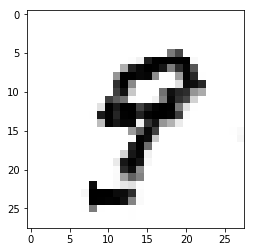

('Estimate:', array([[-6.63162327]], dtype=float32))


('Iteration:', 39800, 'at', datetime.datetime(2018, 3, 12, 13, 3, 29, 334406))


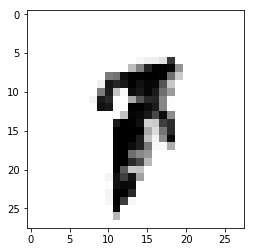

('Estimate:', array([[ 12.55443478]], dtype=float32))


('Iteration:', 39900, 'at', datetime.datetime(2018, 3, 12, 13, 3, 32, 808449))


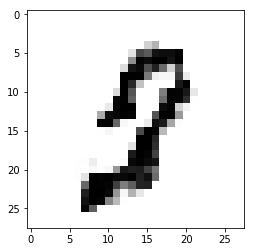

('Estimate:', array([[ 3.92080116]], dtype=float32))


('Iteration:', 40000, 'at', datetime.datetime(2018, 3, 12, 13, 3, 36, 250662))


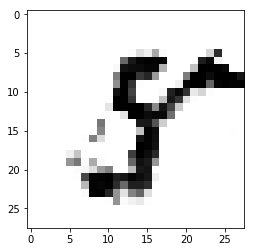

('Estimate:', array([[-5.68084478]], dtype=float32))


('Iteration:', 40100, 'at', datetime.datetime(2018, 3, 12, 13, 3, 39, 698448))


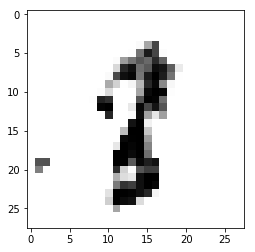

('Estimate:', array([[ 6.79296494]], dtype=float32))


('Iteration:', 40200, 'at', datetime.datetime(2018, 3, 12, 13, 3, 43, 158878))


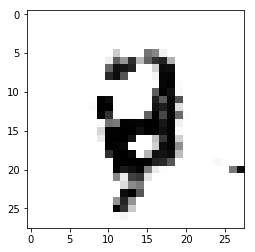

('Estimate:', array([[-0.62586468]], dtype=float32))


('Iteration:', 40300, 'at', datetime.datetime(2018, 3, 12, 13, 3, 46, 603120))


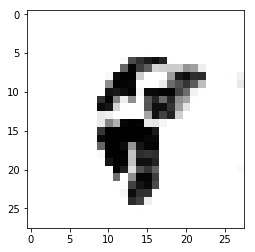

('Estimate:', array([[-14.3606596]], dtype=float32))


('Iteration:', 40400, 'at', datetime.datetime(2018, 3, 12, 13, 3, 50, 85666))


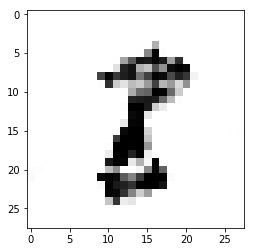

('Estimate:', array([[-3.03966427]], dtype=float32))


('Iteration:', 40500, 'at', datetime.datetime(2018, 3, 12, 13, 3, 53, 546355))


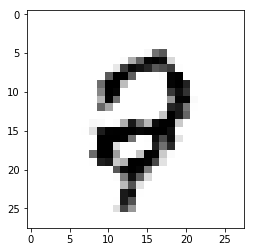

('Estimate:', array([[-2.75409651]], dtype=float32))


('Iteration:', 40600, 'at', datetime.datetime(2018, 3, 12, 13, 3, 57, 21624))


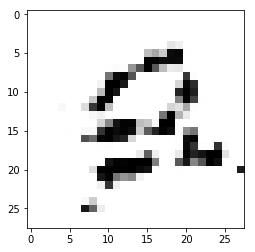

('Estimate:', array([[ 12.67783451]], dtype=float32))


('Iteration:', 40700, 'at', datetime.datetime(2018, 3, 12, 13, 4, 0, 530556))


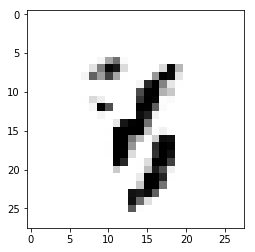

('Estimate:', array([[-13.15401745]], dtype=float32))


('Iteration:', 40800, 'at', datetime.datetime(2018, 3, 12, 13, 4, 4, 45076))


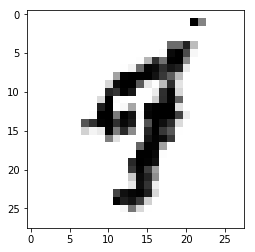

('Estimate:', array([[ 5.93746042]], dtype=float32))


('Iteration:', 40900, 'at', datetime.datetime(2018, 3, 12, 13, 4, 7, 482439))


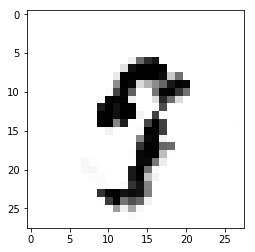

('Estimate:', array([[-15.34967804]], dtype=float32))


('Iteration:', 41000, 'at', datetime.datetime(2018, 3, 12, 13, 4, 10, 944414))


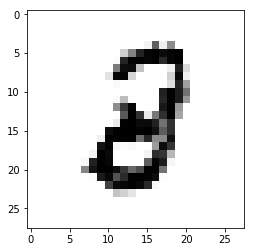

('Estimate:', array([[-13.06335068]], dtype=float32))


('Iteration:', 41100, 'at', datetime.datetime(2018, 3, 12, 13, 4, 14, 393787))


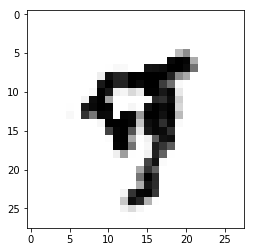

('Estimate:', array([[-6.7865591]], dtype=float32))


('Iteration:', 41200, 'at', datetime.datetime(2018, 3, 12, 13, 4, 17, 857707))


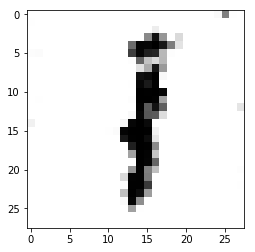

('Estimate:', array([[ 2.3142693]], dtype=float32))


('Iteration:', 41300, 'at', datetime.datetime(2018, 3, 12, 13, 4, 21, 370555))


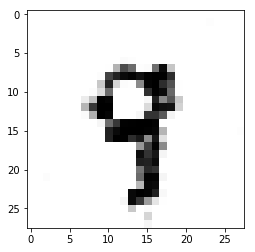

('Estimate:', array([[-3.45003438]], dtype=float32))


('Iteration:', 41400, 'at', datetime.datetime(2018, 3, 12, 13, 4, 24, 838446))


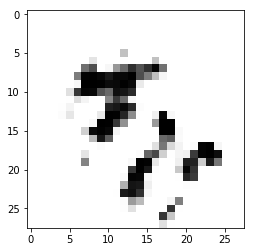

('Estimate:', array([[ 4.52242661]], dtype=float32))


('Iteration:', 41500, 'at', datetime.datetime(2018, 3, 12, 13, 4, 28, 393445))


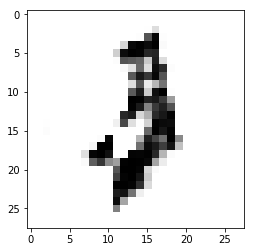

('Estimate:', array([[ 8.27487373]], dtype=float32))


('Iteration:', 41600, 'at', datetime.datetime(2018, 3, 12, 13, 4, 32, 969891))


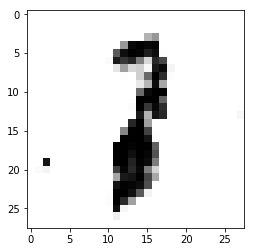

('Estimate:', array([[-2.97657561]], dtype=float32))


('Iteration:', 41700, 'at', datetime.datetime(2018, 3, 12, 13, 4, 36, 615886))


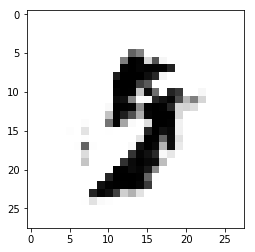

('Estimate:', array([[-14.58686256]], dtype=float32))


('Iteration:', 41800, 'at', datetime.datetime(2018, 3, 12, 13, 4, 40, 199782))


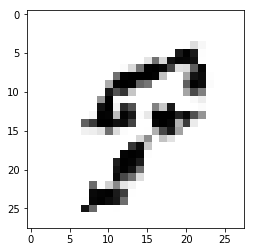

('Estimate:', array([[-14.60735798]], dtype=float32))


('Iteration:', 41900, 'at', datetime.datetime(2018, 3, 12, 13, 4, 43, 917719))


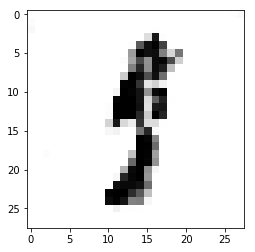

('Estimate:', array([[ 2.59328747]], dtype=float32))


('Iteration:', 42000, 'at', datetime.datetime(2018, 3, 12, 13, 4, 47, 421095))


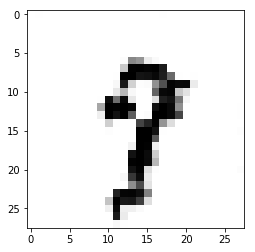

('Estimate:', array([[ 0.93860674]], dtype=float32))


('Iteration:', 42100, 'at', datetime.datetime(2018, 3, 12, 13, 4, 50, 999815))


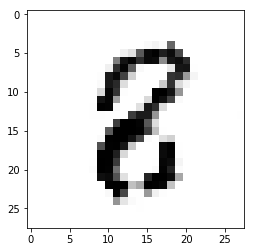

('Estimate:', array([[ 2.46308637]], dtype=float32))


('Iteration:', 42200, 'at', datetime.datetime(2018, 3, 12, 13, 4, 54, 575485))


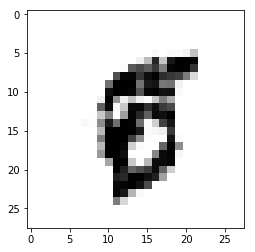

('Estimate:', array([[-7.75227356]], dtype=float32))


('Iteration:', 42300, 'at', datetime.datetime(2018, 3, 12, 13, 4, 58, 268252))


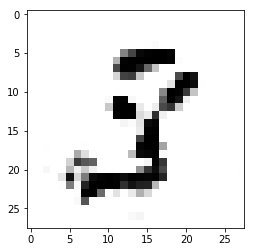

('Estimate:', array([[-2.04946685]], dtype=float32))


('Iteration:', 42400, 'at', datetime.datetime(2018, 3, 12, 13, 5, 1, 771082))


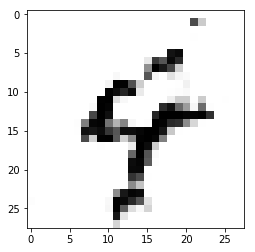

('Estimate:', array([[-16.51856232]], dtype=float32))


('Iteration:', 42500, 'at', datetime.datetime(2018, 3, 12, 13, 5, 5, 316430))


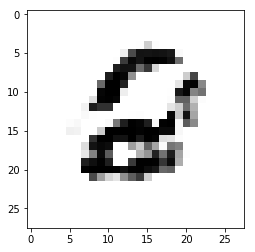

('Estimate:', array([[-6.30301285]], dtype=float32))


('Iteration:', 42600, 'at', datetime.datetime(2018, 3, 12, 13, 5, 9, 41054))


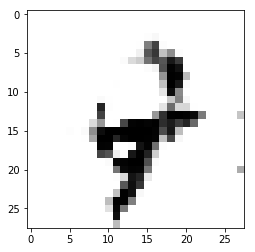

('Estimate:', array([[-5.59216166]], dtype=float32))


('Iteration:', 42700, 'at', datetime.datetime(2018, 3, 12, 13, 5, 12, 659940))


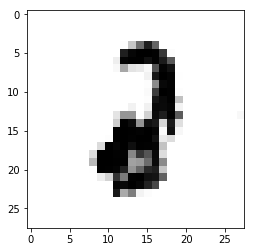

('Estimate:', array([[ 1.26769042]], dtype=float32))


('Iteration:', 42800, 'at', datetime.datetime(2018, 3, 12, 13, 5, 16, 260893))


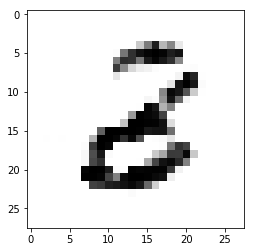

('Estimate:', array([[-1.42134607]], dtype=float32))


('Iteration:', 42900, 'at', datetime.datetime(2018, 3, 12, 13, 5, 20, 219941))


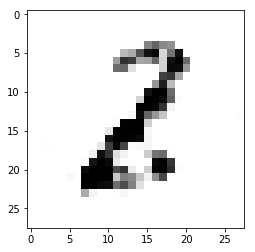

('Estimate:', array([[-11.93138313]], dtype=float32))


('Iteration:', 43000, 'at', datetime.datetime(2018, 3, 12, 13, 5, 24, 112418))


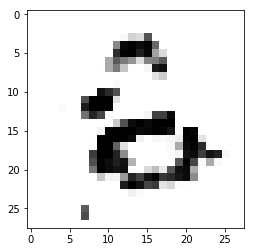

('Estimate:', array([[ 25.2696228]], dtype=float32))


('Iteration:', 43100, 'at', datetime.datetime(2018, 3, 12, 13, 5, 27, 959682))


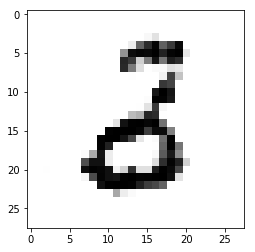

('Estimate:', array([[-18.41670609]], dtype=float32))


('Iteration:', 43200, 'at', datetime.datetime(2018, 3, 12, 13, 5, 31, 589170))


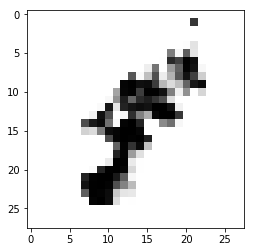

('Estimate:', array([[ 4.09515667]], dtype=float32))


('Iteration:', 43300, 'at', datetime.datetime(2018, 3, 12, 13, 5, 35, 189479))


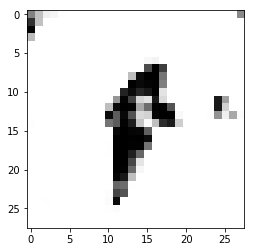

('Estimate:', array([[-12.48813725]], dtype=float32))


('Iteration:', 43400, 'at', datetime.datetime(2018, 3, 12, 13, 5, 38, 880319))


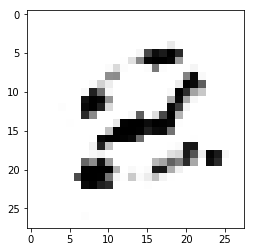

('Estimate:', array([[ 23.67951775]], dtype=float32))


('Iteration:', 43500, 'at', datetime.datetime(2018, 3, 12, 13, 5, 42, 442749))


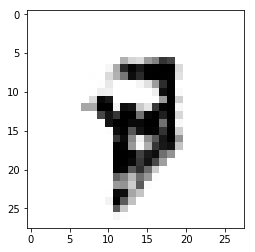

('Estimate:', array([[-0.06994831]], dtype=float32))


('Iteration:', 43600, 'at', datetime.datetime(2018, 3, 12, 13, 5, 46, 12836))


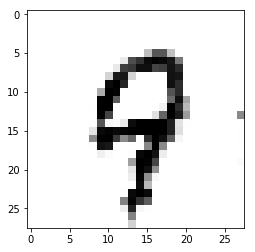

('Estimate:', array([[ 2.59165645]], dtype=float32))


('Iteration:', 43700, 'at', datetime.datetime(2018, 3, 12, 13, 5, 49, 714930))


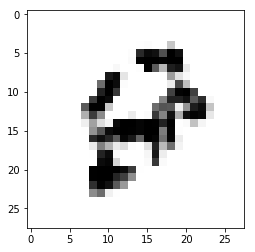

('Estimate:', array([[ 12.87818718]], dtype=float32))


('Iteration:', 43800, 'at', datetime.datetime(2018, 3, 12, 13, 5, 53, 387862))


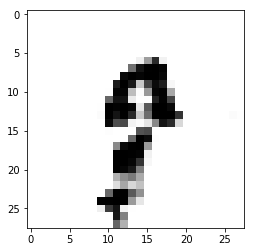

('Estimate:', array([[ 9.57697201]], dtype=float32))


('Iteration:', 43900, 'at', datetime.datetime(2018, 3, 12, 13, 5, 57, 37388))


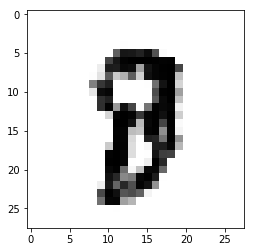

('Estimate:', array([[-7.29357386]], dtype=float32))


('Iteration:', 44000, 'at', datetime.datetime(2018, 3, 12, 13, 6, 0, 596616))


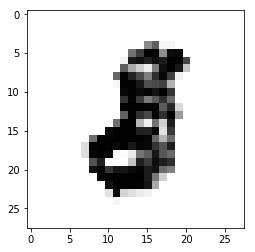

('Estimate:', array([[-8.188097]], dtype=float32))


('Iteration:', 44100, 'at', datetime.datetime(2018, 3, 12, 13, 6, 4, 311264))


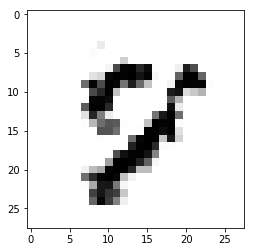

('Estimate:', array([[ 3.21904063]], dtype=float32))


('Iteration:', 44200, 'at', datetime.datetime(2018, 3, 12, 13, 6, 7, 969850))


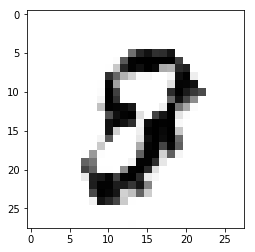

('Estimate:', array([[-0.86625582]], dtype=float32))


('Iteration:', 44300, 'at', datetime.datetime(2018, 3, 12, 13, 6, 11, 599663))


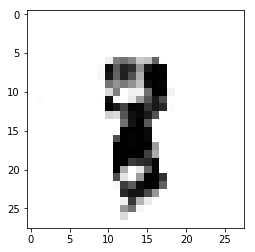

('Estimate:', array([[-0.75597066]], dtype=float32))


('Iteration:', 44400, 'at', datetime.datetime(2018, 3, 12, 13, 6, 15, 220299))


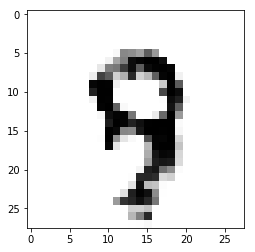

('Estimate:', array([[ 1.01940203]], dtype=float32))


('Iteration:', 44500, 'at', datetime.datetime(2018, 3, 12, 13, 6, 18, 866717))


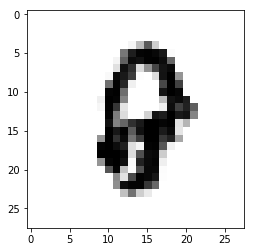

('Estimate:', array([[-5.74608421]], dtype=float32))


('Iteration:', 44600, 'at', datetime.datetime(2018, 3, 12, 13, 6, 22, 406862))


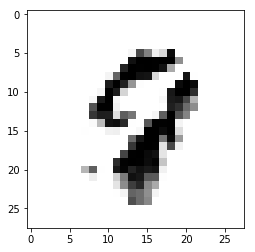

('Estimate:', array([[ 3.68930411]], dtype=float32))


('Iteration:', 44700, 'at', datetime.datetime(2018, 3, 12, 13, 6, 26, 40692))


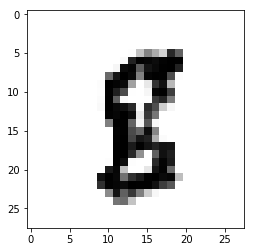

('Estimate:', array([[ 3.91518378]], dtype=float32))


('Iteration:', 44800, 'at', datetime.datetime(2018, 3, 12, 13, 6, 29, 602241))


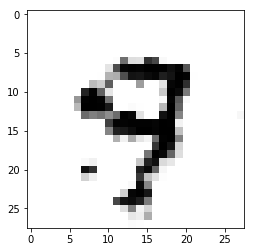

('Estimate:', array([[-2.69378281]], dtype=float32))


('Iteration:', 44900, 'at', datetime.datetime(2018, 3, 12, 13, 6, 33, 124204))


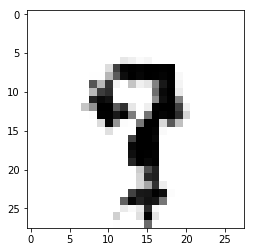

('Estimate:', array([[ 4.32289076]], dtype=float32))


('Iteration:', 45000, 'at', datetime.datetime(2018, 3, 12, 13, 6, 36, 733067))


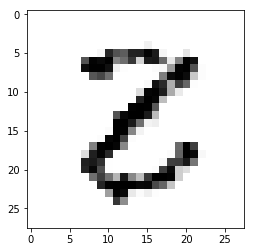

('Estimate:', array([[-4.01651287]], dtype=float32))


('Iteration:', 45100, 'at', datetime.datetime(2018, 3, 12, 13, 6, 40, 223873))


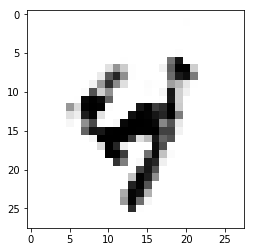

('Estimate:', array([[-2.19233489]], dtype=float32))


('Iteration:', 45200, 'at', datetime.datetime(2018, 3, 12, 13, 6, 43, 778014))


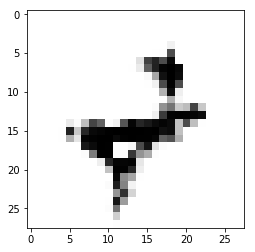

('Estimate:', array([[ 6.80661774]], dtype=float32))


('Iteration:', 45300, 'at', datetime.datetime(2018, 3, 12, 13, 6, 47, 341554))


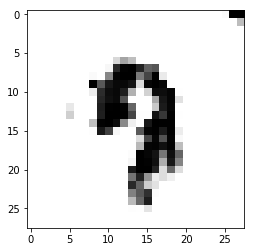

('Estimate:', array([[-2.22560763]], dtype=float32))


('Iteration:', 45400, 'at', datetime.datetime(2018, 3, 12, 13, 6, 50, 930916))


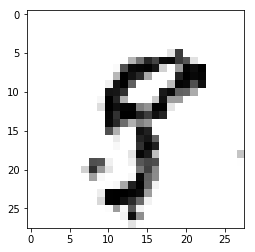

('Estimate:', array([[-7.6722188]], dtype=float32))


('Iteration:', 45500, 'at', datetime.datetime(2018, 3, 12, 13, 6, 54, 559283))


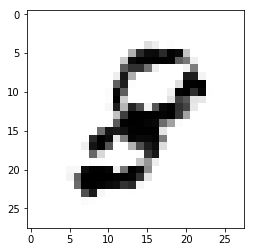

('Estimate:', array([[-6.17452574]], dtype=float32))


('Iteration:', 45600, 'at', datetime.datetime(2018, 3, 12, 13, 6, 58, 161222))


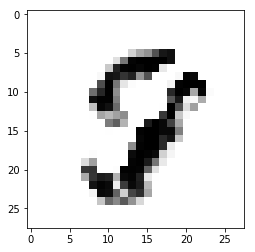

('Estimate:', array([[ 5.25945282]], dtype=float32))


('Iteration:', 45700, 'at', datetime.datetime(2018, 3, 12, 13, 7, 1, 661614))


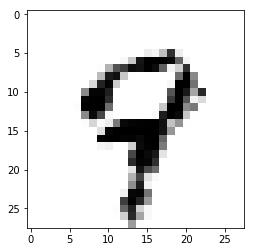

('Estimate:', array([[ 0.2456747]], dtype=float32))


('Iteration:', 45800, 'at', datetime.datetime(2018, 3, 12, 13, 7, 5, 282786))


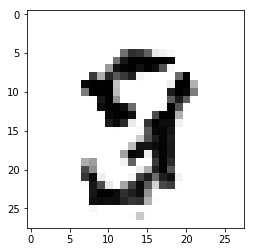

('Estimate:', array([[-5.42280865]], dtype=float32))


('Iteration:', 45900, 'at', datetime.datetime(2018, 3, 12, 13, 7, 8, 938931))


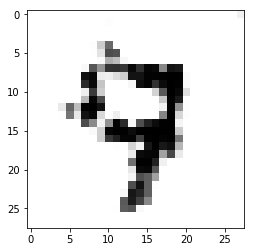

('Estimate:', array([[-2.84264851]], dtype=float32))


('Iteration:', 46000, 'at', datetime.datetime(2018, 3, 12, 13, 7, 12, 647825))


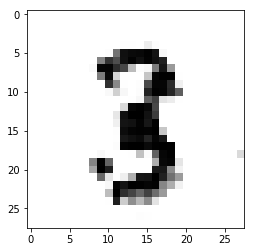

('Estimate:', array([[-9.34866047]], dtype=float32))


('Iteration:', 46100, 'at', datetime.datetime(2018, 3, 12, 13, 7, 16, 209941))


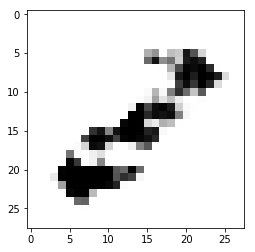

('Estimate:', array([[ 21.72971153]], dtype=float32))


('Iteration:', 46200, 'at', datetime.datetime(2018, 3, 12, 13, 7, 19, 754307))


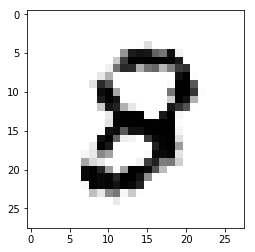

('Estimate:', array([[-0.22131424]], dtype=float32))


('Iteration:', 46300, 'at', datetime.datetime(2018, 3, 12, 13, 7, 23, 309816))


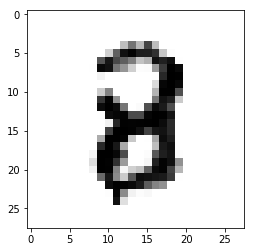

('Estimate:', array([[-8.33250427]], dtype=float32))


('Iteration:', 46400, 'at', datetime.datetime(2018, 3, 12, 13, 7, 26, 919334))


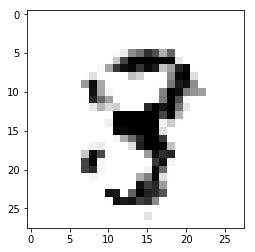

('Estimate:', array([[-1.06873417]], dtype=float32))


('Iteration:', 46500, 'at', datetime.datetime(2018, 3, 12, 13, 7, 30, 506926))


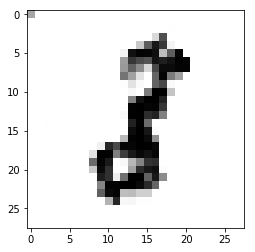

('Estimate:', array([[-8.20424652]], dtype=float32))


('Iteration:', 46600, 'at', datetime.datetime(2018, 3, 12, 13, 7, 34, 124977))


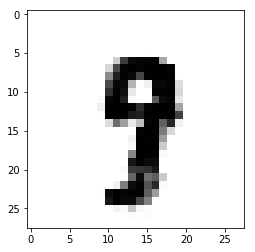

('Estimate:', array([[ 16.31488228]], dtype=float32))


('Iteration:', 46700, 'at', datetime.datetime(2018, 3, 12, 13, 7, 37, 749763))


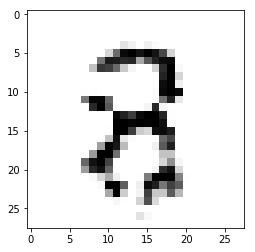

('Estimate:', array([[-9.65464783]], dtype=float32))


('Iteration:', 46800, 'at', datetime.datetime(2018, 3, 12, 13, 7, 41, 318281))


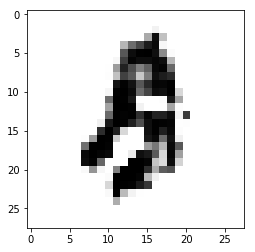

('Estimate:', array([[ 0.68570799]], dtype=float32))


('Iteration:', 46900, 'at', datetime.datetime(2018, 3, 12, 13, 7, 44, 933475))


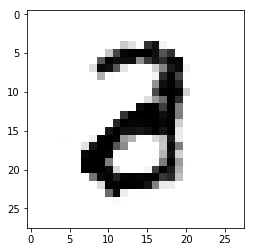

('Estimate:', array([[ 8.62268162]], dtype=float32))


('Iteration:', 47000, 'at', datetime.datetime(2018, 3, 12, 13, 7, 48, 531579))


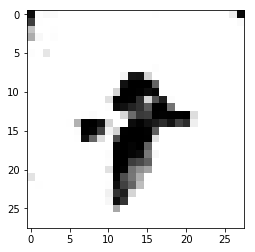

('Estimate:', array([[-24.89100456]], dtype=float32))


('Iteration:', 47100, 'at', datetime.datetime(2018, 3, 12, 13, 7, 52, 139053))


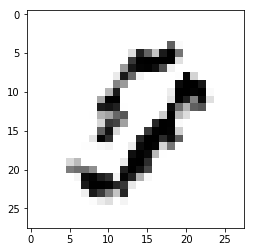

('Estimate:', array([[ 6.90321827]], dtype=float32))


('Iteration:', 47200, 'at', datetime.datetime(2018, 3, 12, 13, 7, 55, 733139))


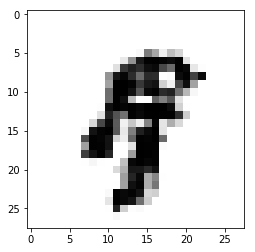

('Estimate:', array([[ 1.19348812]], dtype=float32))


('Iteration:', 47300, 'at', datetime.datetime(2018, 3, 12, 13, 7, 59, 428128))


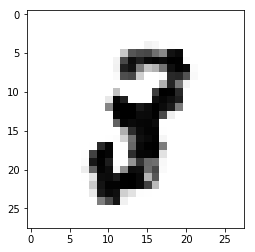

('Estimate:', array([[-0.82209957]], dtype=float32))


('Iteration:', 47400, 'at', datetime.datetime(2018, 3, 12, 13, 8, 3, 59884))


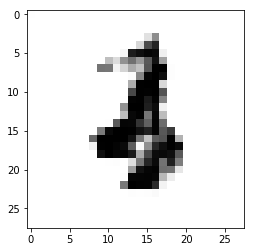

('Estimate:', array([[ 3.04271007]], dtype=float32))


('Iteration:', 47500, 'at', datetime.datetime(2018, 3, 12, 13, 8, 6, 688015))


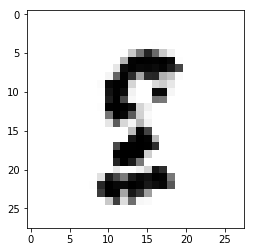

('Estimate:', array([[-16.65765953]], dtype=float32))


('Iteration:', 47600, 'at', datetime.datetime(2018, 3, 12, 13, 8, 10, 265947))


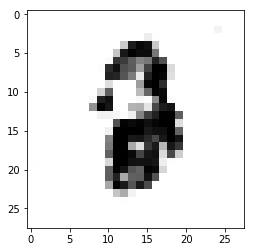

('Estimate:', array([[-23.58198166]], dtype=float32))


('Iteration:', 47700, 'at', datetime.datetime(2018, 3, 12, 13, 8, 13, 894416))


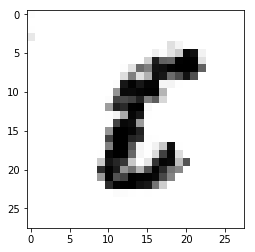

('Estimate:', array([[-2.70847464]], dtype=float32))


('Iteration:', 47800, 'at', datetime.datetime(2018, 3, 12, 13, 8, 17, 496879))


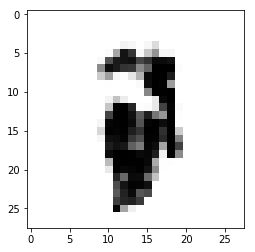

('Estimate:', array([[-11.81507969]], dtype=float32))


('Iteration:', 47900, 'at', datetime.datetime(2018, 3, 12, 13, 8, 21, 134947))


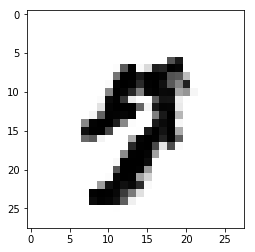

('Estimate:', array([[-1.1257056]], dtype=float32))


('Iteration:', 48000, 'at', datetime.datetime(2018, 3, 12, 13, 8, 24, 771823))


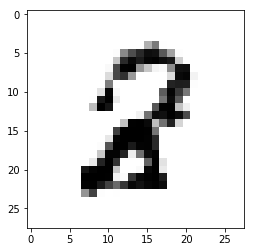

('Estimate:', array([[ 1.02254558]], dtype=float32))


('Iteration:', 48100, 'at', datetime.datetime(2018, 3, 12, 13, 8, 28, 434318))


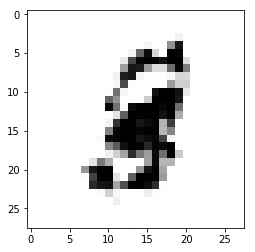

('Estimate:', array([[-9.64405346]], dtype=float32))


('Iteration:', 48200, 'at', datetime.datetime(2018, 3, 12, 13, 8, 32, 36519))


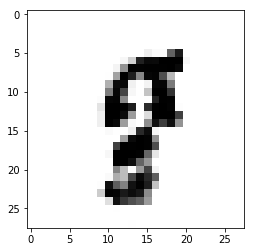

('Estimate:', array([[ 6.43454552]], dtype=float32))


('Iteration:', 48300, 'at', datetime.datetime(2018, 3, 12, 13, 8, 35, 622007))


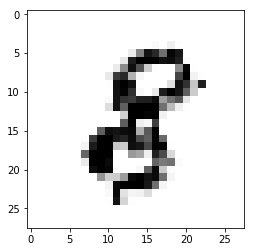

('Estimate:', array([[-9.12811947]], dtype=float32))


('Iteration:', 48400, 'at', datetime.datetime(2018, 3, 12, 13, 8, 40, 53421))


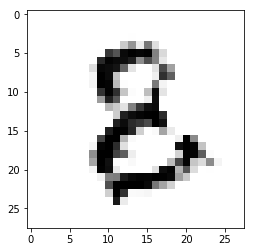

('Estimate:', array([[ 22.42781448]], dtype=float32))


('Iteration:', 48500, 'at', datetime.datetime(2018, 3, 12, 13, 8, 43, 768897))


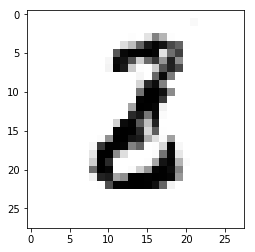

('Estimate:', array([[ 1.22562921]], dtype=float32))


('Iteration:', 48600, 'at', datetime.datetime(2018, 3, 12, 13, 8, 47, 437640))


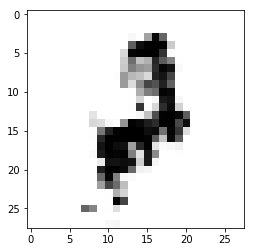

('Estimate:', array([[-3.199512]], dtype=float32))


('Iteration:', 48700, 'at', datetime.datetime(2018, 3, 12, 13, 8, 51, 137592))


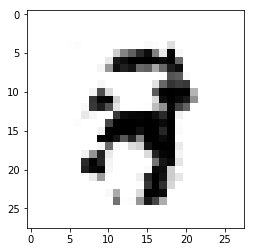

('Estimate:', array([[ 2.76976538]], dtype=float32))


('Iteration:', 48800, 'at', datetime.datetime(2018, 3, 12, 13, 8, 54, 872252))


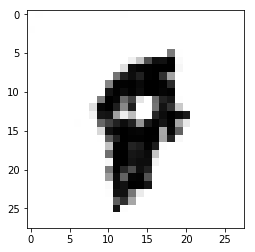

('Estimate:', array([[ 0.30172238]], dtype=float32))


('Iteration:', 48900, 'at', datetime.datetime(2018, 3, 12, 13, 8, 58, 605334))


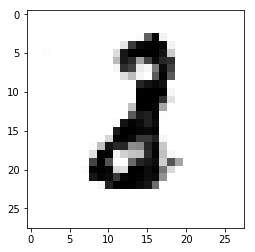

('Estimate:', array([[ 2.83031058]], dtype=float32))


('Iteration:', 49000, 'at', datetime.datetime(2018, 3, 12, 13, 9, 2, 288027))


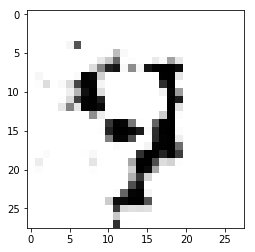

('Estimate:', array([[ 11.08784199]], dtype=float32))


('Iteration:', 49100, 'at', datetime.datetime(2018, 3, 12, 13, 9, 5, 987424))


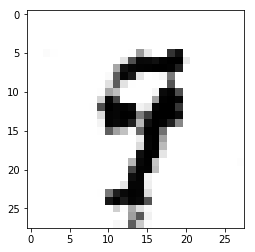

('Estimate:', array([[-1.56574619]], dtype=float32))


('Iteration:', 49200, 'at', datetime.datetime(2018, 3, 12, 13, 9, 9, 766708))


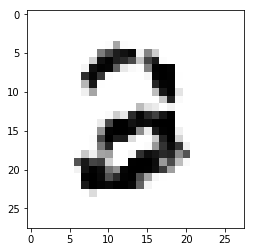

('Estimate:', array([[ 2.21114564]], dtype=float32))


('Iteration:', 49300, 'at', datetime.datetime(2018, 3, 12, 13, 9, 13, 425741))


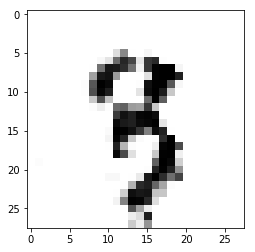

('Estimate:', array([[-12.69753456]], dtype=float32))


('Iteration:', 49400, 'at', datetime.datetime(2018, 3, 12, 13, 9, 17, 135447))


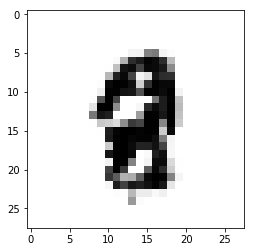

('Estimate:', array([[-0.61690825]], dtype=float32))


('Iteration:', 49500, 'at', datetime.datetime(2018, 3, 12, 13, 9, 20, 803037))


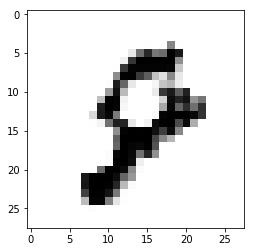

('Estimate:', array([[ 4.12702847]], dtype=float32))


('Iteration:', 49600, 'at', datetime.datetime(2018, 3, 12, 13, 9, 24, 495084))


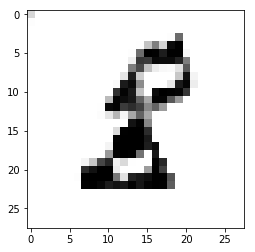

('Estimate:', array([[ 8.21119404]], dtype=float32))


('Iteration:', 49700, 'at', datetime.datetime(2018, 3, 12, 13, 9, 29, 512414))


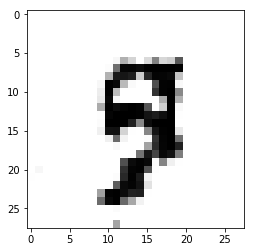

('Estimate:', array([[-5.21020365]], dtype=float32))


('Iteration:', 49800, 'at', datetime.datetime(2018, 3, 12, 13, 9, 38, 627562))


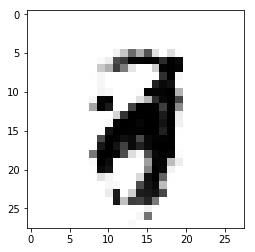

('Estimate:', array([[-9.24789047]], dtype=float32))


('Iteration:', 49900, 'at', datetime.datetime(2018, 3, 12, 13, 9, 42, 302834))


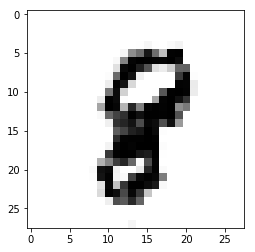

('Estimate:', array([[ 9.98970509]], dtype=float32))


('Iteration:', 50000, 'at', datetime.datetime(2018, 3, 12, 13, 9, 45, 993138))


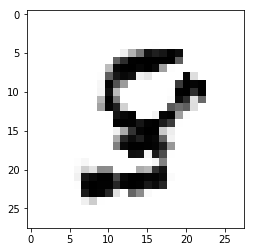

('Estimate:', array([[-11.64490414]], dtype=float32))


('Iteration:', 50100, 'at', datetime.datetime(2018, 3, 12, 13, 9, 49, 641154))


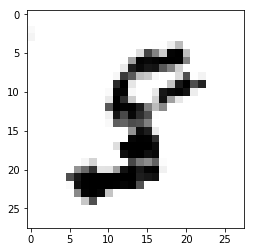

('Estimate:', array([[ 21.62867928]], dtype=float32))


('Iteration:', 50200, 'at', datetime.datetime(2018, 3, 12, 13, 9, 53, 291221))


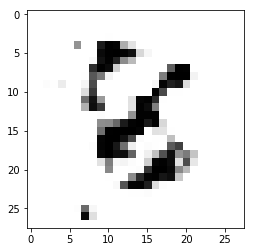

('Estimate:', array([[ 11.91764069]], dtype=float32))


('Iteration:', 50300, 'at', datetime.datetime(2018, 3, 12, 13, 9, 57, 33670))


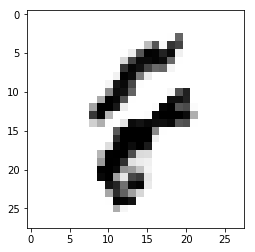

('Estimate:', array([[-8.64030743]], dtype=float32))


('Iteration:', 50400, 'at', datetime.datetime(2018, 3, 12, 13, 10, 0, 659005))


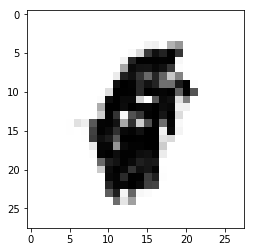

('Estimate:', array([[-12.9991951]], dtype=float32))


('Iteration:', 50500, 'at', datetime.datetime(2018, 3, 12, 13, 10, 4, 310656))


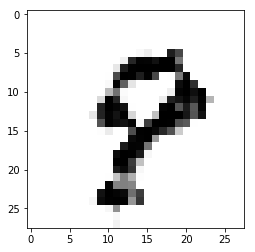

('Estimate:', array([[ 6.52788496]], dtype=float32))


('Iteration:', 50600, 'at', datetime.datetime(2018, 3, 12, 13, 10, 7, 986717))


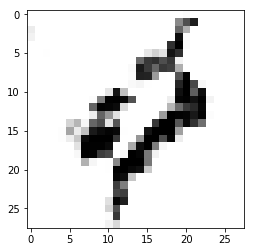

('Estimate:', array([[-17.78617096]], dtype=float32))


('Iteration:', 50700, 'at', datetime.datetime(2018, 3, 12, 13, 10, 11, 719927))


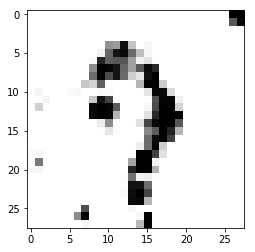

('Estimate:', array([[-0.27054471]], dtype=float32))


('Iteration:', 50800, 'at', datetime.datetime(2018, 3, 12, 13, 10, 15, 413258))


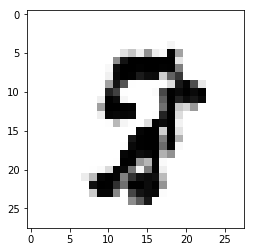

('Estimate:', array([[ 3.48054433]], dtype=float32))


('Iteration:', 50900, 'at', datetime.datetime(2018, 3, 12, 13, 10, 19, 61961))


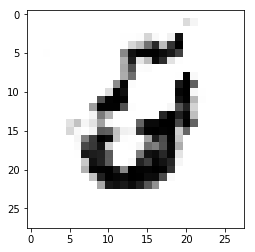

('Estimate:', array([[ 3.36576009]], dtype=float32))


('Iteration:', 51000, 'at', datetime.datetime(2018, 3, 12, 13, 10, 22, 761543))


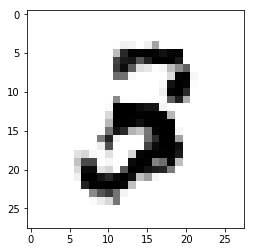

('Estimate:', array([[-2.59577847]], dtype=float32))


('Iteration:', 51100, 'at', datetime.datetime(2018, 3, 12, 13, 10, 26, 391129))


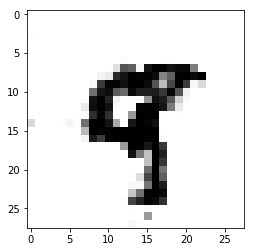

('Estimate:', array([[ 5.91108322]], dtype=float32))


('Iteration:', 51200, 'at', datetime.datetime(2018, 3, 12, 13, 10, 30, 738708))


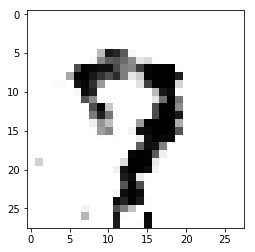

('Estimate:', array([[-8.96558762]], dtype=float32))


('Iteration:', 51300, 'at', datetime.datetime(2018, 3, 12, 13, 10, 41, 18966))


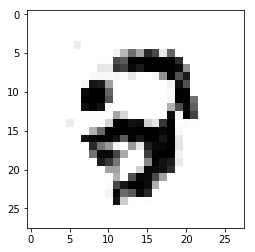

('Estimate:', array([[ 2.23861814]], dtype=float32))


('Iteration:', 51400, 'at', datetime.datetime(2018, 3, 12, 13, 10, 49, 834073))


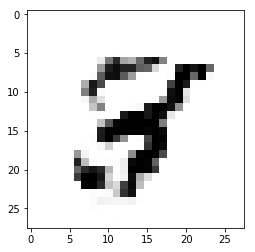

('Estimate:', array([[-11.96352386]], dtype=float32))


('Iteration:', 51500, 'at', datetime.datetime(2018, 3, 12, 13, 10, 56, 277921))


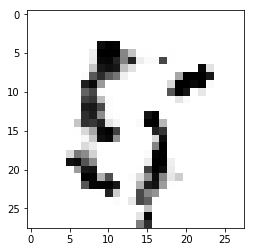

('Estimate:', array([[ 85.01361847]], dtype=float32))


('Iteration:', 51600, 'at', datetime.datetime(2018, 3, 12, 13, 11, 0, 74998))


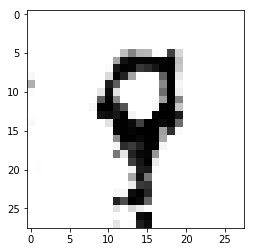

('Estimate:', array([[-3.83769107]], dtype=float32))


('Iteration:', 51700, 'at', datetime.datetime(2018, 3, 12, 13, 11, 5, 77464))


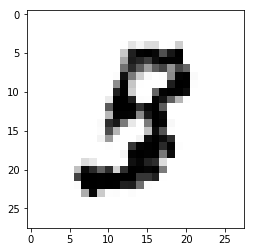

('Estimate:', array([[-7.94471025]], dtype=float32))


('Iteration:', 51800, 'at', datetime.datetime(2018, 3, 12, 13, 11, 10, 248793))


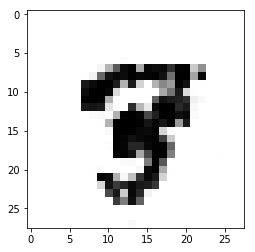

('Estimate:', array([[-0.97099566]], dtype=float32))


('Iteration:', 51900, 'at', datetime.datetime(2018, 3, 12, 13, 11, 19, 879144))


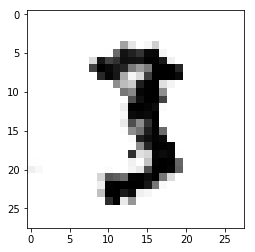

('Estimate:', array([[ 1.44379413]], dtype=float32))


('Iteration:', 52000, 'at', datetime.datetime(2018, 3, 12, 13, 11, 26, 89315))


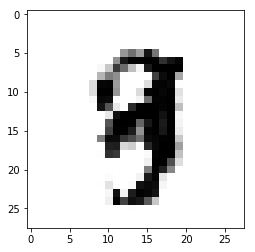

('Estimate:', array([[-6.88148212]], dtype=float32))


('Iteration:', 52100, 'at', datetime.datetime(2018, 3, 12, 13, 11, 30, 95515))


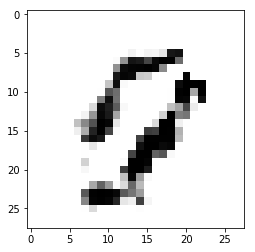

('Estimate:', array([[ 0.33505261]], dtype=float32))


('Iteration:', 52200, 'at', datetime.datetime(2018, 3, 12, 13, 11, 33, 948175))


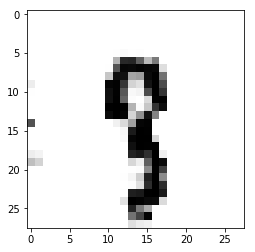

('Estimate:', array([[ 16.87832451]], dtype=float32))


('Iteration:', 52300, 'at', datetime.datetime(2018, 3, 12, 13, 11, 38, 838218))


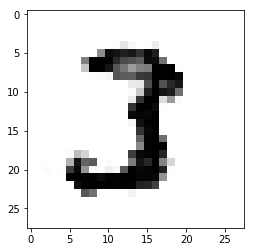

('Estimate:', array([[ 6.66998816]], dtype=float32))


('Iteration:', 52400, 'at', datetime.datetime(2018, 3, 12, 13, 11, 42, 901011))


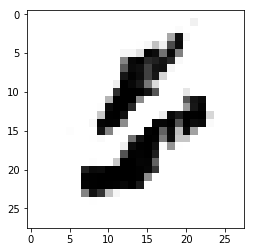

('Estimate:', array([[ 6.29101324]], dtype=float32))


('Iteration:', 52500, 'at', datetime.datetime(2018, 3, 12, 13, 11, 47, 100709))


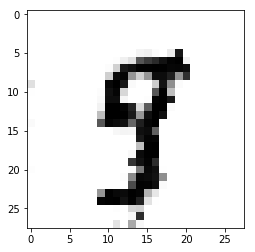

('Estimate:', array([[-15.64953041]], dtype=float32))


('Iteration:', 52600, 'at', datetime.datetime(2018, 3, 12, 13, 11, 50, 829488))


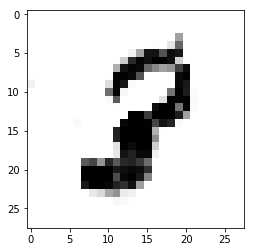

('Estimate:', array([[-6.44282293]], dtype=float32))


('Iteration:', 52700, 'at', datetime.datetime(2018, 3, 12, 13, 11, 54, 528892))


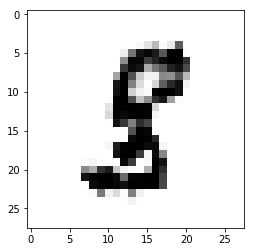

('Estimate:', array([[-13.57162952]], dtype=float32))


('Iteration:', 52800, 'at', datetime.datetime(2018, 3, 12, 13, 11, 58, 225108))


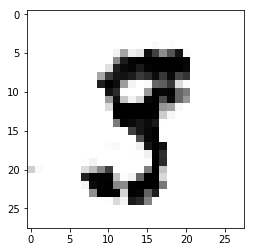

('Estimate:', array([[-13.20367241]], dtype=float32))


('Iteration:', 52900, 'at', datetime.datetime(2018, 3, 12, 13, 12, 4, 67177))


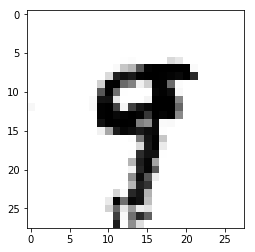

('Estimate:', array([[-1.02395856]], dtype=float32))


('Iteration:', 53000, 'at', datetime.datetime(2018, 3, 12, 13, 12, 8, 299595))


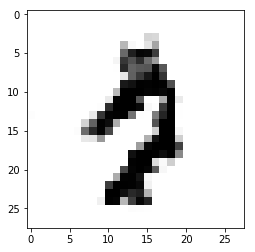

('Estimate:', array([[-0.1051762]], dtype=float32))


('Iteration:', 53100, 'at', datetime.datetime(2018, 3, 12, 13, 12, 12, 471877))


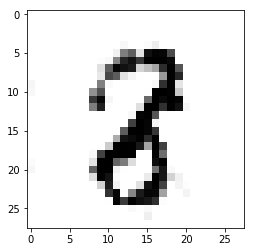

('Estimate:', array([[-1.60824418]], dtype=float32))


('Iteration:', 53200, 'at', datetime.datetime(2018, 3, 12, 13, 12, 16, 550727))


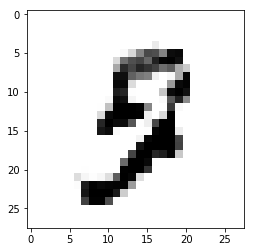

('Estimate:', array([[ 15.77418423]], dtype=float32))


('Iteration:', 53300, 'at', datetime.datetime(2018, 3, 12, 13, 12, 20, 236751))


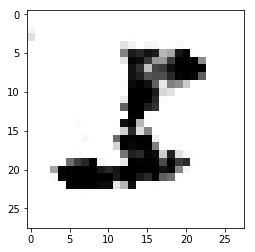

('Estimate:', array([[ 21.6580677]], dtype=float32))


('Iteration:', 53400, 'at', datetime.datetime(2018, 3, 12, 13, 12, 24, 257770))


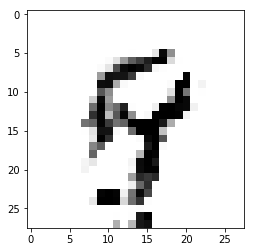

('Estimate:', array([[-6.12493801]], dtype=float32))


('Iteration:', 53500, 'at', datetime.datetime(2018, 3, 12, 13, 12, 28, 477268))


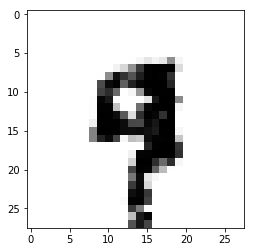

('Estimate:', array([[ 8.18739128]], dtype=float32))


('Iteration:', 53600, 'at', datetime.datetime(2018, 3, 12, 13, 12, 32, 935872))


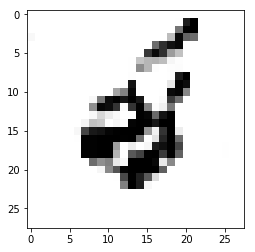

('Estimate:', array([[-7.10726452]], dtype=float32))


('Iteration:', 53700, 'at', datetime.datetime(2018, 3, 12, 13, 12, 41, 306164))


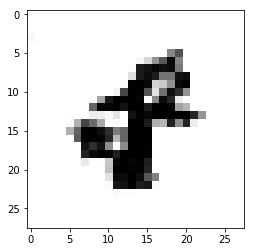

('Estimate:', array([[-0.90063989]], dtype=float32))


('Iteration:', 53800, 'at', datetime.datetime(2018, 3, 12, 13, 12, 51, 303755))


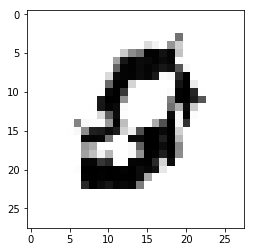

('Estimate:', array([[-6.20711422]], dtype=float32))


('Iteration:', 53900, 'at', datetime.datetime(2018, 3, 12, 13, 13, 0, 589554))


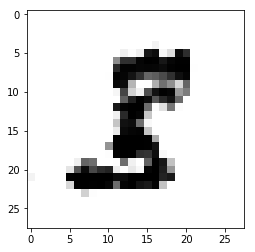

('Estimate:', array([[-1.24606073]], dtype=float32))


('Iteration:', 54000, 'at', datetime.datetime(2018, 3, 12, 13, 13, 10, 681930))


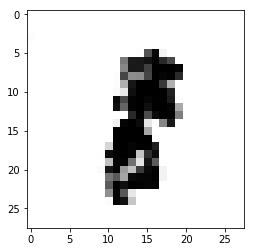

('Estimate:', array([[ 6.54223776]], dtype=float32))


('Iteration:', 54100, 'at', datetime.datetime(2018, 3, 12, 13, 13, 21, 213278))


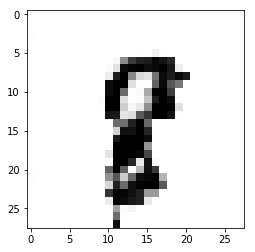

('Estimate:', array([[-19.15588188]], dtype=float32))


('Iteration:', 54200, 'at', datetime.datetime(2018, 3, 12, 13, 13, 31, 887467))


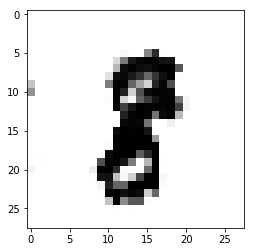

('Estimate:', array([[-5.34048223]], dtype=float32))


('Iteration:', 54300, 'at', datetime.datetime(2018, 3, 12, 13, 13, 41, 817024))


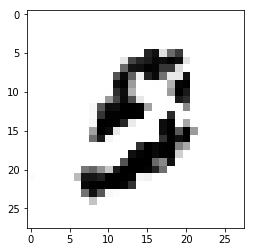

('Estimate:', array([[-9.08418751]], dtype=float32))


('Iteration:', 54400, 'at', datetime.datetime(2018, 3, 12, 13, 13, 52, 37952))


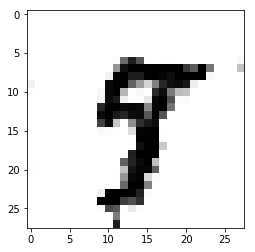

('Estimate:', array([[-2.62289524]], dtype=float32))


('Iteration:', 54500, 'at', datetime.datetime(2018, 3, 12, 13, 14, 1, 899064))


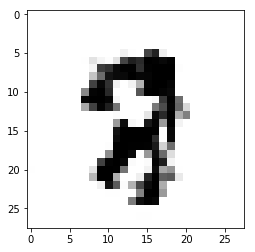

('Estimate:', array([[-19.71408844]], dtype=float32))


('Iteration:', 54600, 'at', datetime.datetime(2018, 3, 12, 13, 14, 11, 116557))


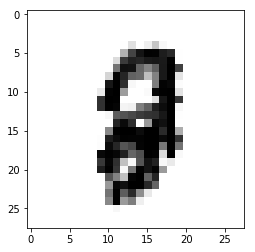

('Estimate:', array([[-3.66814733]], dtype=float32))


('Iteration:', 54700, 'at', datetime.datetime(2018, 3, 12, 13, 14, 20, 616469))


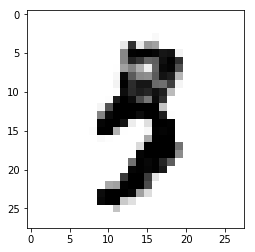

('Estimate:', array([[ 12.606493]], dtype=float32))


('Iteration:', 54800, 'at', datetime.datetime(2018, 3, 12, 13, 14, 24, 943935))


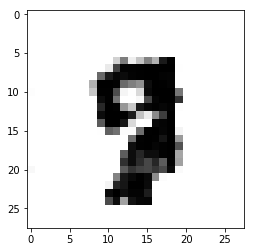

('Estimate:', array([[-4.82400799]], dtype=float32))


('Iteration:', 54900, 'at', datetime.datetime(2018, 3, 12, 13, 14, 28, 833762))


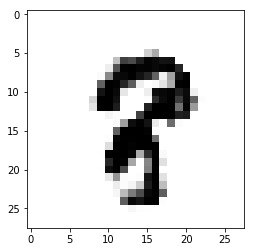

('Estimate:', array([[-4.06899118]], dtype=float32))


('Iteration:', 55000, 'at', datetime.datetime(2018, 3, 12, 13, 14, 32, 608127))


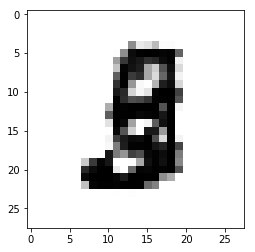

('Estimate:', array([[ 16.83805847]], dtype=float32))


('Iteration:', 55100, 'at', datetime.datetime(2018, 3, 12, 13, 14, 36, 380155))


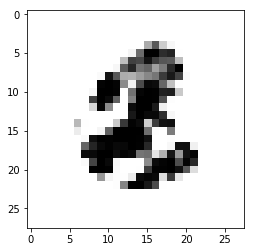

('Estimate:', array([[-6.15186071]], dtype=float32))


('Iteration:', 55200, 'at', datetime.datetime(2018, 3, 12, 13, 14, 40, 97128))


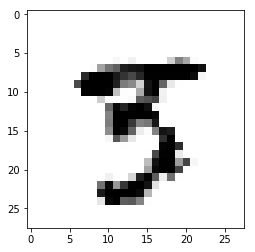

('Estimate:', array([[ 3.19465566]], dtype=float32))


('Iteration:', 55300, 'at', datetime.datetime(2018, 3, 12, 13, 14, 43, 849447))


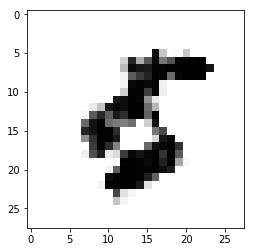

('Estimate:', array([[ 27.54985046]], dtype=float32))


('Iteration:', 55400, 'at', datetime.datetime(2018, 3, 12, 13, 14, 47, 753762))


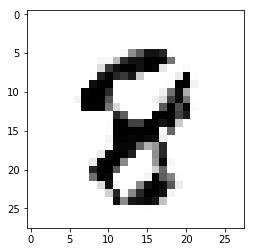

('Estimate:', array([[ 12.95948601]], dtype=float32))


('Iteration:', 55500, 'at', datetime.datetime(2018, 3, 12, 13, 14, 51, 530298))


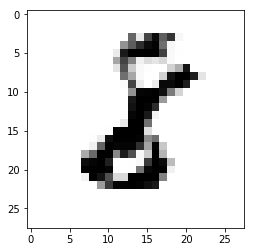

('Estimate:', array([[ 3.23034453]], dtype=float32))


('Iteration:', 55600, 'at', datetime.datetime(2018, 3, 12, 13, 14, 55, 281740))


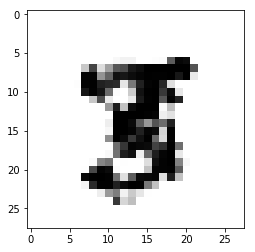

('Estimate:', array([[-0.16024448]], dtype=float32))


('Iteration:', 55700, 'at', datetime.datetime(2018, 3, 12, 13, 14, 59, 226822))


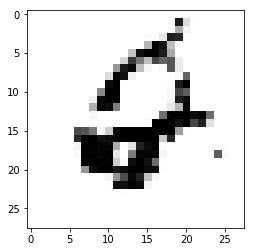

('Estimate:', array([[ 12.35241699]], dtype=float32))


('Iteration:', 55800, 'at', datetime.datetime(2018, 3, 12, 13, 15, 3, 48780))


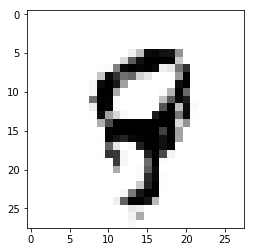

('Estimate:', array([[-20.003479]], dtype=float32))


('Iteration:', 55900, 'at', datetime.datetime(2018, 3, 12, 13, 15, 6, 828618))


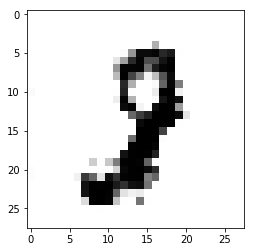

('Estimate:', array([[ 16.56087112]], dtype=float32))


('Iteration:', 56000, 'at', datetime.datetime(2018, 3, 12, 13, 15, 10, 563485))


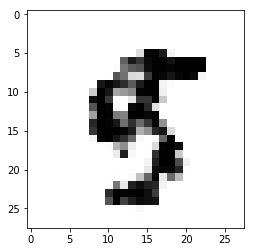

('Estimate:', array([[-4.90268517]], dtype=float32))


('Iteration:', 56100, 'at', datetime.datetime(2018, 3, 12, 13, 15, 15, 173715))


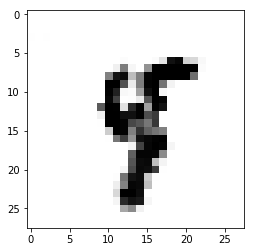

('Estimate:', array([[-23.3415947]], dtype=float32))


('Iteration:', 56200, 'at', datetime.datetime(2018, 3, 12, 13, 15, 19, 145023))


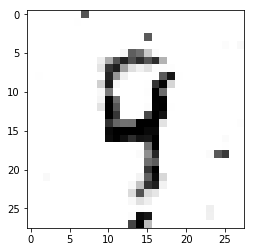

('Estimate:', array([[-29.51597595]], dtype=float32))


('Iteration:', 56300, 'at', datetime.datetime(2018, 3, 12, 13, 15, 23, 44490))


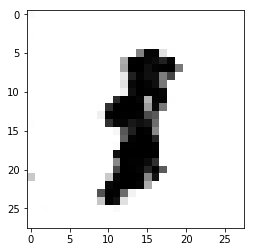

('Estimate:', array([[ 4.20877266]], dtype=float32))


('Iteration:', 56400, 'at', datetime.datetime(2018, 3, 12, 13, 15, 26, 965768))


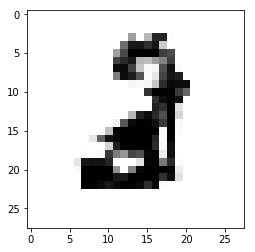

('Estimate:', array([[-0.37136674]], dtype=float32))


('Iteration:', 56500, 'at', datetime.datetime(2018, 3, 12, 13, 15, 30, 851123))


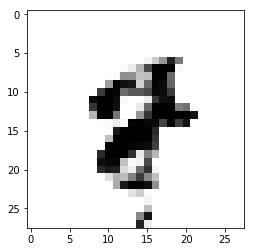

('Estimate:', array([[ 5.20385408]], dtype=float32))


('Iteration:', 56600, 'at', datetime.datetime(2018, 3, 12, 13, 15, 34, 741432))


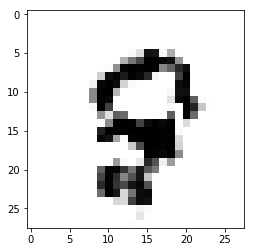

('Estimate:', array([[-2.64637899]], dtype=float32))


('Iteration:', 56700, 'at', datetime.datetime(2018, 3, 12, 13, 15, 38, 693789))


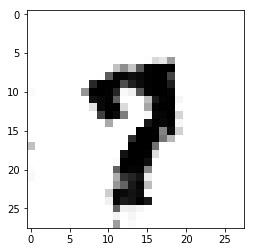

('Estimate:', array([[ 3.91213036]], dtype=float32))


('Iteration:', 56800, 'at', datetime.datetime(2018, 3, 12, 13, 15, 42, 584494))


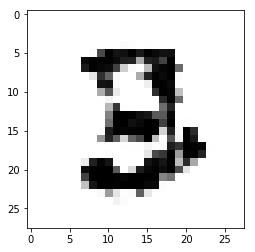

('Estimate:', array([[ 20.96658897]], dtype=float32))


('Iteration:', 56900, 'at', datetime.datetime(2018, 3, 12, 13, 15, 46, 441543))


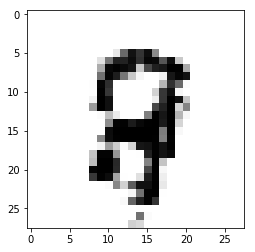

('Estimate:', array([[-5.21212149]], dtype=float32))


('Iteration:', 57000, 'at', datetime.datetime(2018, 3, 12, 13, 15, 50, 336621))


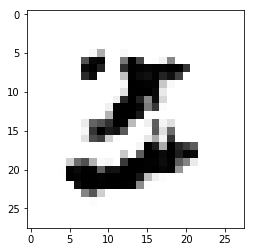

('Estimate:', array([[ 0.10373634]], dtype=float32))


('Iteration:', 57100, 'at', datetime.datetime(2018, 3, 12, 13, 15, 54, 177320))


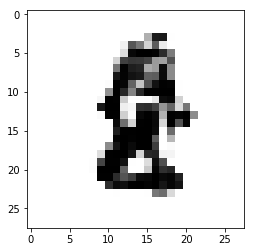

('Estimate:', array([[-12.94723129]], dtype=float32))


('Iteration:', 57200, 'at', datetime.datetime(2018, 3, 12, 13, 15, 58, 6431))


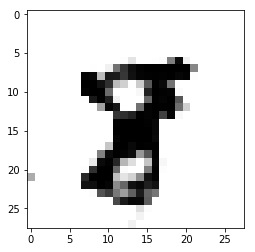

('Estimate:', array([[-2.8238554]], dtype=float32))


('Iteration:', 57300, 'at', datetime.datetime(2018, 3, 12, 13, 16, 1, 833222))


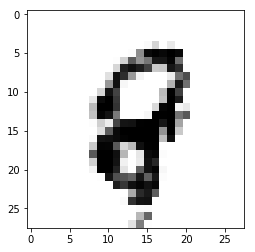

('Estimate:', array([[ 3.97103071]], dtype=float32))


('Iteration:', 57400, 'at', datetime.datetime(2018, 3, 12, 13, 16, 5, 740795))


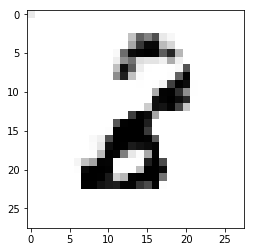

('Estimate:', array([[-2.6540401]], dtype=float32))


('Iteration:', 57500, 'at', datetime.datetime(2018, 3, 12, 13, 16, 9, 625023))


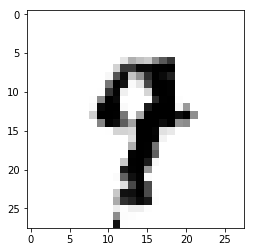

('Estimate:', array([[-0.56190825]], dtype=float32))


('Iteration:', 57600, 'at', datetime.datetime(2018, 3, 12, 13, 16, 13, 514030))


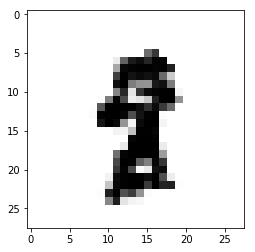

('Estimate:', array([[-2.49563098]], dtype=float32))


('Iteration:', 57700, 'at', datetime.datetime(2018, 3, 12, 13, 16, 17, 366682))


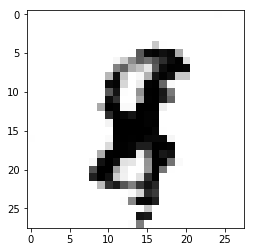

('Estimate:', array([[-6.87879801]], dtype=float32))


('Iteration:', 57800, 'at', datetime.datetime(2018, 3, 12, 13, 16, 21, 180655))


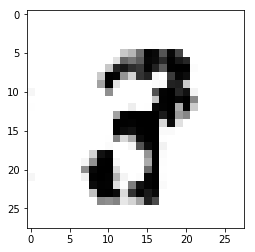

('Estimate:', array([[-6.8754797]], dtype=float32))


('Iteration:', 57900, 'at', datetime.datetime(2018, 3, 12, 13, 16, 25, 39397))


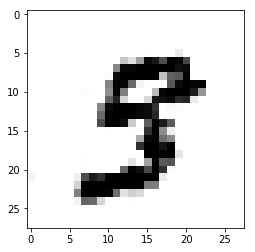

('Estimate:', array([[ 12.12578487]], dtype=float32))


('Iteration:', 58000, 'at', datetime.datetime(2018, 3, 12, 13, 16, 28, 883651))


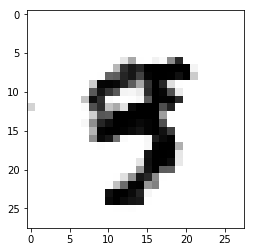

('Estimate:', array([[-20.58166313]], dtype=float32))


('Iteration:', 58100, 'at', datetime.datetime(2018, 3, 12, 13, 16, 32, 756126))


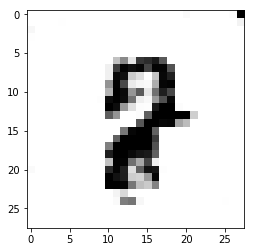

('Estimate:', array([[ 5.5597806]], dtype=float32))


('Iteration:', 58200, 'at', datetime.datetime(2018, 3, 12, 13, 16, 36, 651794))


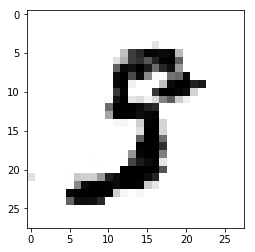

('Estimate:', array([[ 15.54451752]], dtype=float32))


('Iteration:', 58300, 'at', datetime.datetime(2018, 3, 12, 13, 16, 40, 499268))


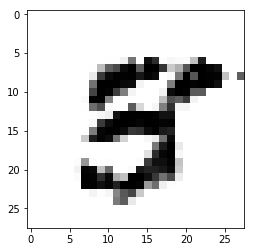

('Estimate:', array([[ 11.42078018]], dtype=float32))


('Iteration:', 58400, 'at', datetime.datetime(2018, 3, 12, 13, 16, 44, 420159))


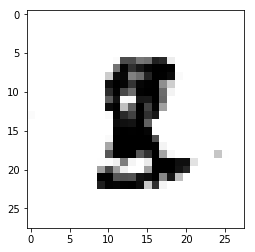

('Estimate:', array([[-13.07349491]], dtype=float32))


('Iteration:', 58500, 'at', datetime.datetime(2018, 3, 12, 13, 16, 48, 335747))


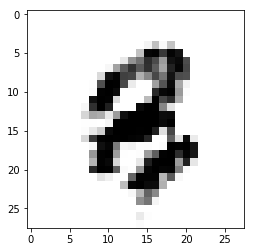

('Estimate:', array([[-4.92148733]], dtype=float32))


('Iteration:', 58600, 'at', datetime.datetime(2018, 3, 12, 13, 16, 52, 155950))


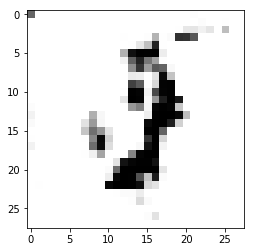

('Estimate:', array([[-22.09325409]], dtype=float32))


('Iteration:', 58700, 'at', datetime.datetime(2018, 3, 12, 13, 16, 55, 975040))


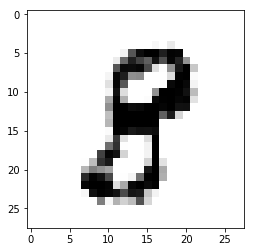

('Estimate:', array([[ 19.2207489]], dtype=float32))


('Iteration:', 58800, 'at', datetime.datetime(2018, 3, 12, 13, 16, 59, 860164))


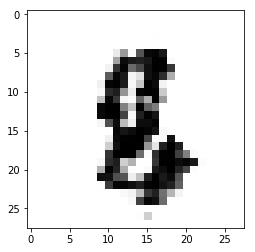

('Estimate:', array([[ 9.54750252]], dtype=float32))


('Iteration:', 58900, 'at', datetime.datetime(2018, 3, 12, 13, 17, 3, 762659))


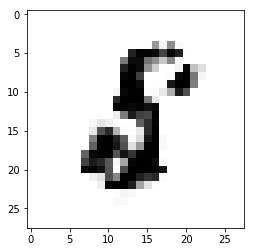

('Estimate:', array([[-2.36955714]], dtype=float32))


('Iteration:', 59000, 'at', datetime.datetime(2018, 3, 12, 13, 17, 7, 678613))


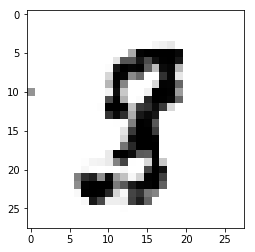

('Estimate:', array([[-4.06916428]], dtype=float32))


('Iteration:', 59100, 'at', datetime.datetime(2018, 3, 12, 13, 17, 11, 600609))


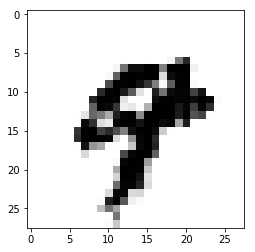

('Estimate:', array([[-0.48048365]], dtype=float32))


('Iteration:', 59200, 'at', datetime.datetime(2018, 3, 12, 13, 17, 15, 460430))


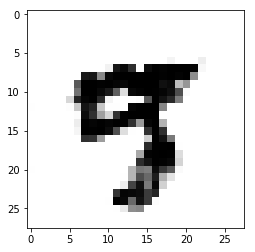

('Estimate:', array([[ 0.30471522]], dtype=float32))


('Iteration:', 59300, 'at', datetime.datetime(2018, 3, 12, 13, 17, 19, 375951))


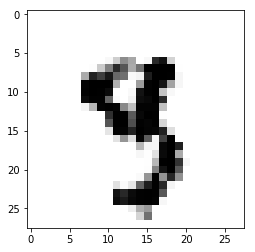

('Estimate:', array([[ 10.10329533]], dtype=float32))


('Iteration:', 59400, 'at', datetime.datetime(2018, 3, 12, 13, 17, 23, 422309))


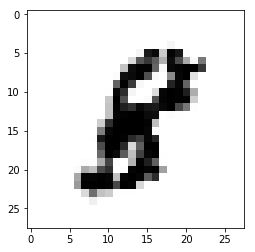

('Estimate:', array([[-6.7878871]], dtype=float32))


('Iteration:', 59500, 'at', datetime.datetime(2018, 3, 12, 13, 17, 27, 416463))


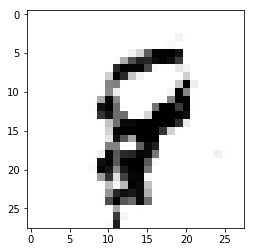

('Estimate:', array([[ 1.84515595]], dtype=float32))


('Iteration:', 59600, 'at', datetime.datetime(2018, 3, 12, 13, 17, 31, 353123))


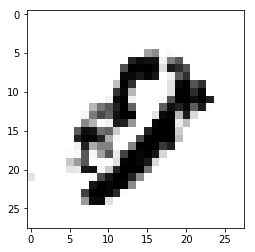

('Estimate:', array([[-10.27287674]], dtype=float32))


('Iteration:', 59700, 'at', datetime.datetime(2018, 3, 12, 13, 17, 35, 328791))


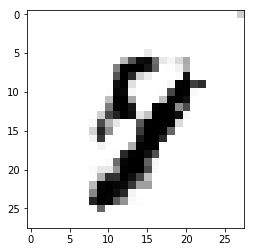

('Estimate:', array([[ 7.5182395]], dtype=float32))


('Iteration:', 59800, 'at', datetime.datetime(2018, 3, 12, 13, 17, 39, 263835))


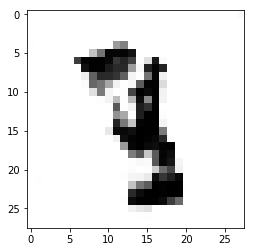

('Estimate:', array([[ 4.08769417]], dtype=float32))


('Iteration:', 59900, 'at', datetime.datetime(2018, 3, 12, 13, 17, 43, 102891))


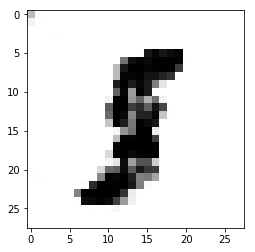

('Estimate:', array([[ 2.43558407]], dtype=float32))


('Iteration:', 60000, 'at', datetime.datetime(2018, 3, 12, 13, 17, 46, 996771))


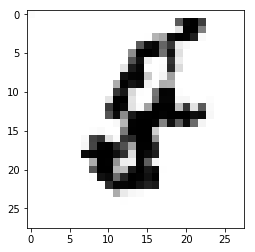

('Estimate:', array([[ 11.50718594]], dtype=float32))


('Iteration:', 60100, 'at', datetime.datetime(2018, 3, 12, 13, 17, 50, 927841))


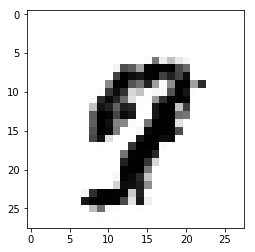

('Estimate:', array([[ 12.39816761]], dtype=float32))


('Iteration:', 60200, 'at', datetime.datetime(2018, 3, 12, 13, 17, 54, 891800))


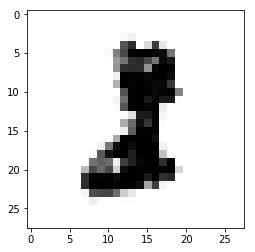

('Estimate:', array([[ 6.37984371]], dtype=float32))


('Iteration:', 60300, 'at', datetime.datetime(2018, 3, 12, 13, 17, 58, 822682))


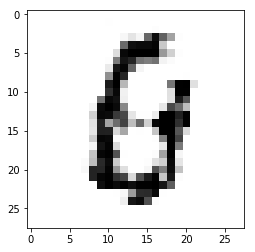

('Estimate:', array([[ 13.02199554]], dtype=float32))


('Iteration:', 60400, 'at', datetime.datetime(2018, 3, 12, 13, 18, 2, 775283))


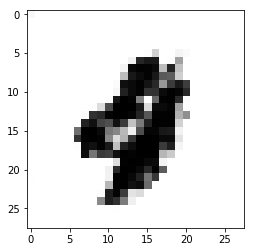

('Estimate:', array([[-5.46161366]], dtype=float32))


('Iteration:', 60500, 'at', datetime.datetime(2018, 3, 12, 13, 18, 6, 741828))


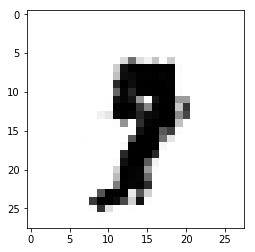

('Estimate:', array([[ 24.13572311]], dtype=float32))


('Iteration:', 60600, 'at', datetime.datetime(2018, 3, 12, 13, 18, 10, 662843))


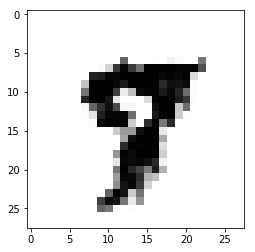

('Estimate:', array([[-6.41176653]], dtype=float32))


('Iteration:', 60700, 'at', datetime.datetime(2018, 3, 12, 13, 18, 14, 455721))


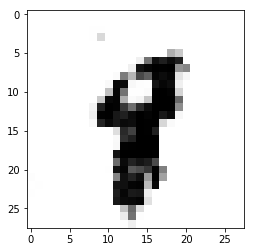

('Estimate:', array([[-0.15786858]], dtype=float32))


('Iteration:', 60800, 'at', datetime.datetime(2018, 3, 12, 13, 18, 18, 273295))


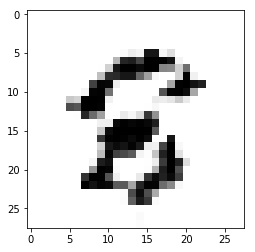

('Estimate:', array([[ 10.35465336]], dtype=float32))


('Iteration:', 60900, 'at', datetime.datetime(2018, 3, 12, 13, 18, 22, 118008))


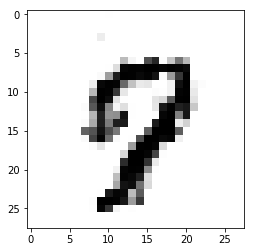

('Estimate:', array([[-5.63592148]], dtype=float32))


('Iteration:', 61000, 'at', datetime.datetime(2018, 3, 12, 13, 18, 25, 959522))


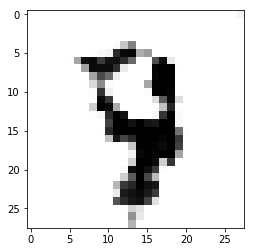

('Estimate:', array([[-0.87071484]], dtype=float32))


('Iteration:', 61100, 'at', datetime.datetime(2018, 3, 12, 13, 18, 29, 894655))


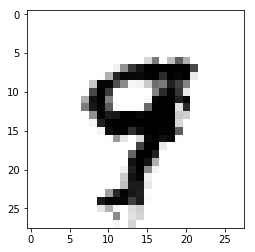

('Estimate:', array([[-5.84147882]], dtype=float32))


('Iteration:', 61200, 'at', datetime.datetime(2018, 3, 12, 13, 18, 33, 820759))


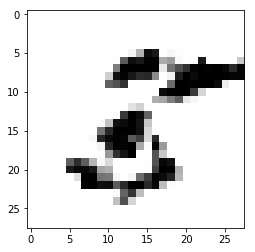

('Estimate:', array([[-0.305756]], dtype=float32))


('Iteration:', 61300, 'at', datetime.datetime(2018, 3, 12, 13, 18, 37, 731737))


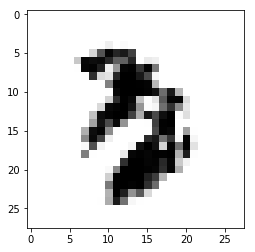

('Estimate:', array([[ 8.83249664]], dtype=float32))


('Iteration:', 61400, 'at', datetime.datetime(2018, 3, 12, 13, 18, 41, 687169))


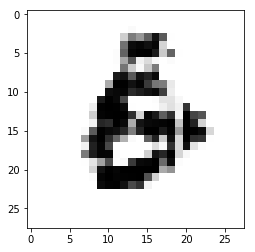

('Estimate:', array([[ 7.32675171]], dtype=float32))


('Iteration:', 61500, 'at', datetime.datetime(2018, 3, 12, 13, 18, 45, 554824))


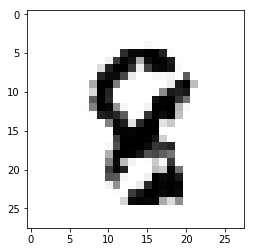

('Estimate:', array([[ 26.57417107]], dtype=float32))


('Iteration:', 61600, 'at', datetime.datetime(2018, 3, 12, 13, 18, 49, 480105))


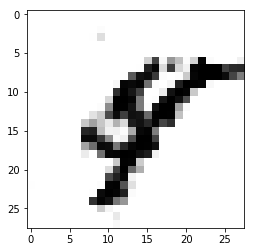

('Estimate:', array([[-1.78238428]], dtype=float32))


('Iteration:', 61700, 'at', datetime.datetime(2018, 3, 12, 13, 18, 53, 449184))


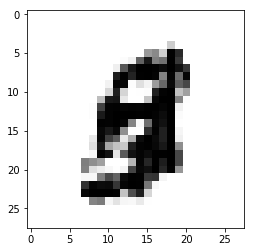

('Estimate:', array([[-17.12231636]], dtype=float32))


('Iteration:', 61800, 'at', datetime.datetime(2018, 3, 12, 13, 18, 57, 534522))


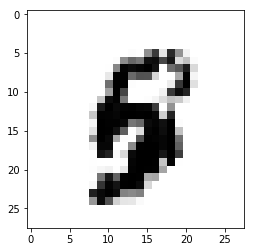

('Estimate:', array([[-6.66158628]], dtype=float32))


('Iteration:', 61900, 'at', datetime.datetime(2018, 3, 12, 13, 19, 1, 582157))


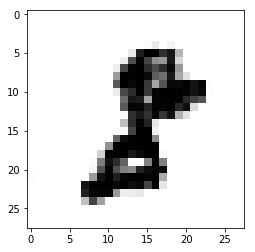

('Estimate:', array([[ 14.67356205]], dtype=float32))


('Iteration:', 62000, 'at', datetime.datetime(2018, 3, 12, 13, 19, 5, 625269))


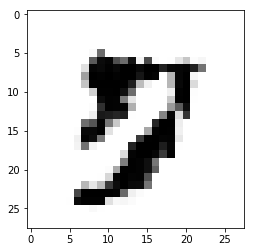

('Estimate:', array([[ 13.71918392]], dtype=float32))


('Iteration:', 62100, 'at', datetime.datetime(2018, 3, 12, 13, 19, 9, 643657))


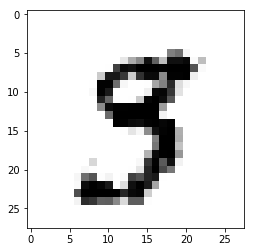

('Estimate:', array([[-3.83764863]], dtype=float32))


('Iteration:', 62200, 'at', datetime.datetime(2018, 3, 12, 13, 19, 13, 705259))


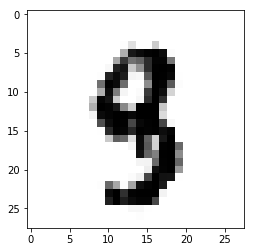

('Estimate:', array([[ 22.26877022]], dtype=float32))


('Iteration:', 62300, 'at', datetime.datetime(2018, 3, 12, 13, 19, 17, 742210))


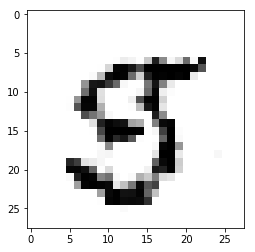

('Estimate:', array([[-4.97172832]], dtype=float32))


('Iteration:', 62400, 'at', datetime.datetime(2018, 3, 12, 13, 19, 21, 731188))


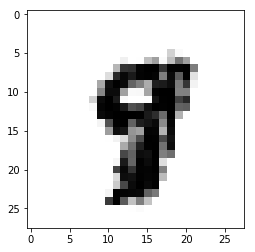

('Estimate:', array([[-7.8759346]], dtype=float32))


('Iteration:', 62500, 'at', datetime.datetime(2018, 3, 12, 13, 19, 25, 675829))


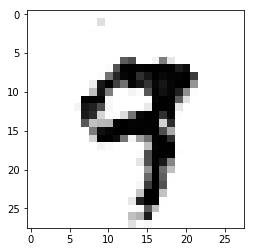

('Estimate:', array([[ 7.4512558]], dtype=float32))


('Iteration:', 62600, 'at', datetime.datetime(2018, 3, 12, 13, 19, 29, 549631))


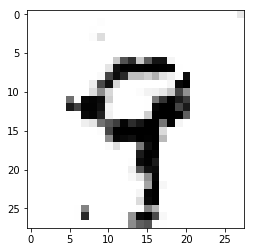

('Estimate:', array([[-2.60823846]], dtype=float32))


('Iteration:', 62700, 'at', datetime.datetime(2018, 3, 12, 13, 19, 33, 465624))


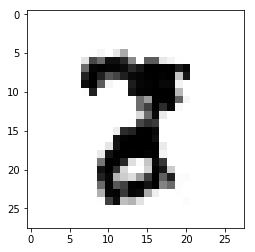

('Estimate:', array([[ 31.43767166]], dtype=float32))


('Iteration:', 62800, 'at', datetime.datetime(2018, 3, 12, 13, 19, 37, 408510))


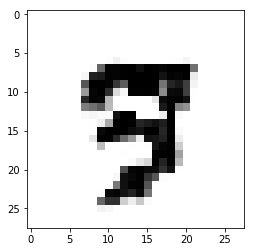

('Estimate:', array([[-4.69899416]], dtype=float32))


('Iteration:', 62900, 'at', datetime.datetime(2018, 3, 12, 13, 19, 41, 428977))


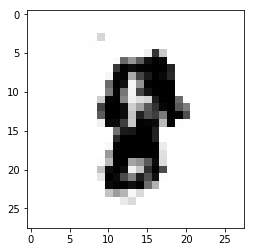

('Estimate:', array([[-3.34798932]], dtype=float32))


('Iteration:', 63000, 'at', datetime.datetime(2018, 3, 12, 13, 19, 45, 351224))


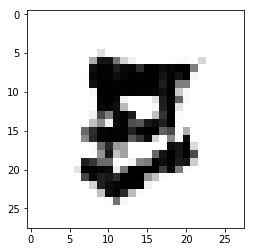

('Estimate:', array([[ 8.12328243]], dtype=float32))


('Iteration:', 63100, 'at', datetime.datetime(2018, 3, 12, 13, 19, 49, 291281))


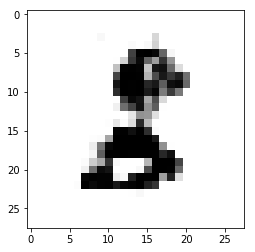

('Estimate:', array([[-22.75666809]], dtype=float32))


('Iteration:', 63200, 'at', datetime.datetime(2018, 3, 12, 13, 19, 53, 218996))


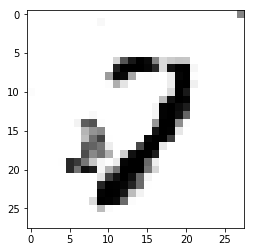

('Estimate:', array([[ 7.56139135]], dtype=float32))


('Iteration:', 63300, 'at', datetime.datetime(2018, 3, 12, 13, 19, 57, 147543))


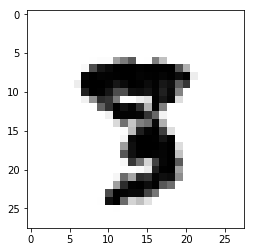

('Estimate:', array([[-3.34726024]], dtype=float32))


('Iteration:', 63400, 'at', datetime.datetime(2018, 3, 12, 13, 20, 1, 132592))


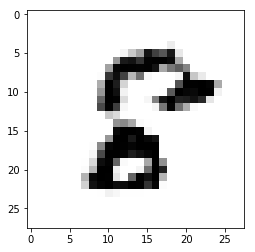

('Estimate:', array([[-3.36760116]], dtype=float32))


('Iteration:', 63500, 'at', datetime.datetime(2018, 3, 12, 13, 20, 5, 161546))


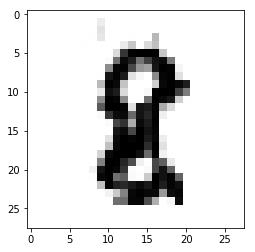

('Estimate:', array([[ 2.75465918]], dtype=float32))


('Iteration:', 63600, 'at', datetime.datetime(2018, 3, 12, 13, 20, 9, 86541))


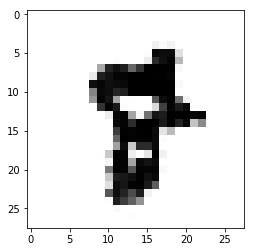

('Estimate:', array([[-9.13402367]], dtype=float32))


('Iteration:', 63700, 'at', datetime.datetime(2018, 3, 12, 13, 20, 13, 47396))


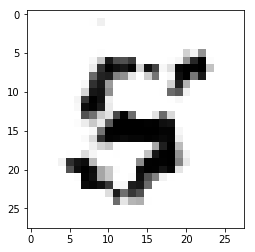

('Estimate:', array([[-11.32060432]], dtype=float32))


('Iteration:', 63800, 'at', datetime.datetime(2018, 3, 12, 13, 20, 17, 133997))


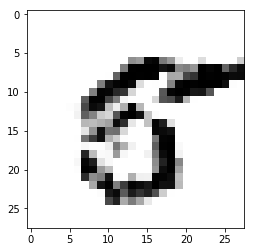

('Estimate:', array([[-3.67957497]], dtype=float32))


('Iteration:', 63900, 'at', datetime.datetime(2018, 3, 12, 13, 20, 21, 200534))


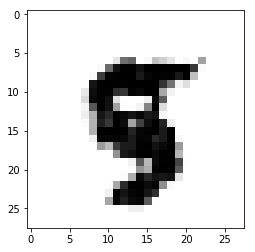

('Estimate:', array([[ 7.09726572]], dtype=float32))


('Iteration:', 64000, 'at', datetime.datetime(2018, 3, 12, 13, 20, 25, 112608))


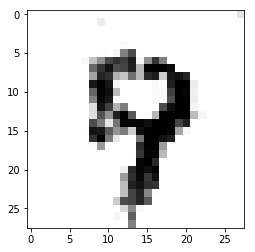

('Estimate:', array([[-18.57528496]], dtype=float32))


('Iteration:', 64100, 'at', datetime.datetime(2018, 3, 12, 13, 20, 29, 32526))


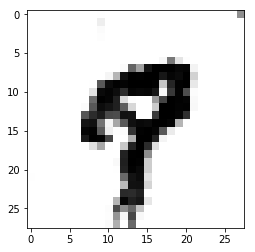

('Estimate:', array([[ 17.89266586]], dtype=float32))


('Iteration:', 64200, 'at', datetime.datetime(2018, 3, 12, 13, 20, 33, 85438))


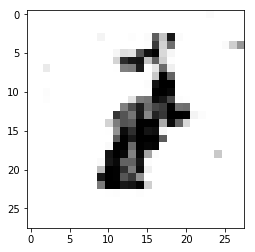

('Estimate:', array([[-19.67874908]], dtype=float32))


('Iteration:', 64300, 'at', datetime.datetime(2018, 3, 12, 13, 20, 37, 142535))


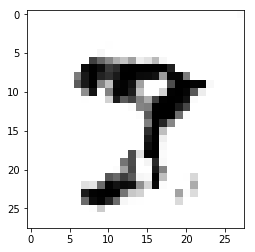

('Estimate:', array([[-5.17255116]], dtype=float32))


('Iteration:', 64400, 'at', datetime.datetime(2018, 3, 12, 13, 20, 41, 214473))


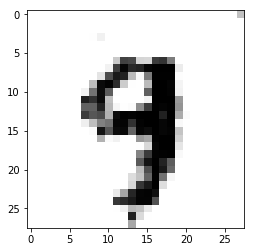

('Estimate:', array([[ 11.75947094]], dtype=float32))


('Iteration:', 64500, 'at', datetime.datetime(2018, 3, 12, 13, 20, 45, 160062))


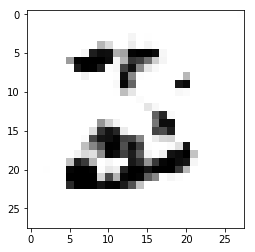

('Estimate:', array([[ 36.18081665]], dtype=float32))


('Iteration:', 64600, 'at', datetime.datetime(2018, 3, 12, 13, 20, 49, 167579))


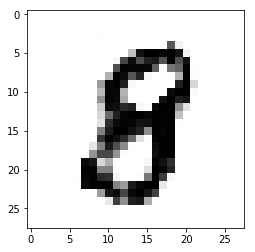

('Estimate:', array([[ 6.59883022]], dtype=float32))


('Iteration:', 64700, 'at', datetime.datetime(2018, 3, 12, 13, 20, 53, 136652))


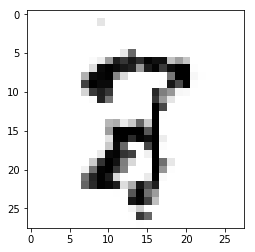

('Estimate:', array([[-4.67930365]], dtype=float32))


('Iteration:', 64800, 'at', datetime.datetime(2018, 3, 12, 13, 20, 57, 67917))


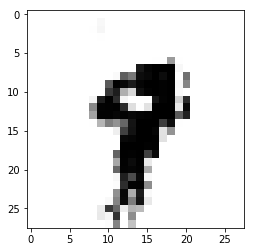

('Estimate:', array([[-3.71393561]], dtype=float32))


('Iteration:', 64900, 'at', datetime.datetime(2018, 3, 12, 13, 21, 1, 917777))


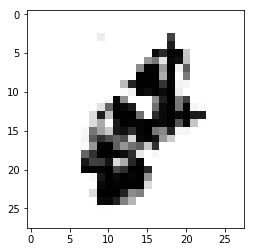

('Estimate:', array([[-2.1902163]], dtype=float32))


('Iteration:', 65000, 'at', datetime.datetime(2018, 3, 12, 13, 21, 5, 951045))


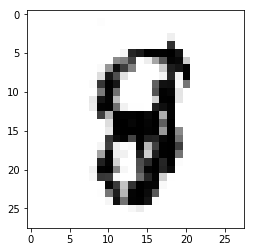

('Estimate:', array([[-9.46815681]], dtype=float32))


('Iteration:', 65100, 'at', datetime.datetime(2018, 3, 12, 13, 21, 10, 150646))


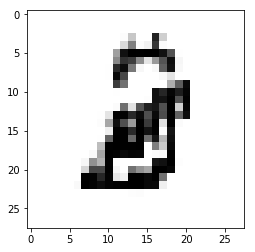

('Estimate:', array([[-8.58245564]], dtype=float32))


('Iteration:', 65200, 'at', datetime.datetime(2018, 3, 12, 13, 21, 14, 185841))


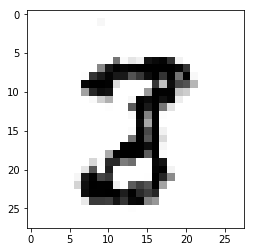

('Estimate:', array([[-10.62657738]], dtype=float32))


('Iteration:', 65300, 'at', datetime.datetime(2018, 3, 12, 13, 21, 18, 179379))


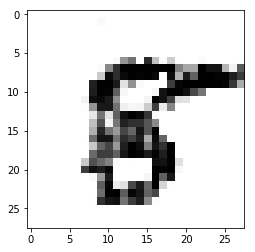

('Estimate:', array([[-1.97150588]], dtype=float32))


('Iteration:', 65400, 'at', datetime.datetime(2018, 3, 12, 13, 21, 22, 353408))


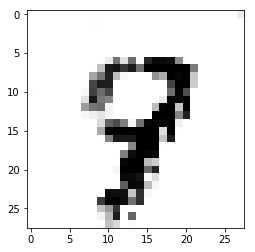

('Estimate:', array([[-5.48625803]], dtype=float32))


('Iteration:', 65500, 'at', datetime.datetime(2018, 3, 12, 13, 21, 26, 468839))


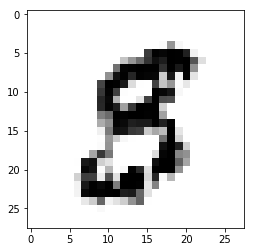

('Estimate:', array([[-4.908566]], dtype=float32))


('Iteration:', 65600, 'at', datetime.datetime(2018, 3, 12, 13, 21, 30, 536143))


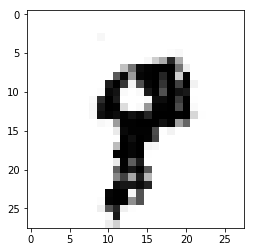

('Estimate:', array([[-3.27616096]], dtype=float32))


('Iteration:', 65700, 'at', datetime.datetime(2018, 3, 12, 13, 21, 34, 623663))


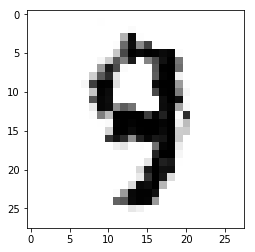

('Estimate:', array([[-16.79640198]], dtype=float32))


('Iteration:', 65800, 'at', datetime.datetime(2018, 3, 12, 13, 21, 38, 729451))


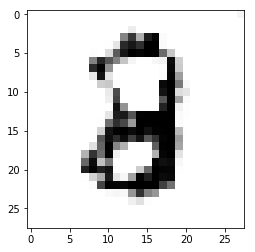

('Estimate:', array([[ 2.09438777]], dtype=float32))


('Iteration:', 65900, 'at', datetime.datetime(2018, 3, 12, 13, 21, 42, 788868))


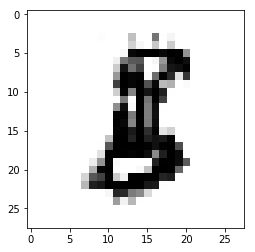

('Estimate:', array([[ 9.58551693]], dtype=float32))


('Iteration:', 66000, 'at', datetime.datetime(2018, 3, 12, 13, 21, 46, 815605))


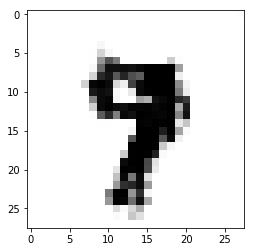

('Estimate:', array([[ 25.07048988]], dtype=float32))


('Iteration:', 66100, 'at', datetime.datetime(2018, 3, 12, 13, 21, 50, 861826))


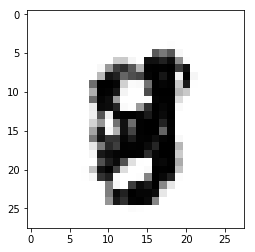

('Estimate:', array([[-8.39491844]], dtype=float32))


('Iteration:', 66200, 'at', datetime.datetime(2018, 3, 12, 13, 21, 54, 895513))


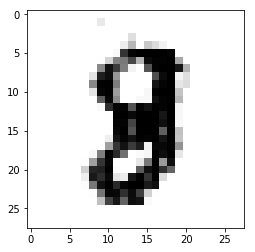

('Estimate:', array([[-1.14101994]], dtype=float32))


('Iteration:', 66300, 'at', datetime.datetime(2018, 3, 12, 13, 21, 58, 949579))


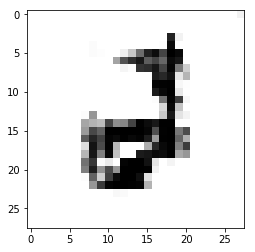

('Estimate:', array([[ 24.10012245]], dtype=float32))


('Iteration:', 66400, 'at', datetime.datetime(2018, 3, 12, 13, 22, 2, 944826))


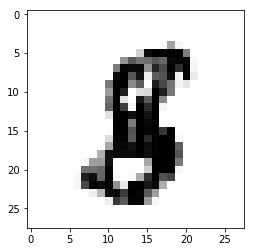

('Estimate:', array([[ 11.43765068]], dtype=float32))


('Iteration:', 66500, 'at', datetime.datetime(2018, 3, 12, 13, 22, 7, 67029))


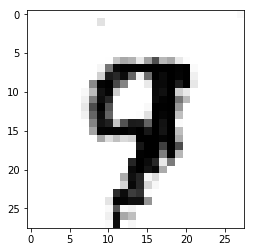

('Estimate:', array([[-11.05805492]], dtype=float32))


('Iteration:', 66600, 'at', datetime.datetime(2018, 3, 12, 13, 22, 11, 205103))


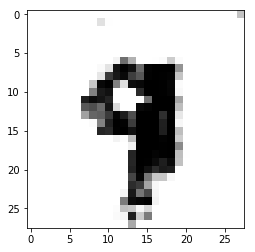

('Estimate:', array([[-0.84179252]], dtype=float32))


('Iteration:', 66700, 'at', datetime.datetime(2018, 3, 12, 13, 22, 15, 445434))


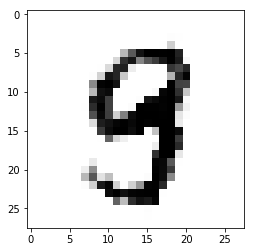

('Estimate:', array([[ 14.45770073]], dtype=float32))


('Iteration:', 66800, 'at', datetime.datetime(2018, 3, 12, 13, 22, 19, 521344))


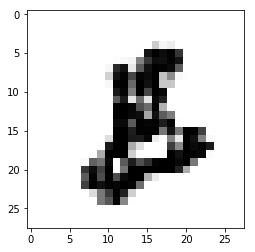

('Estimate:', array([[-9.47887135]], dtype=float32))


('Iteration:', 66900, 'at', datetime.datetime(2018, 3, 12, 13, 22, 23, 534798))


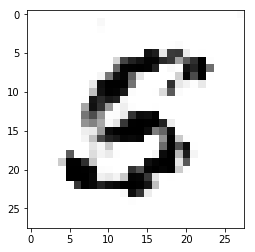

('Estimate:', array([[ 15.24956322]], dtype=float32))


('Iteration:', 67000, 'at', datetime.datetime(2018, 3, 12, 13, 22, 27, 589176))


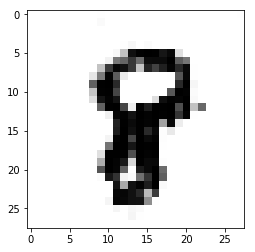

('Estimate:', array([[ 12.39752579]], dtype=float32))


('Iteration:', 67100, 'at', datetime.datetime(2018, 3, 12, 13, 22, 31, 675796))


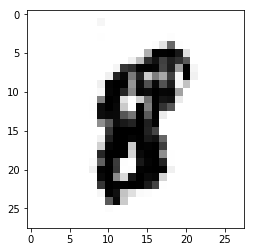

('Estimate:', array([[-24.91366386]], dtype=float32))


('Iteration:', 67200, 'at', datetime.datetime(2018, 3, 12, 13, 22, 35, 689552))


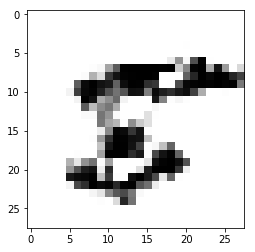

('Estimate:', array([[-0.65231901]], dtype=float32))


('Iteration:', 67300, 'at', datetime.datetime(2018, 3, 12, 13, 22, 39, 731451))


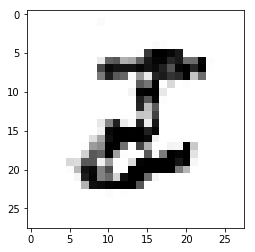

('Estimate:', array([[-2.05709338]], dtype=float32))


('Iteration:', 67400, 'at', datetime.datetime(2018, 3, 12, 13, 22, 43, 784940))


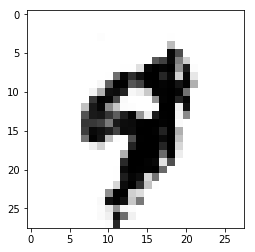

('Estimate:', array([[ 22.73290634]], dtype=float32))


('Iteration:', 67500, 'at', datetime.datetime(2018, 3, 12, 13, 22, 47, 935149))


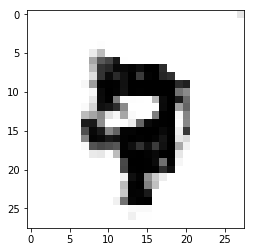

('Estimate:', array([[-9.39354324]], dtype=float32))


('Iteration:', 67600, 'at', datetime.datetime(2018, 3, 12, 13, 22, 52, 57842))


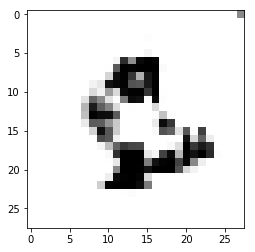

('Estimate:', array([[-17.27120209]], dtype=float32))


('Iteration:', 67700, 'at', datetime.datetime(2018, 3, 12, 13, 22, 56, 42819))


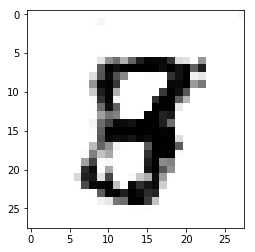

('Estimate:', array([[-18.20594215]], dtype=float32))


('Iteration:', 67800, 'at', datetime.datetime(2018, 3, 12, 13, 23, 0, 50371))


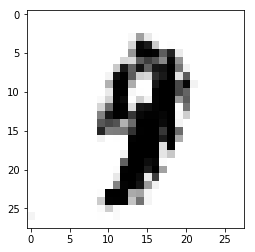

('Estimate:', array([[-14.91757965]], dtype=float32))


('Iteration:', 67900, 'at', datetime.datetime(2018, 3, 12, 13, 23, 4, 119929))


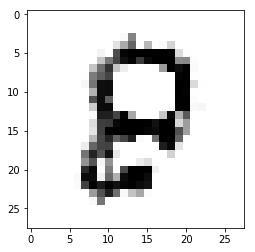

('Estimate:', array([[ 12.3002224]], dtype=float32))


('Iteration:', 68000, 'at', datetime.datetime(2018, 3, 12, 13, 23, 8, 163670))


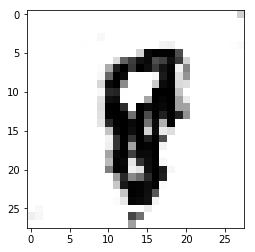

('Estimate:', array([[-4.58524942]], dtype=float32))


('Iteration:', 68100, 'at', datetime.datetime(2018, 3, 12, 13, 23, 12, 222717))


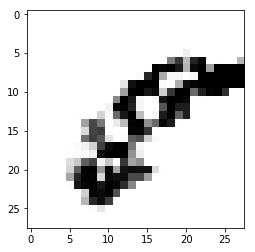

('Estimate:', array([[ 7.12490892]], dtype=float32))


('Iteration:', 68200, 'at', datetime.datetime(2018, 3, 12, 13, 23, 16, 372008))


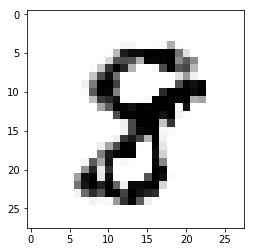

('Estimate:', array([[ 34.63964462]], dtype=float32))


('Iteration:', 68300, 'at', datetime.datetime(2018, 3, 12, 13, 23, 20, 418309))


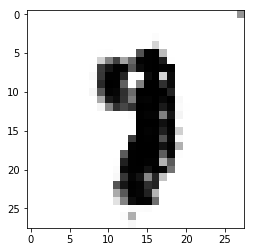

('Estimate:', array([[-2.49905586]], dtype=float32))


('Iteration:', 68400, 'at', datetime.datetime(2018, 3, 12, 13, 23, 24, 428145))


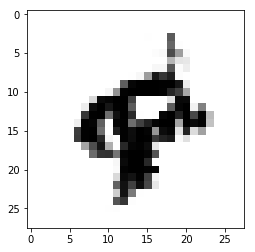

('Estimate:', array([[-12.3927002]], dtype=float32))


('Iteration:', 68500, 'at', datetime.datetime(2018, 3, 12, 13, 23, 28, 539584))


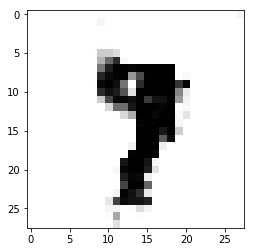

('Estimate:', array([[ 11.98429203]], dtype=float32))


('Iteration:', 68600, 'at', datetime.datetime(2018, 3, 12, 13, 23, 32, 597761))


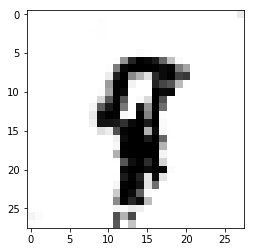

('Estimate:', array([[-1.17406702]], dtype=float32))


('Iteration:', 68700, 'at', datetime.datetime(2018, 3, 12, 13, 23, 36, 649685))


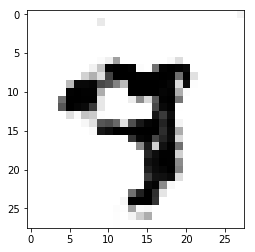

('Estimate:', array([[-0.52477974]], dtype=float32))


('Iteration:', 68800, 'at', datetime.datetime(2018, 3, 12, 13, 23, 40, 678424))


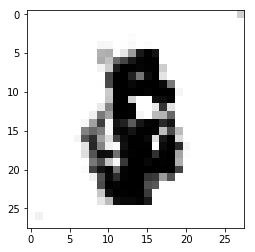

('Estimate:', array([[-9.04187202]], dtype=float32))


('Iteration:', 68900, 'at', datetime.datetime(2018, 3, 12, 13, 23, 44, 780791))


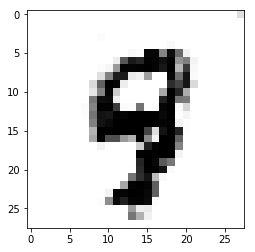

('Estimate:', array([[-12.75699711]], dtype=float32))


('Iteration:', 69000, 'at', datetime.datetime(2018, 3, 12, 13, 23, 48, 921819))


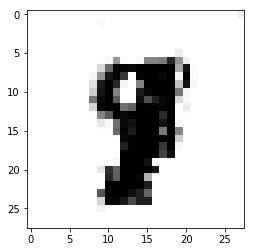

('Estimate:', array([[-9.14124107]], dtype=float32))


('Iteration:', 69100, 'at', datetime.datetime(2018, 3, 12, 13, 23, 52, 961606))


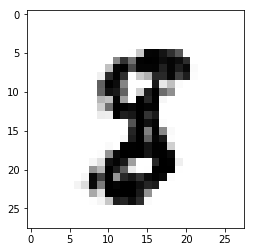

('Estimate:', array([[-0.75254864]], dtype=float32))


('Iteration:', 69200, 'at', datetime.datetime(2018, 3, 12, 13, 23, 57, 13996))


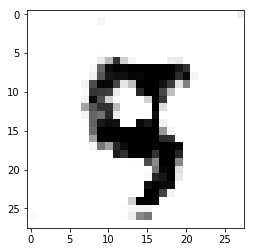

('Estimate:', array([[ 5.82605886]], dtype=float32))


('Iteration:', 69300, 'at', datetime.datetime(2018, 3, 12, 13, 24, 1, 86673))


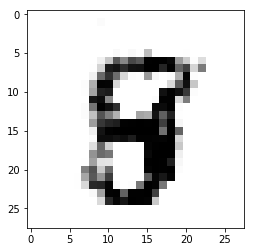

('Estimate:', array([[-9.36696529]], dtype=float32))


('Iteration:', 69400, 'at', datetime.datetime(2018, 3, 12, 13, 24, 5, 124776))


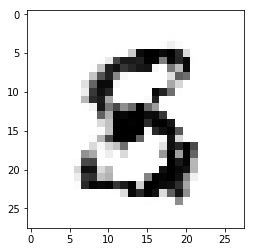

('Estimate:', array([[ 4.89082336]], dtype=float32))


('Iteration:', 69500, 'at', datetime.datetime(2018, 3, 12, 13, 24, 9, 165370))


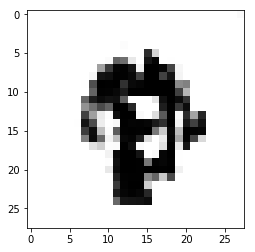

('Estimate:', array([[-24.76211166]], dtype=float32))


('Iteration:', 69600, 'at', datetime.datetime(2018, 3, 12, 13, 24, 13, 196884))


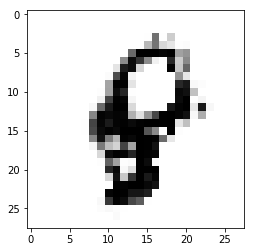

('Estimate:', array([[ 8.14705372]], dtype=float32))


('Iteration:', 69700, 'at', datetime.datetime(2018, 3, 12, 13, 24, 17, 285079))


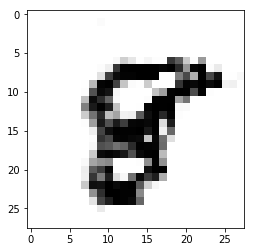

('Estimate:', array([[-11.83677769]], dtype=float32))


('Iteration:', 69800, 'at', datetime.datetime(2018, 3, 12, 13, 24, 21, 349811))


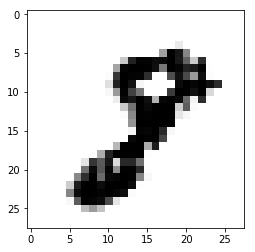

('Estimate:', array([[ 26.40088654]], dtype=float32))


('Iteration:', 69900, 'at', datetime.datetime(2018, 3, 12, 13, 24, 25, 414023))


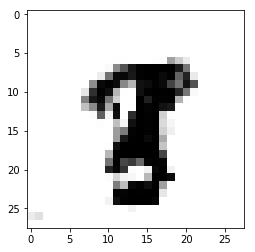

('Estimate:', array([[ 16.45210457]], dtype=float32))


('Iteration:', 70000, 'at', datetime.datetime(2018, 3, 12, 13, 24, 29, 439974))


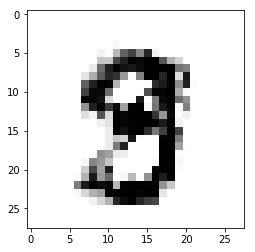

('Estimate:', array([[-6.85280037]], dtype=float32))


('Iteration:', 70100, 'at', datetime.datetime(2018, 3, 12, 13, 24, 33, 549204))


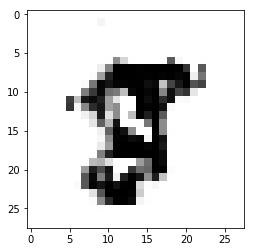

('Estimate:', array([[ 10.78508282]], dtype=float32))


('Iteration:', 70200, 'at', datetime.datetime(2018, 3, 12, 13, 24, 37, 622684))


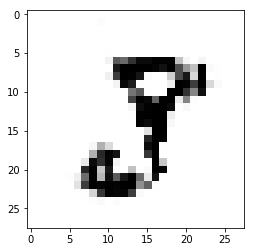

('Estimate:', array([[ 2.02099776]], dtype=float32))


('Iteration:', 70300, 'at', datetime.datetime(2018, 3, 12, 13, 24, 41, 707400))


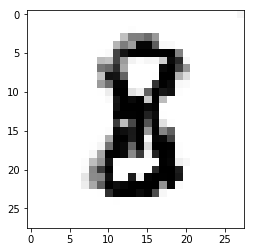

('Estimate:', array([[-4.39044523]], dtype=float32))


('Iteration:', 70400, 'at', datetime.datetime(2018, 3, 12, 13, 24, 45, 766020))


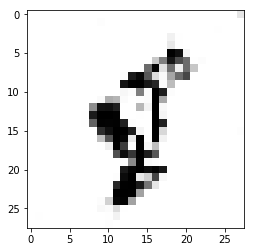

('Estimate:', array([[ 6.29360485]], dtype=float32))


('Iteration:', 70500, 'at', datetime.datetime(2018, 3, 12, 13, 24, 49, 851373))


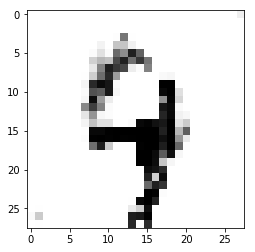

('Estimate:', array([[ 0.19455284]], dtype=float32))


('Iteration:', 70600, 'at', datetime.datetime(2018, 3, 12, 13, 24, 53, 952026))


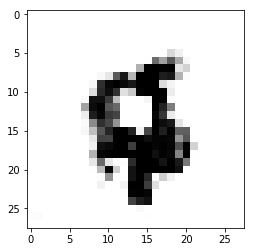

('Estimate:', array([[-14.49102116]], dtype=float32))


('Iteration:', 70700, 'at', datetime.datetime(2018, 3, 12, 13, 24, 58, 16173))


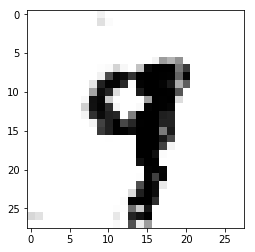

('Estimate:', array([[ 13.87057781]], dtype=float32))


('Iteration:', 70800, 'at', datetime.datetime(2018, 3, 12, 13, 25, 2, 70956))


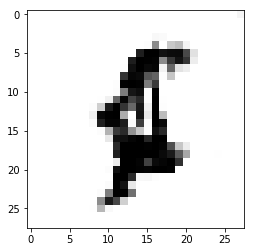

('Estimate:', array([[ 18.28785896]], dtype=float32))


('Iteration:', 70900, 'at', datetime.datetime(2018, 3, 12, 13, 25, 6, 100472))


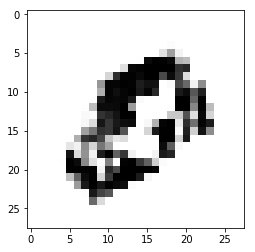

('Estimate:', array([[-4.27280998]], dtype=float32))


('Iteration:', 71000, 'at', datetime.datetime(2018, 3, 12, 13, 25, 10, 140226))


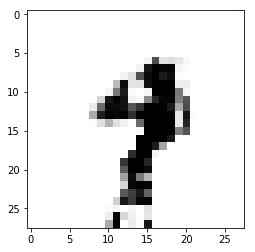

('Estimate:', array([[ 6.30949068]], dtype=float32))


('Iteration:', 71100, 'at', datetime.datetime(2018, 3, 12, 13, 25, 14, 204917))


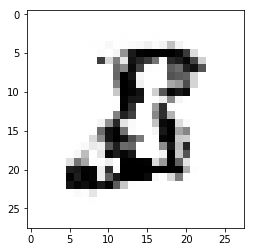

('Estimate:', array([[-25.70786476]], dtype=float32))


('Iteration:', 71200, 'at', datetime.datetime(2018, 3, 12, 13, 25, 18, 357152))


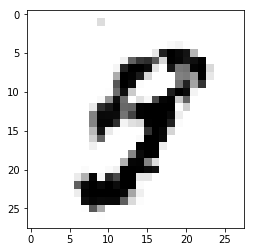

('Estimate:', array([[-19.95684433]], dtype=float32))


('Iteration:', 71300, 'at', datetime.datetime(2018, 3, 12, 13, 25, 22, 435918))


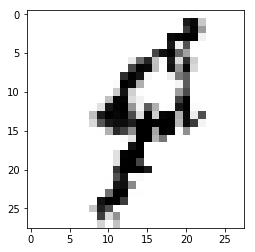

('Estimate:', array([[ 11.82189178]], dtype=float32))


('Iteration:', 71400, 'at', datetime.datetime(2018, 3, 12, 13, 25, 26, 531913))


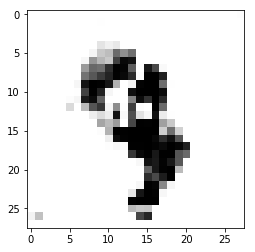

('Estimate:', array([[ 24.35505676]], dtype=float32))


('Iteration:', 71500, 'at', datetime.datetime(2018, 3, 12, 13, 25, 30, 689552))


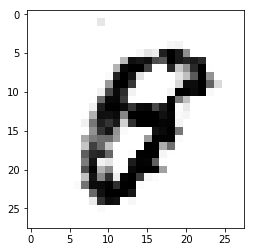

('Estimate:', array([[ 8.89260101]], dtype=float32))


('Iteration:', 71600, 'at', datetime.datetime(2018, 3, 12, 13, 25, 34, 695438))


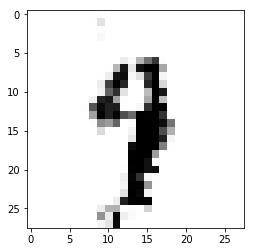

('Estimate:', array([[-10.98418522]], dtype=float32))


('Iteration:', 71700, 'at', datetime.datetime(2018, 3, 12, 13, 25, 38, 776235))


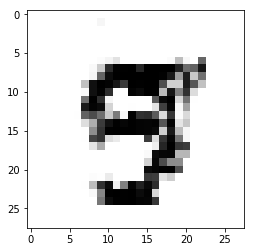

('Estimate:', array([[-1.43157363]], dtype=float32))


('Iteration:', 71800, 'at', datetime.datetime(2018, 3, 12, 13, 25, 42, 911228))


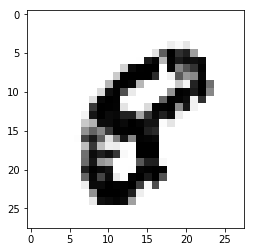

('Estimate:', array([[ 12.57995796]], dtype=float32))


('Iteration:', 71900, 'at', datetime.datetime(2018, 3, 12, 13, 25, 47, 10265))


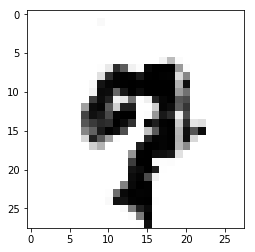

('Estimate:', array([[ 15.61038494]], dtype=float32))


('Iteration:', 72000, 'at', datetime.datetime(2018, 3, 12, 13, 25, 51, 130389))


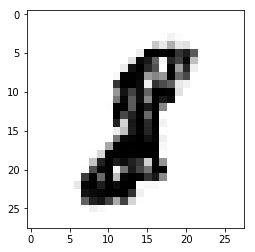

('Estimate:', array([[-10.85673904]], dtype=float32))


('Iteration:', 72100, 'at', datetime.datetime(2018, 3, 12, 13, 25, 55, 263711))


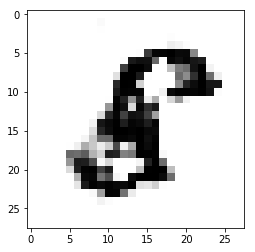

('Estimate:', array([[ 2.27678466]], dtype=float32))


('Iteration:', 72200, 'at', datetime.datetime(2018, 3, 12, 13, 25, 59, 398025))


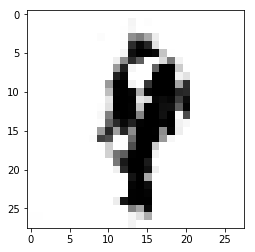

('Estimate:', array([[ 10.41855335]], dtype=float32))


('Iteration:', 72300, 'at', datetime.datetime(2018, 3, 12, 13, 26, 3, 554626))


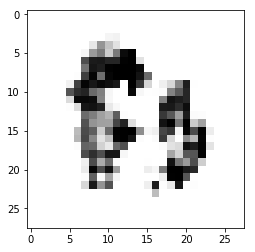

('Estimate:', array([[-66.48010254]], dtype=float32))


('Iteration:', 72400, 'at', datetime.datetime(2018, 3, 12, 13, 26, 7, 871945))


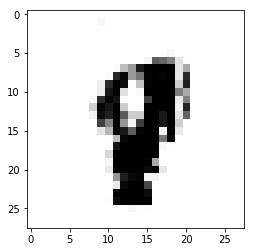

('Estimate:', array([[ 4.11963415]], dtype=float32))


('Iteration:', 72500, 'at', datetime.datetime(2018, 3, 12, 13, 26, 11, 919173))


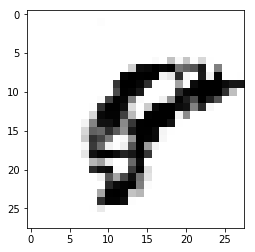

('Estimate:', array([[ 8.49150276]], dtype=float32))


('Iteration:', 72600, 'at', datetime.datetime(2018, 3, 12, 13, 26, 16, 154426))


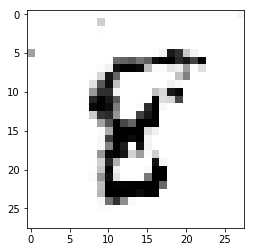

('Estimate:', array([[-17.92238426]], dtype=float32))


('Iteration:', 72700, 'at', datetime.datetime(2018, 3, 12, 13, 26, 20, 388543))


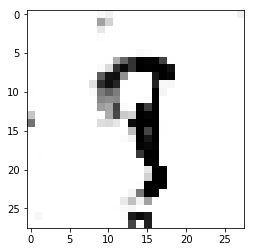

('Estimate:', array([[-22.1064682]], dtype=float32))


('Iteration:', 72800, 'at', datetime.datetime(2018, 3, 12, 13, 26, 24, 566185))


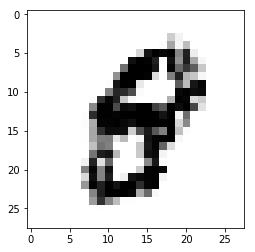

('Estimate:', array([[-6.13523769]], dtype=float32))


('Iteration:', 72900, 'at', datetime.datetime(2018, 3, 12, 13, 26, 28, 744856))


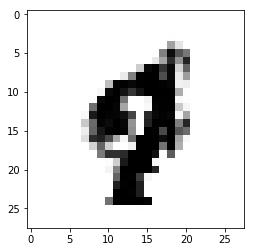

('Estimate:', array([[ 1.64104509]], dtype=float32))


('Iteration:', 73000, 'at', datetime.datetime(2018, 3, 12, 13, 26, 32, 920172))


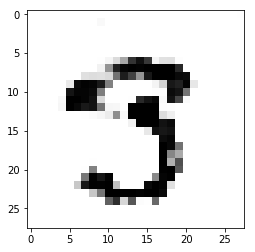

('Estimate:', array([[ 44.95357895]], dtype=float32))


('Iteration:', 73100, 'at', datetime.datetime(2018, 3, 12, 13, 26, 37, 160267))


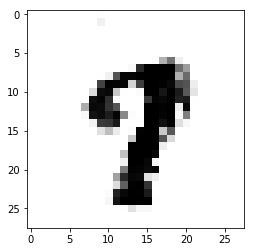

('Estimate:', array([[ 4.85685015]], dtype=float32))


('Iteration:', 73200, 'at', datetime.datetime(2018, 3, 12, 13, 26, 41, 392172))


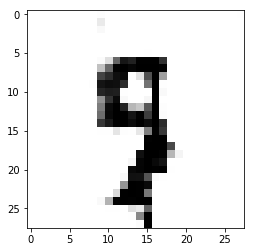

('Estimate:', array([[ 5.67572689]], dtype=float32))


('Iteration:', 73300, 'at', datetime.datetime(2018, 3, 12, 13, 26, 45, 553036))


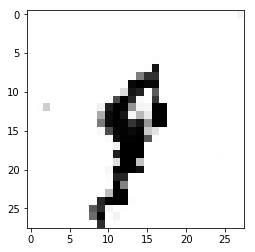

('Estimate:', array([[ 14.06988049]], dtype=float32))


('Iteration:', 73400, 'at', datetime.datetime(2018, 3, 12, 13, 26, 49, 761053))


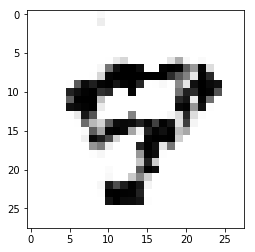

('Estimate:', array([[-10.98320103]], dtype=float32))


('Iteration:', 73500, 'at', datetime.datetime(2018, 3, 12, 13, 26, 53, 960183))


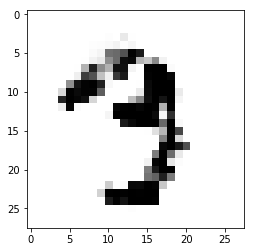

('Estimate:', array([[-0.22277623]], dtype=float32))


('Iteration:', 73600, 'at', datetime.datetime(2018, 3, 12, 13, 26, 58, 105001))


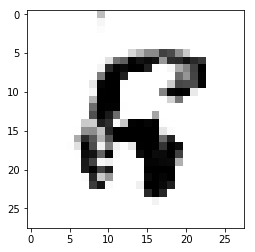

('Estimate:', array([[-2.84170508]], dtype=float32))


('Iteration:', 73700, 'at', datetime.datetime(2018, 3, 12, 13, 27, 2, 314976))


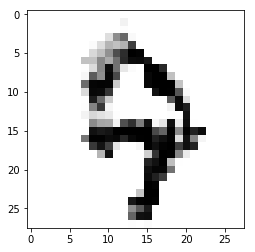

('Estimate:', array([[-4.94599628]], dtype=float32))


('Iteration:', 73800, 'at', datetime.datetime(2018, 3, 12, 13, 27, 6, 552005))


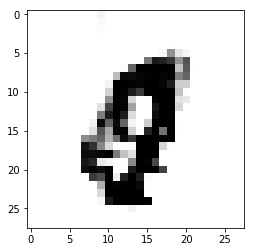

('Estimate:', array([[-16.52481651]], dtype=float32))


('Iteration:', 73900, 'at', datetime.datetime(2018, 3, 12, 13, 27, 10, 739948))


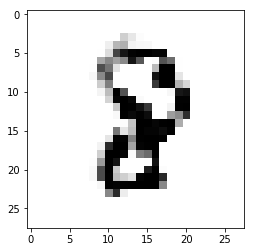

('Estimate:', array([[ 7.55368853]], dtype=float32))


('Iteration:', 74000, 'at', datetime.datetime(2018, 3, 12, 13, 27, 14, 809877))


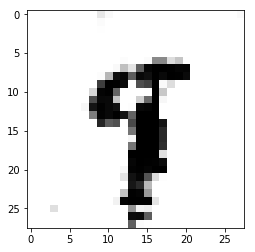

('Estimate:', array([[ 7.05427599]], dtype=float32))


('Iteration:', 74100, 'at', datetime.datetime(2018, 3, 12, 13, 27, 19, 6781))


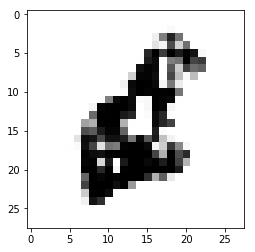

('Estimate:', array([[ 30.90228653]], dtype=float32))


('Iteration:', 74200, 'at', datetime.datetime(2018, 3, 12, 13, 27, 23, 197631))


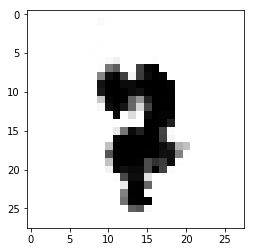

('Estimate:', array([[ 11.34571648]], dtype=float32))


('Iteration:', 74300, 'at', datetime.datetime(2018, 3, 12, 13, 27, 27, 485381))


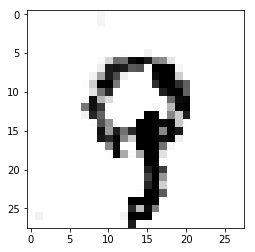

('Estimate:', array([[ 20.53957939]], dtype=float32))


('Iteration:', 74400, 'at', datetime.datetime(2018, 3, 12, 13, 27, 31, 804791))


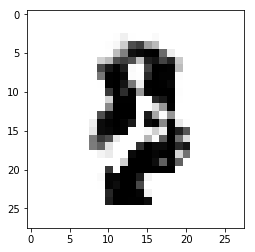

('Estimate:', array([[-9.48805141]], dtype=float32))


('Iteration:', 74500, 'at', datetime.datetime(2018, 3, 12, 13, 27, 36, 122854))


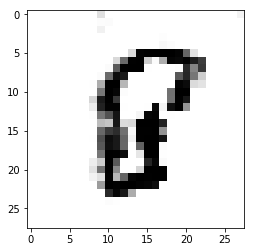

('Estimate:', array([[-11.88746357]], dtype=float32))


('Iteration:', 74600, 'at', datetime.datetime(2018, 3, 12, 13, 27, 40, 333530))


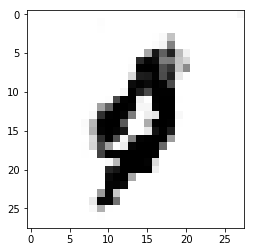

('Estimate:', array([[-0.36310211]], dtype=float32))


('Iteration:', 74700, 'at', datetime.datetime(2018, 3, 12, 13, 27, 44, 526937))


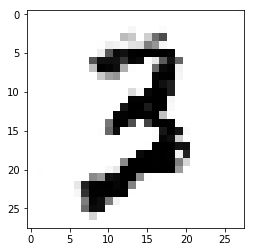

('Estimate:', array([[ 8.64118004]], dtype=float32))


('Iteration:', 74800, 'at', datetime.datetime(2018, 3, 12, 13, 27, 48, 699859))


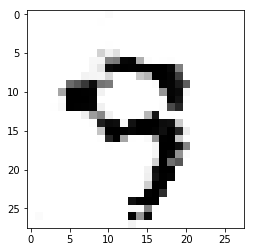

('Estimate:', array([[ 1.19855225]], dtype=float32))


('Iteration:', 74900, 'at', datetime.datetime(2018, 3, 12, 13, 27, 53, 936290))


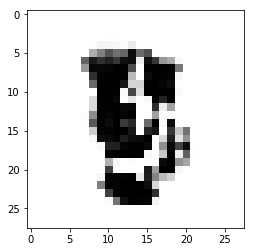

('Estimate:', array([[ 0.17468683]], dtype=float32))


('Iteration:', 75000, 'at', datetime.datetime(2018, 3, 12, 13, 27, 58, 280333))


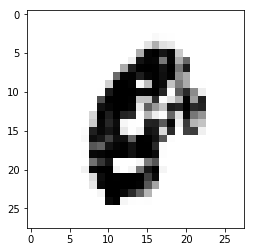

('Estimate:', array([[-12.63843155]], dtype=float32))


('Iteration:', 75100, 'at', datetime.datetime(2018, 3, 12, 13, 28, 2, 680730))


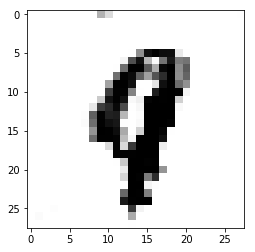

('Estimate:', array([[-6.85360384]], dtype=float32))


('Iteration:', 75200, 'at', datetime.datetime(2018, 3, 12, 13, 28, 6, 967836))


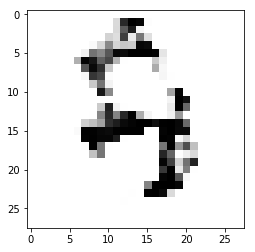

('Estimate:', array([[ 4.25224113]], dtype=float32))


('Iteration:', 75300, 'at', datetime.datetime(2018, 3, 12, 13, 28, 11, 218437))


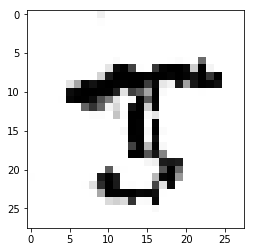

('Estimate:', array([[ 39.66554642]], dtype=float32))


('Iteration:', 75400, 'at', datetime.datetime(2018, 3, 12, 13, 28, 15, 530717))


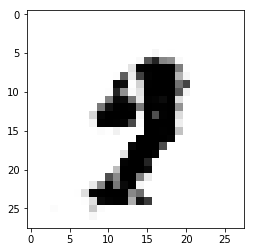

('Estimate:', array([[-0.580836]], dtype=float32))


('Iteration:', 75500, 'at', datetime.datetime(2018, 3, 12, 13, 28, 19, 853638))


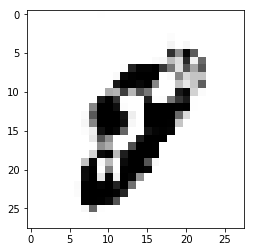

('Estimate:', array([[-7.84869862]], dtype=float32))


('Iteration:', 75600, 'at', datetime.datetime(2018, 3, 12, 13, 28, 24, 222393))


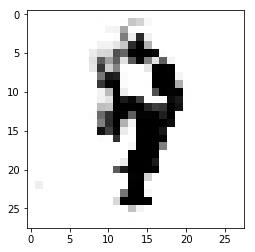

('Estimate:', array([[-10.15678596]], dtype=float32))


('Iteration:', 75700, 'at', datetime.datetime(2018, 3, 12, 13, 28, 28, 451447))


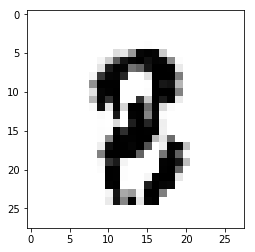

('Estimate:', array([[ 8.7108736]], dtype=float32))


('Iteration:', 75800, 'at', datetime.datetime(2018, 3, 12, 13, 28, 32, 689574))


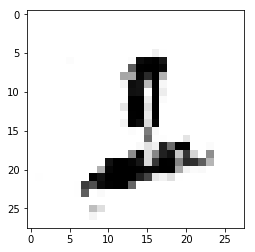

('Estimate:', array([[ 38.21335983]], dtype=float32))


('Iteration:', 75900, 'at', datetime.datetime(2018, 3, 12, 13, 28, 37, 18532))


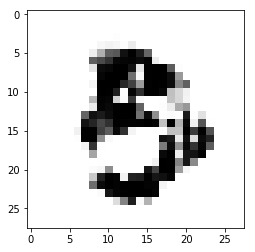

('Estimate:', array([[ 10.19385242]], dtype=float32))


('Iteration:', 76000, 'at', datetime.datetime(2018, 3, 12, 13, 28, 41, 452689))


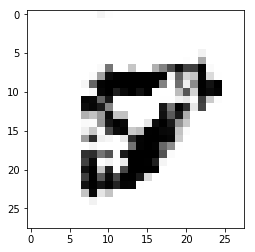

('Estimate:', array([[ 0.57549119]], dtype=float32))


('Iteration:', 76100, 'at', datetime.datetime(2018, 3, 12, 13, 28, 45, 785742))


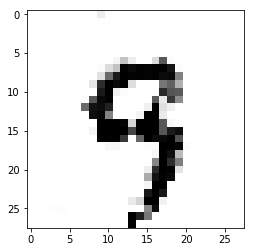

('Estimate:', array([[ 15.96280766]], dtype=float32))


('Iteration:', 76200, 'at', datetime.datetime(2018, 3, 12, 13, 28, 50, 57139))


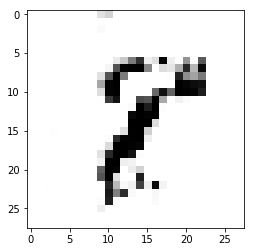

('Estimate:', array([[ 21.55023766]], dtype=float32))


('Iteration:', 76300, 'at', datetime.datetime(2018, 3, 12, 13, 28, 54, 471581))


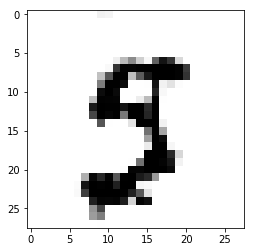

('Estimate:', array([[-3.61902618]], dtype=float32))


('Iteration:', 76400, 'at', datetime.datetime(2018, 3, 12, 13, 28, 58, 945760))


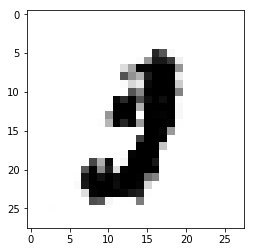

('Estimate:', array([[-11.12693405]], dtype=float32))


('Iteration:', 76500, 'at', datetime.datetime(2018, 3, 12, 13, 29, 3, 255456))


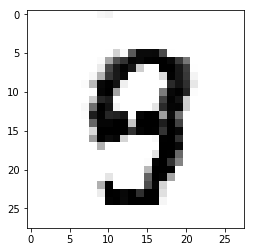

('Estimate:', array([[-7.44770956]], dtype=float32))


('Iteration:', 76600, 'at', datetime.datetime(2018, 3, 12, 13, 29, 7, 549929))


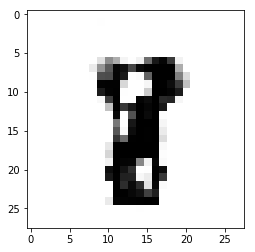

('Estimate:', array([[ 8.49028587]], dtype=float32))


('Iteration:', 76700, 'at', datetime.datetime(2018, 3, 12, 13, 29, 11, 962770))


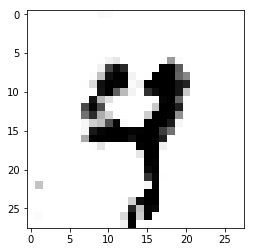

('Estimate:', array([[ 13.66307163]], dtype=float32))


('Iteration:', 76800, 'at', datetime.datetime(2018, 3, 12, 13, 29, 16, 439211))


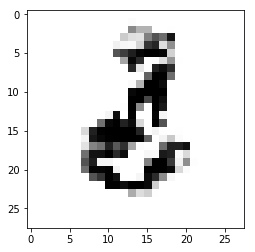

('Estimate:', array([[ 0.19099388]], dtype=float32))


('Iteration:', 76900, 'at', datetime.datetime(2018, 3, 12, 13, 29, 20, 788216))


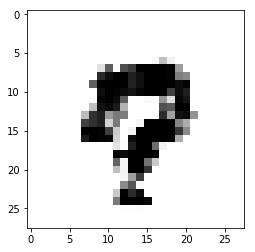

('Estimate:', array([[-4.34493446]], dtype=float32))


('Iteration:', 77000, 'at', datetime.datetime(2018, 3, 12, 13, 29, 25, 107570))


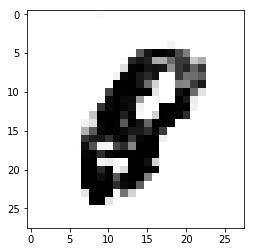

('Estimate:', array([[-12.66202545]], dtype=float32))


('Iteration:', 77100, 'at', datetime.datetime(2018, 3, 12, 13, 29, 29, 456635))


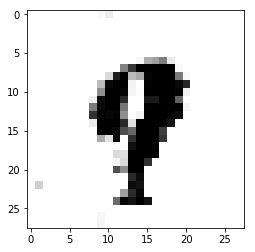

('Estimate:', array([[-2.54842901]], dtype=float32))


('Iteration:', 77200, 'at', datetime.datetime(2018, 3, 12, 13, 29, 33, 667146))


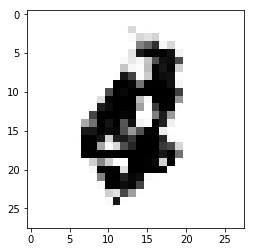

('Estimate:', array([[-7.05183268]], dtype=float32))


('Iteration:', 77300, 'at', datetime.datetime(2018, 3, 12, 13, 29, 38, 12347))


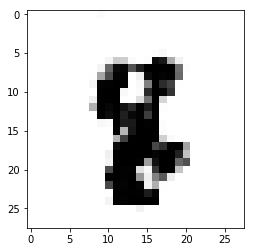

('Estimate:', array([[ 6.03558588]], dtype=float32))


('Iteration:', 77400, 'at', datetime.datetime(2018, 3, 12, 13, 29, 42, 465623))


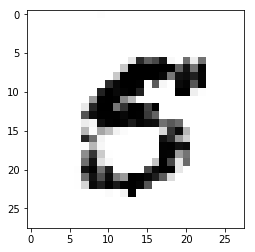

('Estimate:', array([[ 33.0975914]], dtype=float32))


('Iteration:', 77500, 'at', datetime.datetime(2018, 3, 12, 13, 29, 46, 791711))


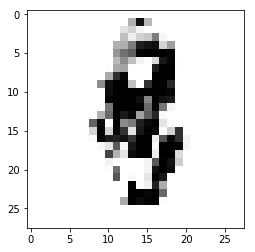

('Estimate:', array([[-0.56081402]], dtype=float32))


('Iteration:', 77600, 'at', datetime.datetime(2018, 3, 12, 13, 29, 51, 175289))


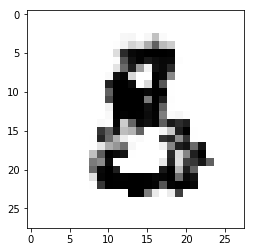

('Estimate:', array([[-7.40394306]], dtype=float32))


('Iteration:', 77700, 'at', datetime.datetime(2018, 3, 12, 13, 29, 55, 449043))


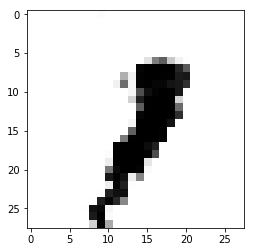

('Estimate:', array([[ 18.74629211]], dtype=float32))


('Iteration:', 77800, 'at', datetime.datetime(2018, 3, 12, 13, 29, 59, 793806))


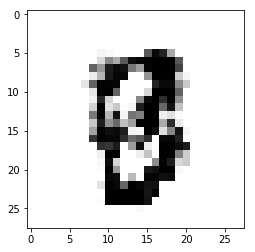

('Estimate:', array([[-22.41205978]], dtype=float32))


('Iteration:', 77900, 'at', datetime.datetime(2018, 3, 12, 13, 30, 4, 96825))


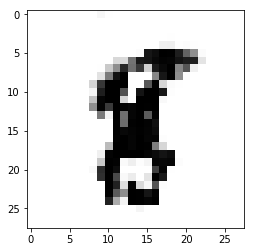

('Estimate:', array([[ 0.39829946]], dtype=float32))


('Iteration:', 78000, 'at', datetime.datetime(2018, 3, 12, 13, 30, 8, 367047))


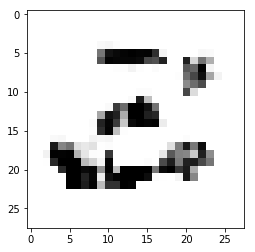

('Estimate:', array([[ 34.79312897]], dtype=float32))


('Iteration:', 78100, 'at', datetime.datetime(2018, 3, 12, 13, 30, 12, 605538))


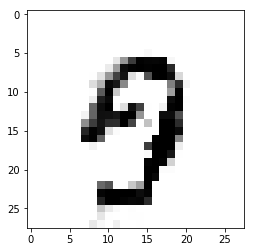

('Estimate:', array([[ 14.33977699]], dtype=float32))


('Iteration:', 78200, 'at', datetime.datetime(2018, 3, 12, 13, 30, 16, 887318))


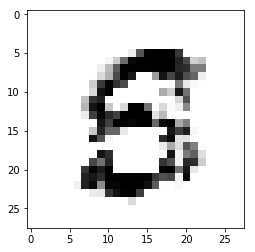

('Estimate:', array([[-5.11344576]], dtype=float32))


('Iteration:', 78300, 'at', datetime.datetime(2018, 3, 12, 13, 30, 21, 221634))


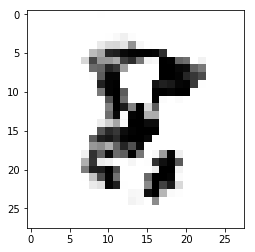

('Estimate:', array([[ 10.06339741]], dtype=float32))


('Iteration:', 78400, 'at', datetime.datetime(2018, 3, 12, 13, 30, 25, 527832))


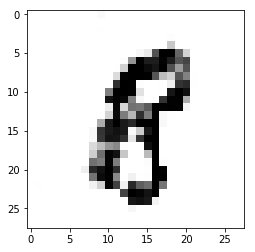

('Estimate:', array([[ 12.86048698]], dtype=float32))


('Iteration:', 78500, 'at', datetime.datetime(2018, 3, 12, 13, 30, 29, 875680))


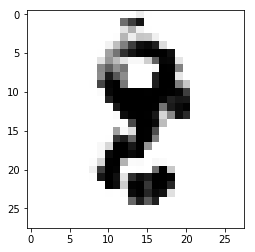

('Estimate:', array([[ 12.76443481]], dtype=float32))


('Iteration:', 78600, 'at', datetime.datetime(2018, 3, 12, 13, 30, 34, 193979))


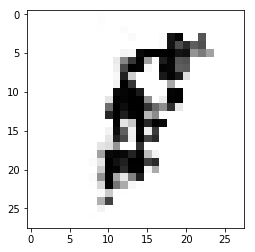

('Estimate:', array([[-16.7986412]], dtype=float32))


('Iteration:', 78700, 'at', datetime.datetime(2018, 3, 12, 13, 30, 38, 496213))


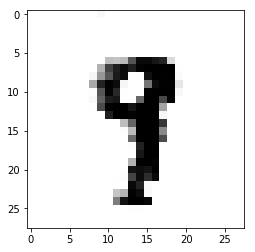

('Estimate:', array([[ 23.1299305]], dtype=float32))


('Iteration:', 78800, 'at', datetime.datetime(2018, 3, 12, 13, 30, 42, 820945))


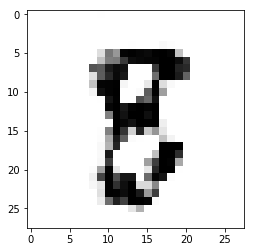

('Estimate:', array([[-2.95069265]], dtype=float32))


('Iteration:', 78900, 'at', datetime.datetime(2018, 3, 12, 13, 30, 47, 148568))


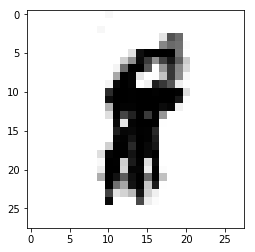

('Estimate:', array([[ 15.17540932]], dtype=float32))


('Iteration:', 79000, 'at', datetime.datetime(2018, 3, 12, 13, 30, 51, 481340))


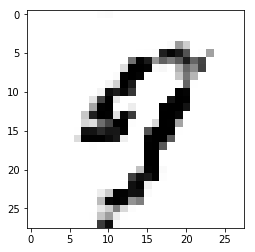

('Estimate:', array([[ 2.9591825]], dtype=float32))


('Iteration:', 79100, 'at', datetime.datetime(2018, 3, 12, 13, 30, 55, 832577))


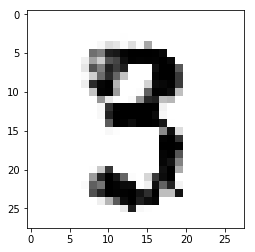

('Estimate:', array([[ 19.21306992]], dtype=float32))


('Iteration:', 79200, 'at', datetime.datetime(2018, 3, 12, 13, 31, 0, 301938))


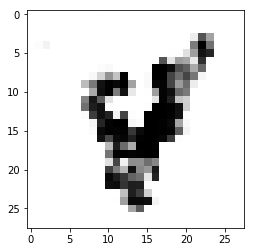

('Estimate:', array([[ 14.0953083]], dtype=float32))


('Iteration:', 79300, 'at', datetime.datetime(2018, 3, 12, 13, 31, 4, 717871))


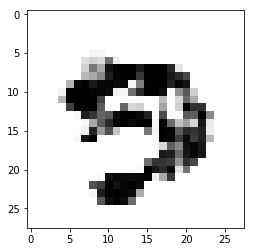

('Estimate:', array([[ 6.90860224]], dtype=float32))


('Iteration:', 79400, 'at', datetime.datetime(2018, 3, 12, 13, 31, 9, 65972))


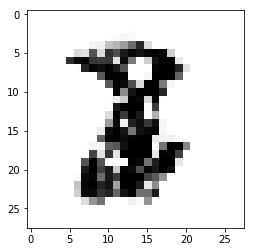

('Estimate:', array([[-1.95351505]], dtype=float32))


('Iteration:', 79500, 'at', datetime.datetime(2018, 3, 12, 13, 31, 13, 391872))


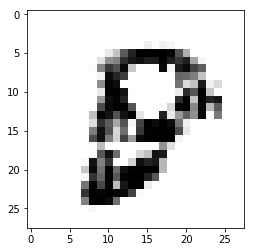

('Estimate:', array([[ 36.12633514]], dtype=float32))


('Iteration:', 79600, 'at', datetime.datetime(2018, 3, 12, 13, 31, 17, 799555))


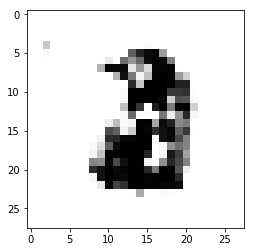

('Estimate:', array([[-3.64927959]], dtype=float32))


('Iteration:', 79700, 'at', datetime.datetime(2018, 3, 12, 13, 31, 22, 161024))


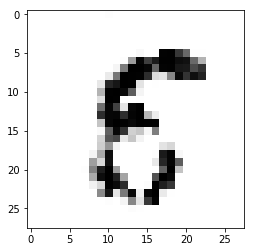

('Estimate:', array([[-10.97044373]], dtype=float32))


('Iteration:', 79800, 'at', datetime.datetime(2018, 3, 12, 13, 31, 26, 523867))


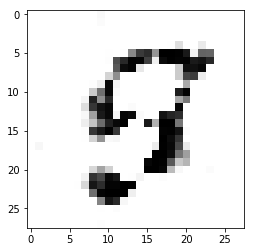

('Estimate:', array([[ 8.10659599]], dtype=float32))


('Iteration:', 79900, 'at', datetime.datetime(2018, 3, 12, 13, 31, 30, 861399))


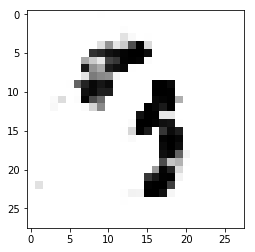

('Estimate:', array([[-23.43098259]], dtype=float32))


('Iteration:', 80000, 'at', datetime.datetime(2018, 3, 12, 13, 31, 35, 223936))


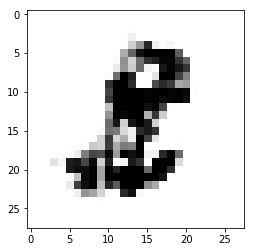

('Estimate:', array([[ 2.79242086]], dtype=float32))


('Iteration:', 80100, 'at', datetime.datetime(2018, 3, 12, 13, 31, 39, 602040))


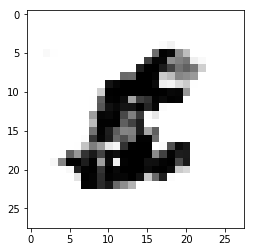

('Estimate:', array([[ 14.24398899]], dtype=float32))


('Iteration:', 80200, 'at', datetime.datetime(2018, 3, 12, 13, 31, 44, 10176))


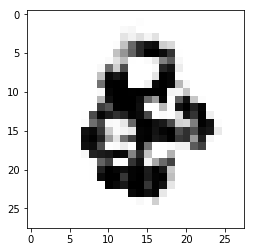

('Estimate:', array([[ 11.20314312]], dtype=float32))


('Iteration:', 80300, 'at', datetime.datetime(2018, 3, 12, 13, 31, 48, 350557))


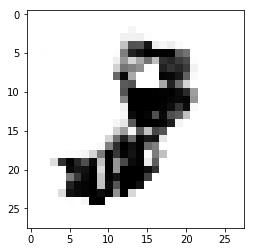

('Estimate:', array([[ 3.73341179]], dtype=float32))


('Iteration:', 80400, 'at', datetime.datetime(2018, 3, 12, 13, 31, 52, 795618))


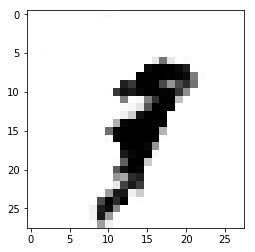

('Estimate:', array([[-1.78310168]], dtype=float32))


('Iteration:', 80500, 'at', datetime.datetime(2018, 3, 12, 13, 31, 57, 80188))


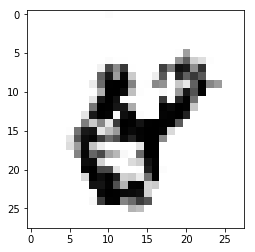

('Estimate:', array([[-3.54327083]], dtype=float32))


('Iteration:', 80600, 'at', datetime.datetime(2018, 3, 12, 13, 32, 1, 392801))


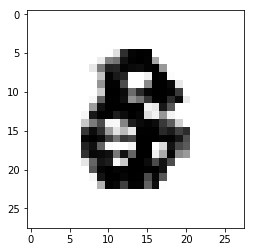

('Estimate:', array([[-3.03334594]], dtype=float32))


('Iteration:', 80700, 'at', datetime.datetime(2018, 3, 12, 13, 32, 5, 696654))


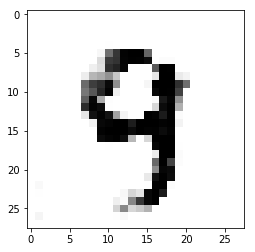

('Estimate:', array([[ 18.96866035]], dtype=float32))


('Iteration:', 80800, 'at', datetime.datetime(2018, 3, 12, 13, 32, 10, 34135))


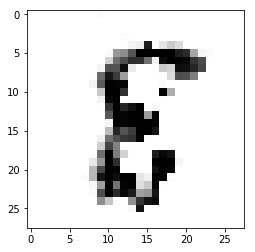

('Estimate:', array([[-0.73968816]], dtype=float32))


('Iteration:', 80900, 'at', datetime.datetime(2018, 3, 12, 13, 32, 14, 385490))


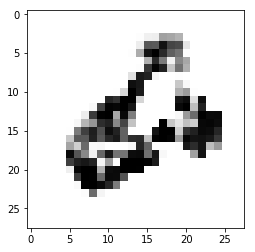

('Estimate:', array([[ 1.50152993]], dtype=float32))


('Iteration:', 81000, 'at', datetime.datetime(2018, 3, 12, 13, 32, 18, 700441))


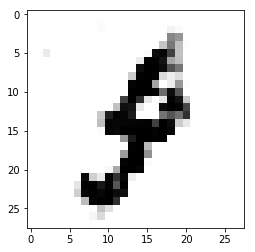

('Estimate:', array([[ 14.00523472]], dtype=float32))


('Iteration:', 81100, 'at', datetime.datetime(2018, 3, 12, 13, 32, 23, 10277))


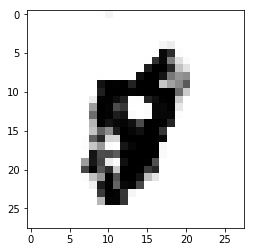

('Estimate:', array([[-10.96600342]], dtype=float32))


('Iteration:', 81200, 'at', datetime.datetime(2018, 3, 12, 13, 32, 27, 281113))


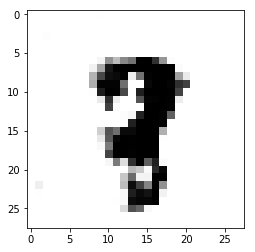

('Estimate:', array([[-6.10187054]], dtype=float32))


('Iteration:', 81300, 'at', datetime.datetime(2018, 3, 12, 13, 32, 31, 608371))


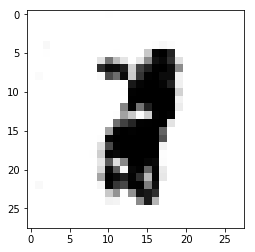

('Estimate:', array([[ 15.89711094]], dtype=float32))


('Iteration:', 81400, 'at', datetime.datetime(2018, 3, 12, 13, 32, 35, 946995))


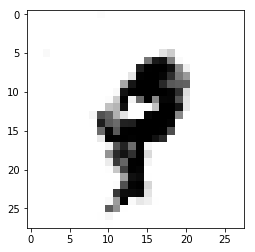

('Estimate:', array([[ 0.88728911]], dtype=float32))


('Iteration:', 81500, 'at', datetime.datetime(2018, 3, 12, 13, 32, 40, 233309))


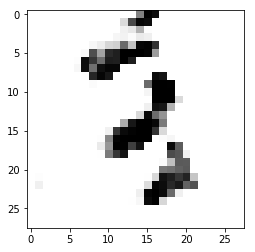

('Estimate:', array([[-0.13186306]], dtype=float32))


('Iteration:', 81600, 'at', datetime.datetime(2018, 3, 12, 13, 32, 44, 507602))


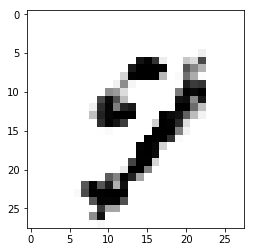

('Estimate:', array([[ 1.10133088]], dtype=float32))


('Iteration:', 81700, 'at', datetime.datetime(2018, 3, 12, 13, 32, 48, 853420))


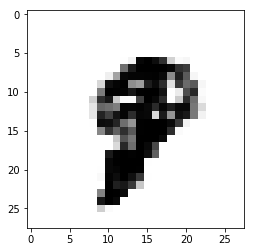

('Estimate:', array([[-16.50862312]], dtype=float32))


('Iteration:', 81800, 'at', datetime.datetime(2018, 3, 12, 13, 32, 53, 238798))


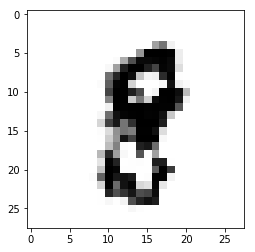

('Estimate:', array([[ 16.18231392]], dtype=float32))


('Iteration:', 81900, 'at', datetime.datetime(2018, 3, 12, 13, 32, 57, 517212))


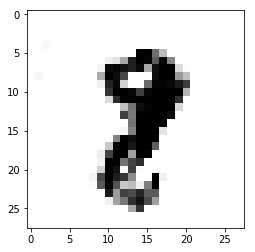

('Estimate:', array([[-3.23843884]], dtype=float32))


('Iteration:', 82000, 'at', datetime.datetime(2018, 3, 12, 13, 33, 1, 764361))


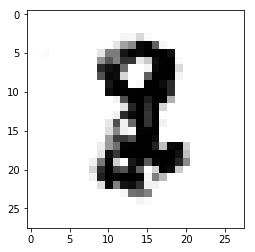

('Estimate:', array([[ 15.87438679]], dtype=float32))


('Iteration:', 82100, 'at', datetime.datetime(2018, 3, 12, 13, 33, 6, 185206))


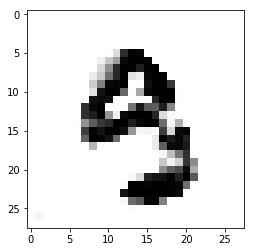

('Estimate:', array([[-3.4386127]], dtype=float32))


('Iteration:', 82200, 'at', datetime.datetime(2018, 3, 12, 13, 33, 10, 650226))


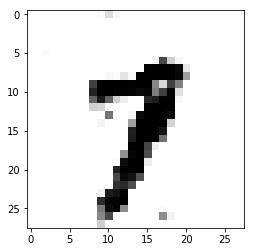

('Estimate:', array([[ 8.32289314]], dtype=float32))


('Iteration:', 82300, 'at', datetime.datetime(2018, 3, 12, 13, 33, 15, 68587))


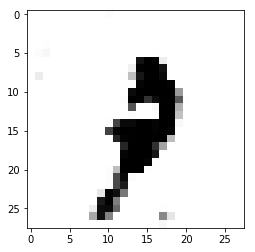

('Estimate:', array([[ 11.30727291]], dtype=float32))


('Iteration:', 82400, 'at', datetime.datetime(2018, 3, 12, 13, 33, 19, 488891))


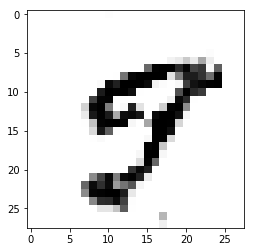

('Estimate:', array([[ 10.07501793]], dtype=float32))


('Iteration:', 82500, 'at', datetime.datetime(2018, 3, 12, 13, 33, 23, 999419))


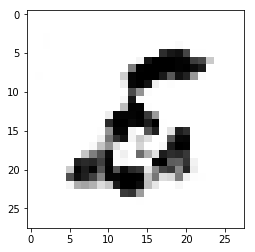

('Estimate:', array([[ 8.65737343]], dtype=float32))


('Iteration:', 82600, 'at', datetime.datetime(2018, 3, 12, 13, 33, 28, 524300))


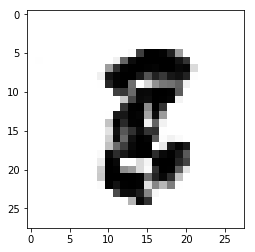

('Estimate:', array([[-12.57678127]], dtype=float32))


('Iteration:', 82700, 'at', datetime.datetime(2018, 3, 12, 13, 33, 32, 878104))


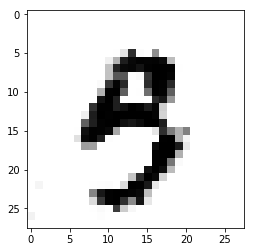

('Estimate:', array([[ 4.70316029]], dtype=float32))


('Iteration:', 82800, 'at', datetime.datetime(2018, 3, 12, 13, 33, 37, 280910))


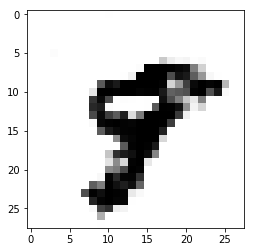

('Estimate:', array([[-3.85643792]], dtype=float32))


('Iteration:', 82900, 'at', datetime.datetime(2018, 3, 12, 13, 33, 41, 847590))


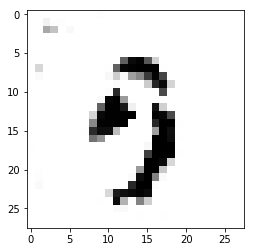

('Estimate:', array([[ 3.25769639]], dtype=float32))


('Iteration:', 83000, 'at', datetime.datetime(2018, 3, 12, 13, 33, 46, 132616))


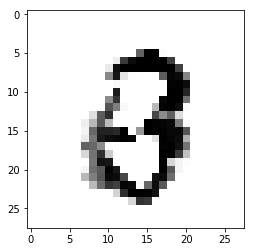

('Estimate:', array([[ 12.52094269]], dtype=float32))


('Iteration:', 83100, 'at', datetime.datetime(2018, 3, 12, 13, 33, 50, 542445))


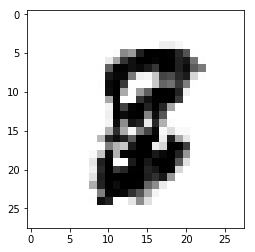

('Estimate:', array([[-14.14426994]], dtype=float32))


('Iteration:', 83200, 'at', datetime.datetime(2018, 3, 12, 13, 33, 54, 889772))


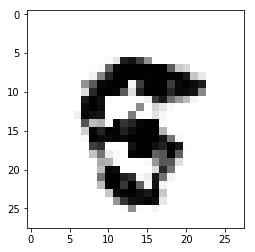

('Estimate:', array([[ 5.99744558]], dtype=float32))


('Iteration:', 83300, 'at', datetime.datetime(2018, 3, 12, 13, 33, 59, 335587))


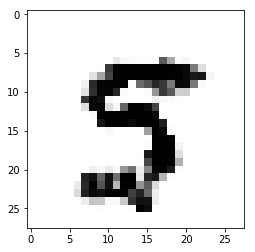

('Estimate:', array([[ 10.49894714]], dtype=float32))


('Iteration:', 83400, 'at', datetime.datetime(2018, 3, 12, 13, 34, 3, 666344))


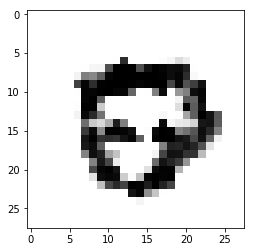

('Estimate:', array([[ 3.44499397]], dtype=float32))


('Iteration:', 83500, 'at', datetime.datetime(2018, 3, 12, 13, 34, 8, 15402))


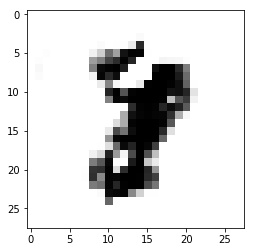

('Estimate:', array([[-17.28619766]], dtype=float32))


('Iteration:', 83600, 'at', datetime.datetime(2018, 3, 12, 13, 34, 12, 486860))


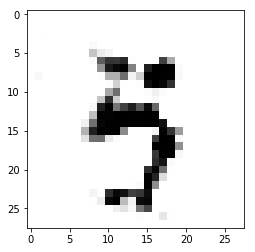

('Estimate:', array([[ 17.36249352]], dtype=float32))


('Iteration:', 83700, 'at', datetime.datetime(2018, 3, 12, 13, 34, 16, 968262))


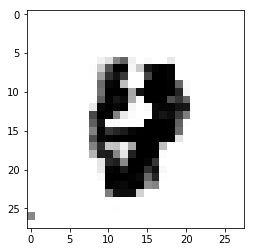

('Estimate:', array([[-4.67984152]], dtype=float32))


('Iteration:', 83800, 'at', datetime.datetime(2018, 3, 12, 13, 34, 21, 377276))


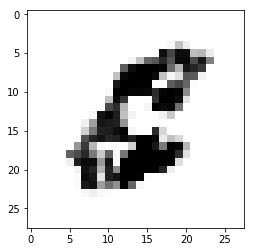

('Estimate:', array([[ 2.28964353]], dtype=float32))


('Iteration:', 83900, 'at', datetime.datetime(2018, 3, 12, 13, 34, 25, 753287))


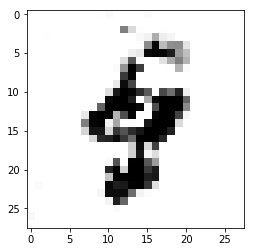

('Estimate:', array([[-23.64141464]], dtype=float32))


('Iteration:', 84000, 'at', datetime.datetime(2018, 3, 12, 13, 34, 30, 107803))


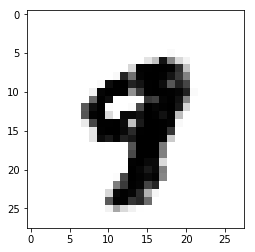

('Estimate:', array([[ 7.39963436]], dtype=float32))


('Iteration:', 84100, 'at', datetime.datetime(2018, 3, 12, 13, 34, 34, 479346))


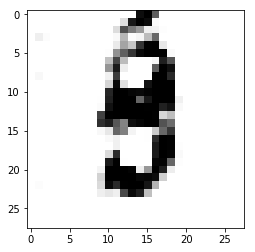

('Estimate:', array([[ 14.02497387]], dtype=float32))


('Iteration:', 84200, 'at', datetime.datetime(2018, 3, 12, 13, 34, 38, 890040))


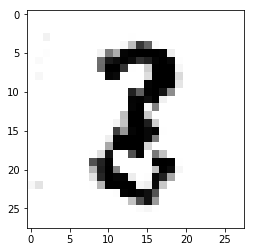

('Estimate:', array([[ 16.5756321]], dtype=float32))


('Iteration:', 84300, 'at', datetime.datetime(2018, 3, 12, 13, 34, 43, 219673))


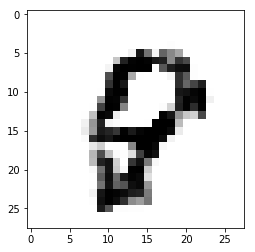

('Estimate:', array([[ 10.95149231]], dtype=float32))


('Iteration:', 84400, 'at', datetime.datetime(2018, 3, 12, 13, 34, 47, 517469))


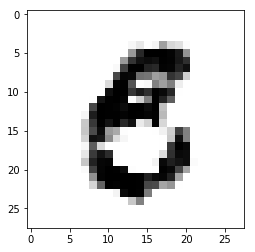

('Estimate:', array([[-8.52252674]], dtype=float32))


('Iteration:', 84500, 'at', datetime.datetime(2018, 3, 12, 13, 34, 51, 976534))


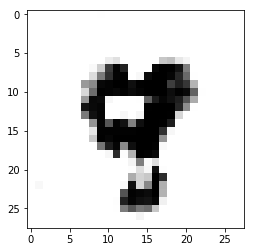

('Estimate:', array([[ 3.89142013]], dtype=float32))


('Iteration:', 84600, 'at', datetime.datetime(2018, 3, 12, 13, 34, 56, 326289))


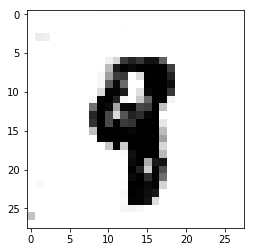

('Estimate:', array([[ 3.21437001]], dtype=float32))


('Iteration:', 84700, 'at', datetime.datetime(2018, 3, 12, 13, 35, 0, 708219))


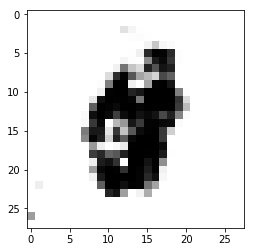

('Estimate:', array([[-3.6777432]], dtype=float32))


('Iteration:', 84800, 'at', datetime.datetime(2018, 3, 12, 13, 35, 5, 153210))


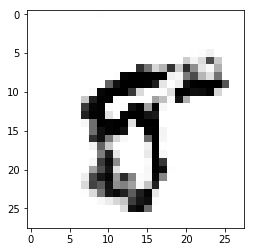

('Estimate:', array([[-14.58339214]], dtype=float32))


('Iteration:', 84900, 'at', datetime.datetime(2018, 3, 12, 13, 35, 9, 536581))


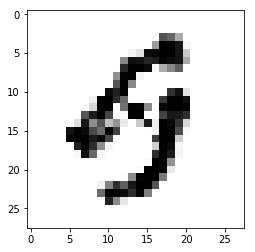

('Estimate:', array([[-9.31528091]], dtype=float32))


('Iteration:', 85000, 'at', datetime.datetime(2018, 3, 12, 13, 35, 13, 854861))


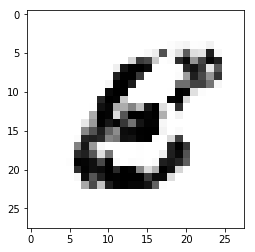

('Estimate:', array([[-9.04759502]], dtype=float32))


('Iteration:', 85100, 'at', datetime.datetime(2018, 3, 12, 13, 35, 18, 185893))


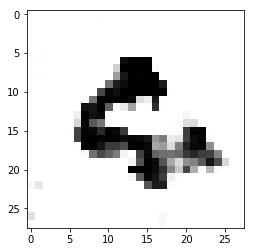

('Estimate:', array([[ 4.66661167]], dtype=float32))


('Iteration:', 85200, 'at', datetime.datetime(2018, 3, 12, 13, 35, 22, 646054))


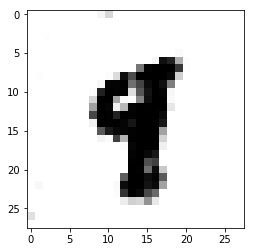

('Estimate:', array([[-2.36558366]], dtype=float32))


('Iteration:', 85300, 'at', datetime.datetime(2018, 3, 12, 13, 35, 27, 9586))


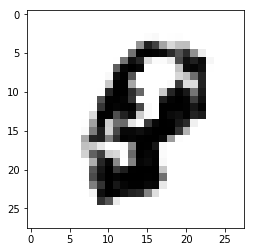

('Estimate:', array([[-9.41219997]], dtype=float32))


('Iteration:', 85400, 'at', datetime.datetime(2018, 3, 12, 13, 35, 31, 357903))


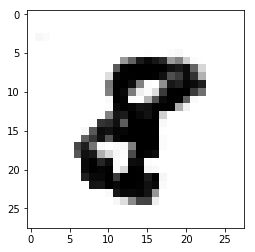

('Estimate:', array([[ 18.09954834]], dtype=float32))


('Iteration:', 85500, 'at', datetime.datetime(2018, 3, 12, 13, 35, 35, 763019))


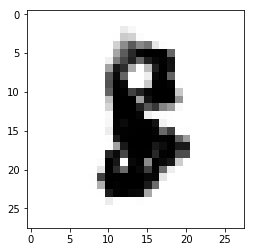

('Estimate:', array([[-1.00138676]], dtype=float32))


('Iteration:', 85600, 'at', datetime.datetime(2018, 3, 12, 13, 35, 40, 89771))


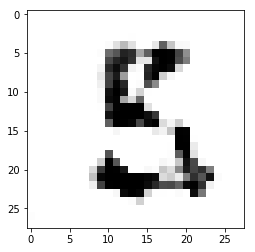

('Estimate:', array([[-2.47596121]], dtype=float32))


('Iteration:', 85700, 'at', datetime.datetime(2018, 3, 12, 13, 35, 44, 480909))


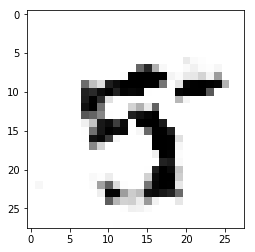

('Estimate:', array([[ 3.50429797]], dtype=float32))


('Iteration:', 85800, 'at', datetime.datetime(2018, 3, 12, 13, 35, 48, 958784))


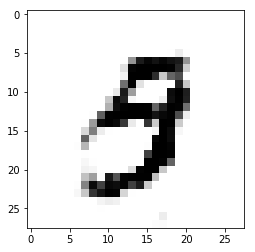

('Estimate:', array([[-13.7172718]], dtype=float32))


('Iteration:', 85900, 'at', datetime.datetime(2018, 3, 12, 13, 35, 53, 363370))


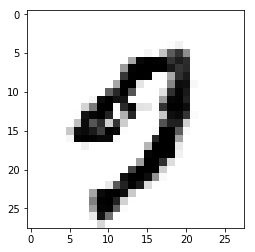

('Estimate:', array([[ 12.21457958]], dtype=float32))


('Iteration:', 86000, 'at', datetime.datetime(2018, 3, 12, 13, 35, 57, 853322))


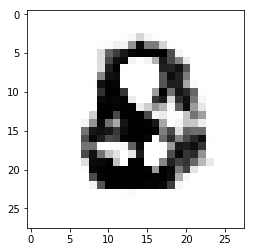

('Estimate:', array([[-12.52315044]], dtype=float32))


('Iteration:', 86100, 'at', datetime.datetime(2018, 3, 12, 13, 36, 2, 296953))


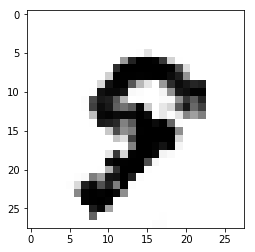

('Estimate:', array([[-1.11089611]], dtype=float32))


('Iteration:', 86200, 'at', datetime.datetime(2018, 3, 12, 13, 36, 6, 709223))


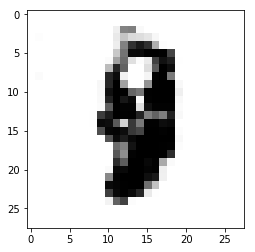

('Estimate:', array([[-9.12284756]], dtype=float32))


('Iteration:', 86300, 'at', datetime.datetime(2018, 3, 12, 13, 36, 11, 66640))


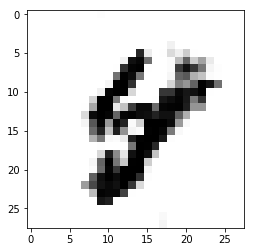

('Estimate:', array([[-8.83731365]], dtype=float32))


('Iteration:', 86400, 'at', datetime.datetime(2018, 3, 12, 13, 36, 16, 716800))


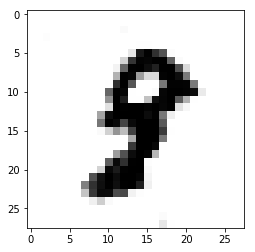

('Estimate:', array([[-6.46707106]], dtype=float32))


('Iteration:', 86500, 'at', datetime.datetime(2018, 3, 12, 13, 36, 21, 256045))


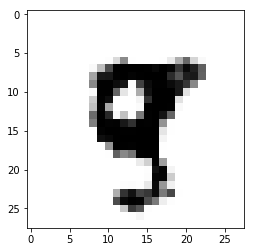

('Estimate:', array([[-2.91500354]], dtype=float32))


('Iteration:', 86600, 'at', datetime.datetime(2018, 3, 12, 13, 36, 25, 793992))


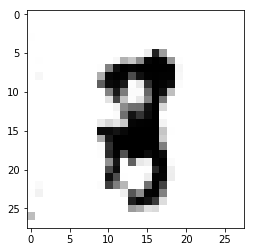

('Estimate:', array([[-17.50370979]], dtype=float32))


('Iteration:', 86700, 'at', datetime.datetime(2018, 3, 12, 13, 36, 30, 367044))


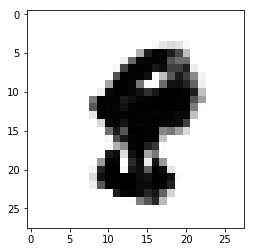

('Estimate:', array([[-7.55064154]], dtype=float32))


('Iteration:', 86800, 'at', datetime.datetime(2018, 3, 12, 13, 36, 34, 844664))


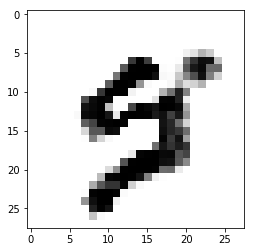

('Estimate:', array([[ 14.86243629]], dtype=float32))


('Iteration:', 86900, 'at', datetime.datetime(2018, 3, 12, 13, 36, 39, 421472))


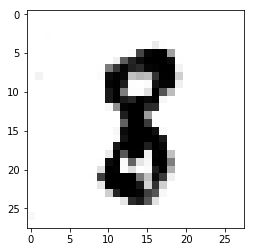

('Estimate:', array([[ 3.93587995]], dtype=float32))


('Iteration:', 87000, 'at', datetime.datetime(2018, 3, 12, 13, 36, 43, 986382))


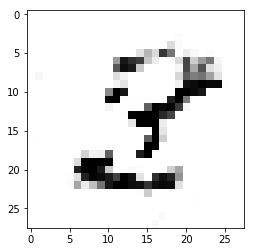

('Estimate:', array([[-17.64478493]], dtype=float32))


('Iteration:', 87100, 'at', datetime.datetime(2018, 3, 12, 13, 36, 48, 527092))


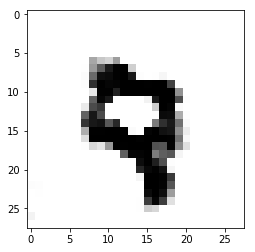

('Estimate:', array([[ 24.79298019]], dtype=float32))


('Iteration:', 87200, 'at', datetime.datetime(2018, 3, 12, 13, 36, 53, 84692))


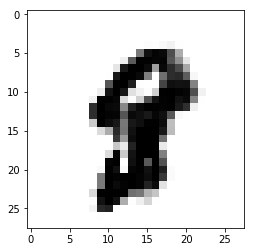

('Estimate:', array([[ 7.98845053]], dtype=float32))


('Iteration:', 87300, 'at', datetime.datetime(2018, 3, 12, 13, 36, 57, 647291))


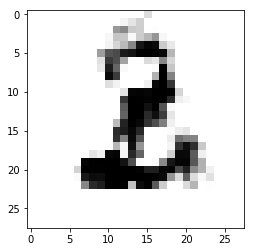

('Estimate:', array([[-24.1816349]], dtype=float32))


('Iteration:', 87400, 'at', datetime.datetime(2018, 3, 12, 13, 37, 2, 230098))


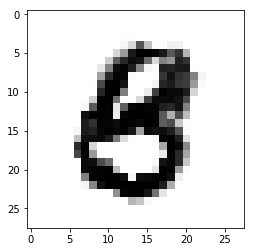

('Estimate:', array([[-2.67105365]], dtype=float32))


('Iteration:', 87500, 'at', datetime.datetime(2018, 3, 12, 13, 37, 6, 920612))


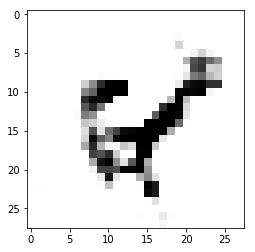

('Estimate:', array([[ 15.18018055]], dtype=float32))


('Iteration:', 87600, 'at', datetime.datetime(2018, 3, 12, 13, 37, 11, 573664))


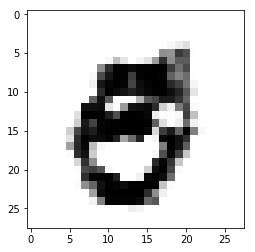

('Estimate:', array([[-25.78075218]], dtype=float32))


('Iteration:', 87700, 'at', datetime.datetime(2018, 3, 12, 13, 37, 16, 219015))


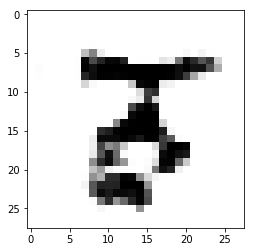

('Estimate:', array([[ 4.09895229]], dtype=float32))


('Iteration:', 87800, 'at', datetime.datetime(2018, 3, 12, 13, 37, 20, 839278))


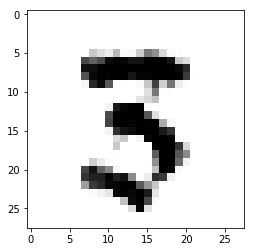

('Estimate:', array([[-12.37383747]], dtype=float32))


('Iteration:', 87900, 'at', datetime.datetime(2018, 3, 12, 13, 37, 25, 495143))


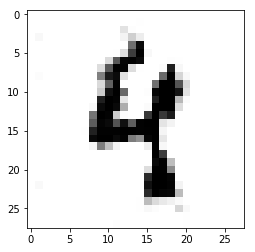

('Estimate:', array([[ 10.57196808]], dtype=float32))


('Iteration:', 88000, 'at', datetime.datetime(2018, 3, 12, 13, 37, 30, 113517))


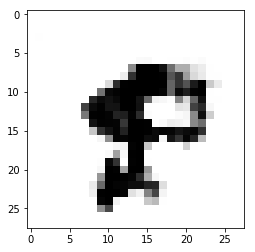

('Estimate:', array([[-3.34345007]], dtype=float32))


('Iteration:', 88100, 'at', datetime.datetime(2018, 3, 12, 13, 37, 34, 606609))


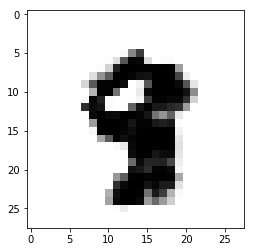

('Estimate:', array([[-11.32110405]], dtype=float32))


('Iteration:', 88200, 'at', datetime.datetime(2018, 3, 12, 13, 37, 39, 111759))


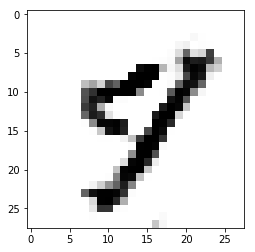

('Estimate:', array([[ 0.93367898]], dtype=float32))


('Iteration:', 88300, 'at', datetime.datetime(2018, 3, 12, 13, 37, 43, 602954))


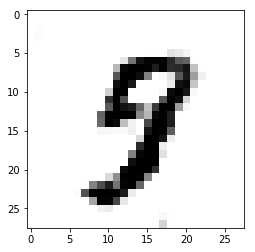

('Estimate:', array([[ 5.97421646]], dtype=float32))


('Iteration:', 88400, 'at', datetime.datetime(2018, 3, 12, 13, 37, 48, 137011))


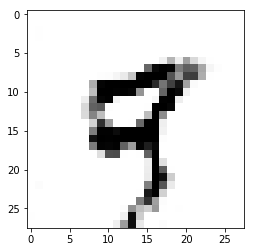

('Estimate:', array([[-7.35096931]], dtype=float32))


('Iteration:', 88500, 'at', datetime.datetime(2018, 3, 12, 13, 37, 52, 622265))


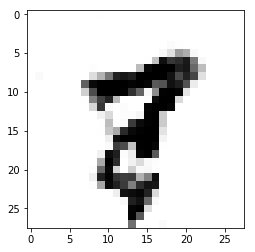

('Estimate:', array([[-26.52449989]], dtype=float32))


('Iteration:', 88600, 'at', datetime.datetime(2018, 3, 12, 13, 37, 57, 94935))


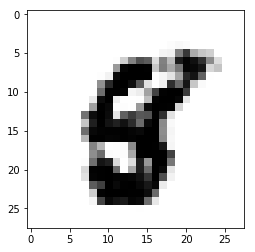

('Estimate:', array([[ 3.40303588]], dtype=float32))


('Iteration:', 88700, 'at', datetime.datetime(2018, 3, 12, 13, 38, 1, 564321))


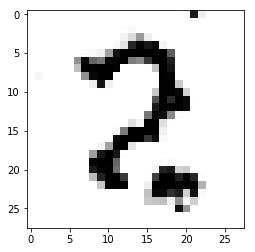

('Estimate:', array([[ 8.79854393]], dtype=float32))


('Iteration:', 88800, 'at', datetime.datetime(2018, 3, 12, 13, 38, 6, 38042))


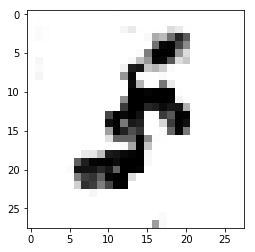

('Estimate:', array([[-3.18658447]], dtype=float32))


('Iteration:', 88900, 'at', datetime.datetime(2018, 3, 12, 13, 38, 10, 461170))


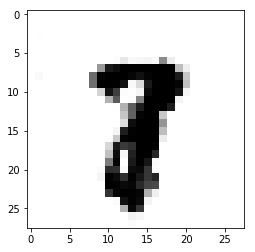

('Estimate:', array([[-1.32605517]], dtype=float32))


('Iteration:', 89000, 'at', datetime.datetime(2018, 3, 12, 13, 38, 14, 893473))


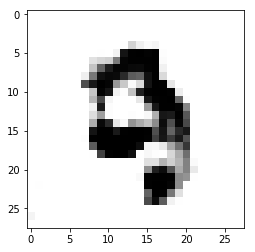

('Estimate:', array([[ 6.30075169]], dtype=float32))


('Iteration:', 89100, 'at', datetime.datetime(2018, 3, 12, 13, 38, 19, 400802))


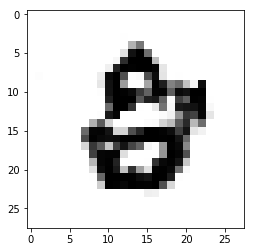

('Estimate:', array([[ 8.52873135]], dtype=float32))


('Iteration:', 89200, 'at', datetime.datetime(2018, 3, 12, 13, 38, 23, 915242))


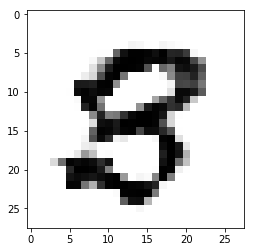

('Estimate:', array([[-6.59137106]], dtype=float32))


('Iteration:', 89300, 'at', datetime.datetime(2018, 3, 12, 13, 38, 28, 557749))


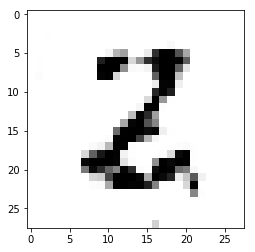

('Estimate:', array([[-6.41326427]], dtype=float32))


('Iteration:', 89400, 'at', datetime.datetime(2018, 3, 12, 13, 38, 33, 131620))


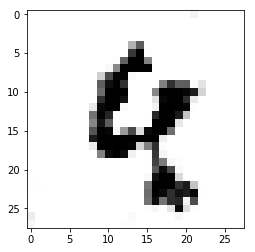

('Estimate:', array([[ 0.11901049]], dtype=float32))


('Iteration:', 89500, 'at', datetime.datetime(2018, 3, 12, 13, 38, 37, 632573))


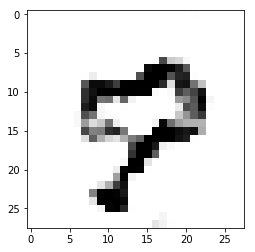

('Estimate:', array([[-2.12007403]], dtype=float32))


('Iteration:', 89600, 'at', datetime.datetime(2018, 3, 12, 13, 38, 42, 122523))


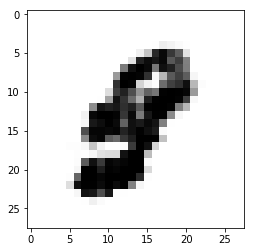

('Estimate:', array([[-13.49875259]], dtype=float32))


('Iteration:', 89700, 'at', datetime.datetime(2018, 3, 12, 13, 38, 46, 647340))


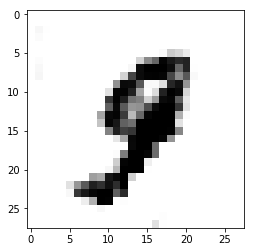

('Estimate:', array([[-11.17180347]], dtype=float32))


('Iteration:', 89800, 'at', datetime.datetime(2018, 3, 12, 13, 38, 51, 201714))


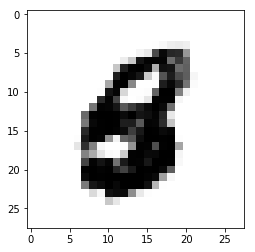

('Estimate:', array([[-14.06212139]], dtype=float32))


('Iteration:', 89900, 'at', datetime.datetime(2018, 3, 12, 13, 38, 55, 736842))


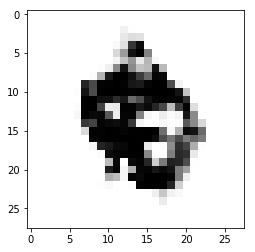

('Estimate:', array([[ 4.22356272]], dtype=float32))


('Iteration:', 90000, 'at', datetime.datetime(2018, 3, 12, 13, 39, 0, 294102))


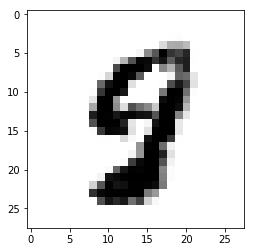

('Estimate:', array([[ 4.16786242]], dtype=float32))


('Iteration:', 90100, 'at', datetime.datetime(2018, 3, 12, 13, 39, 4, 890439))


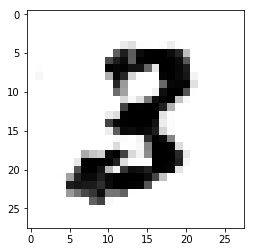

('Estimate:', array([[ 15.67671871]], dtype=float32))


('Iteration:', 90200, 'at', datetime.datetime(2018, 3, 12, 13, 39, 9, 439716))


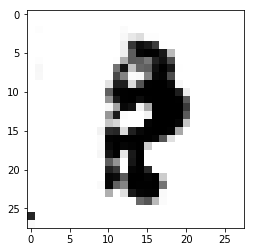

('Estimate:', array([[ 11.9699192]], dtype=float32))


('Iteration:', 90300, 'at', datetime.datetime(2018, 3, 12, 13, 39, 14, 40510))


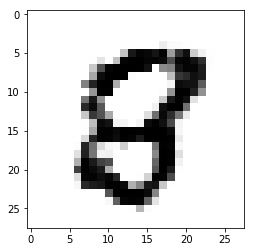

('Estimate:', array([[ 53.580513]], dtype=float32))


('Iteration:', 90400, 'at', datetime.datetime(2018, 3, 12, 13, 39, 18, 652141))


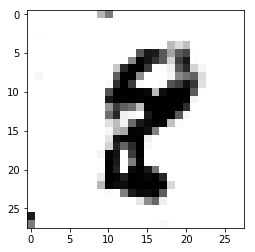

('Estimate:', array([[ 9.69376278]], dtype=float32))


('Iteration:', 90500, 'at', datetime.datetime(2018, 3, 12, 13, 39, 23, 177832))


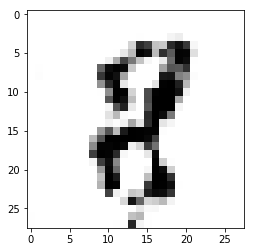

('Estimate:', array([[ 2.88745904]], dtype=float32))


('Iteration:', 90600, 'at', datetime.datetime(2018, 3, 12, 13, 39, 27, 727803))


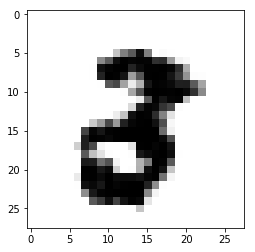

('Estimate:', array([[-0.18362926]], dtype=float32))


('Iteration:', 90700, 'at', datetime.datetime(2018, 3, 12, 13, 39, 32, 259388))


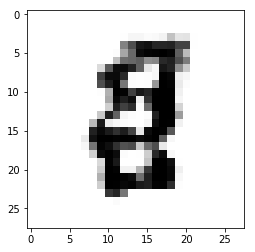

('Estimate:', array([[ 8.03156567]], dtype=float32))


('Iteration:', 90800, 'at', datetime.datetime(2018, 3, 12, 13, 39, 36, 827609))


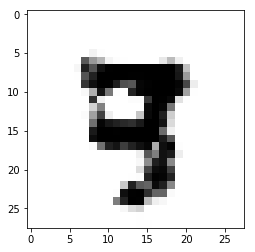

('Estimate:', array([[-14.66008759]], dtype=float32))


('Iteration:', 90900, 'at', datetime.datetime(2018, 3, 12, 13, 39, 41, 473792))


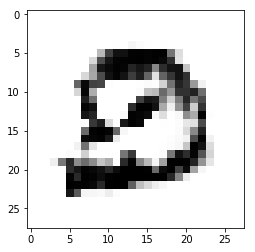

('Estimate:', array([[ 10.06226254]], dtype=float32))


('Iteration:', 91000, 'at', datetime.datetime(2018, 3, 12, 13, 39, 46, 163656))


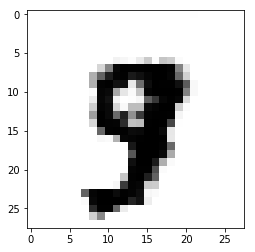

('Estimate:', array([[-7.67974377]], dtype=float32))


('Iteration:', 91100, 'at', datetime.datetime(2018, 3, 12, 13, 39, 50, 742669))


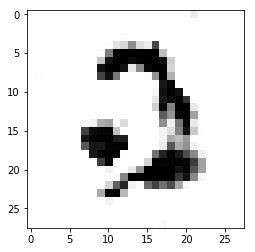

('Estimate:', array([[ 42.01473618]], dtype=float32))


('Iteration:', 91200, 'at', datetime.datetime(2018, 3, 12, 13, 39, 55, 298511))


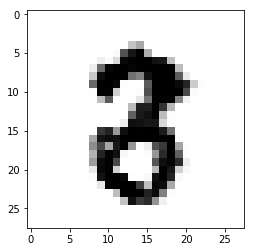

('Estimate:', array([[-17.16283035]], dtype=float32))


('Iteration:', 91300, 'at', datetime.datetime(2018, 3, 12, 13, 39, 59, 851385))


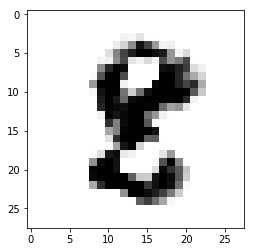

('Estimate:', array([[-11.63010979]], dtype=float32))


('Iteration:', 91400, 'at', datetime.datetime(2018, 3, 12, 13, 40, 4, 399727))


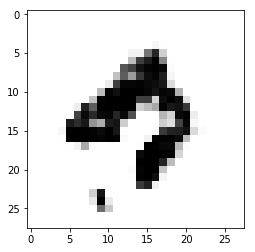

('Estimate:', array([[ 12.341012]], dtype=float32))


('Iteration:', 91500, 'at', datetime.datetime(2018, 3, 12, 13, 40, 8, 996063))


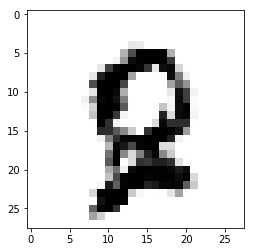

('Estimate:', array([[ 14.8656702]], dtype=float32))


('Iteration:', 91600, 'at', datetime.datetime(2018, 3, 12, 13, 40, 13, 600796))


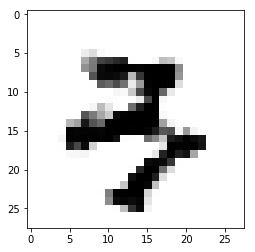

('Estimate:', array([[-16.80236816]], dtype=float32))


('Iteration:', 91700, 'at', datetime.datetime(2018, 3, 12, 13, 40, 18, 237689))


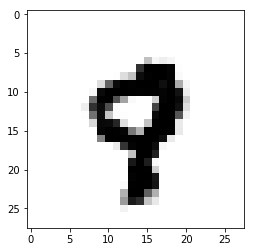

('Estimate:', array([[ 25.12111092]], dtype=float32))


('Iteration:', 91800, 'at', datetime.datetime(2018, 3, 12, 13, 40, 22, 821380))


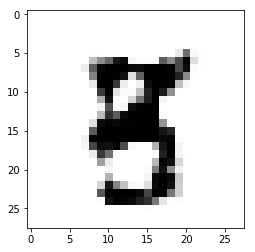

('Estimate:', array([[ 1.62070537]], dtype=float32))


('Iteration:', 91900, 'at', datetime.datetime(2018, 3, 12, 13, 40, 27, 453495))


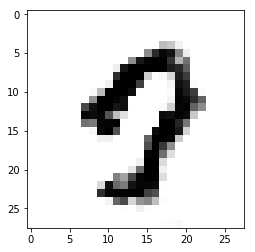

('Estimate:', array([[-1.7881012]], dtype=float32))


('Iteration:', 92000, 'at', datetime.datetime(2018, 3, 12, 13, 40, 32, 162719))


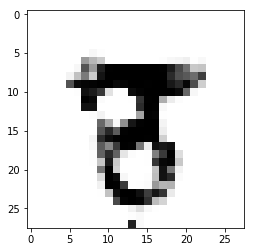

('Estimate:', array([[-4.76774836]], dtype=float32))


('Iteration:', 92100, 'at', datetime.datetime(2018, 3, 12, 13, 40, 36, 859967))


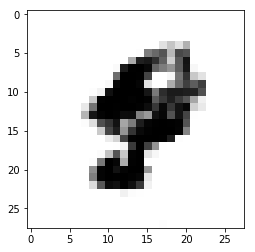

('Estimate:', array([[-8.56069279]], dtype=float32))


('Iteration:', 92200, 'at', datetime.datetime(2018, 3, 12, 13, 40, 41, 536340))


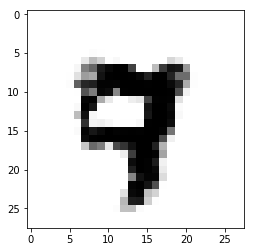

('Estimate:', array([[-10.99046803]], dtype=float32))


('Iteration:', 92300, 'at', datetime.datetime(2018, 3, 12, 13, 40, 46, 161523))


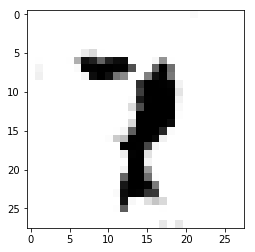

('Estimate:', array([[-7.66591597]], dtype=float32))


('Iteration:', 92400, 'at', datetime.datetime(2018, 3, 12, 13, 40, 50, 730033))


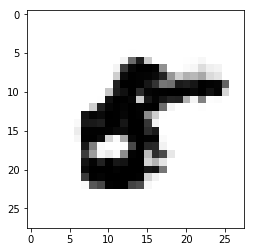

('Estimate:', array([[ 34.696064]], dtype=float32))


('Iteration:', 92500, 'at', datetime.datetime(2018, 3, 12, 13, 40, 55, 443333))


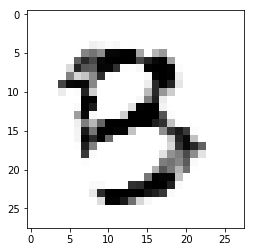

('Estimate:', array([[ 14.03968143]], dtype=float32))


('Iteration:', 92600, 'at', datetime.datetime(2018, 3, 12, 13, 41, 0, 51423))


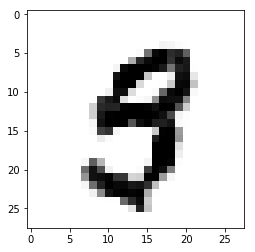

('Estimate:', array([[ 16.97899055]], dtype=float32))


('Iteration:', 92700, 'at', datetime.datetime(2018, 3, 12, 13, 41, 4, 615972))


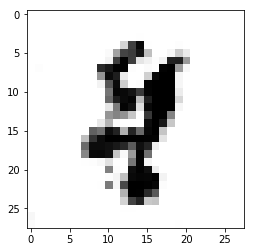

('Estimate:', array([[-7.75079107]], dtype=float32))


('Iteration:', 92800, 'at', datetime.datetime(2018, 3, 12, 13, 41, 9, 166204))


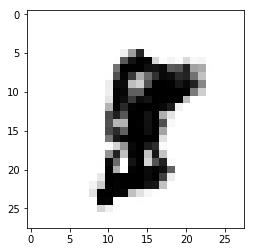

('Estimate:', array([[ 2.89710498]], dtype=float32))


('Iteration:', 92900, 'at', datetime.datetime(2018, 3, 12, 13, 41, 13, 688624))


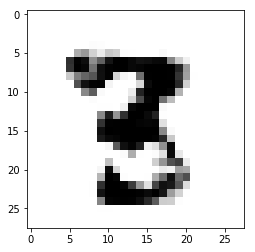

('Estimate:', array([[ 4.52880764]], dtype=float32))


('Iteration:', 93000, 'at', datetime.datetime(2018, 3, 12, 13, 41, 18, 189225))


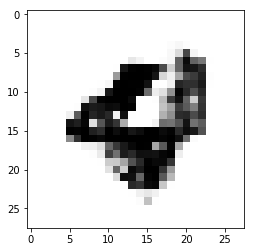

('Estimate:', array([[ 23.16139221]], dtype=float32))


('Iteration:', 93100, 'at', datetime.datetime(2018, 3, 12, 13, 41, 22, 695890))


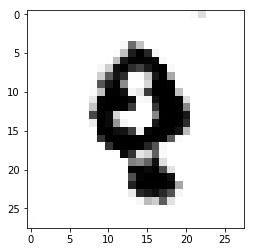

('Estimate:', array([[ 7.44282961]], dtype=float32))


('Iteration:', 93200, 'at', datetime.datetime(2018, 3, 12, 13, 41, 27, 280632))


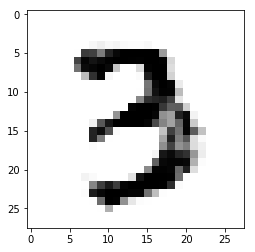

('Estimate:', array([[ 26.64581871]], dtype=float32))


('Iteration:', 93300, 'at', datetime.datetime(2018, 3, 12, 13, 41, 31, 821493))


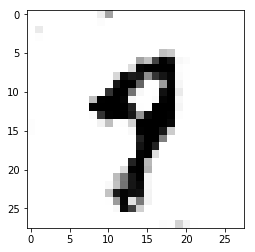

('Estimate:', array([[-9.19846249]], dtype=float32))


('Iteration:', 93400, 'at', datetime.datetime(2018, 3, 12, 13, 41, 36, 382667))


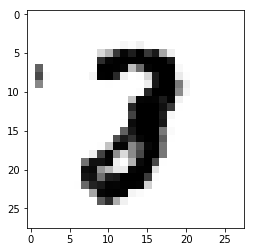

('Estimate:', array([[ 6.95509863]], dtype=float32))


('Iteration:', 93500, 'at', datetime.datetime(2018, 3, 12, 13, 41, 40, 923095))


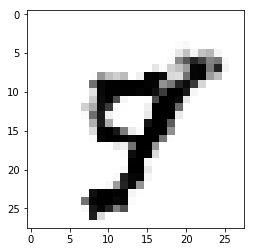

('Estimate:', array([[ 1.31524527]], dtype=float32))


('Iteration:', 93600, 'at', datetime.datetime(2018, 3, 12, 13, 41, 45, 544658))


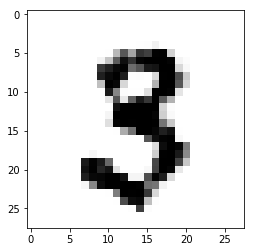

('Estimate:', array([[-9.08695126]], dtype=float32))


('Iteration:', 93700, 'at', datetime.datetime(2018, 3, 12, 13, 41, 50, 148647))


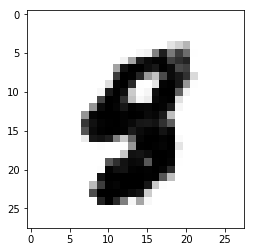

('Estimate:', array([[-9.0126543]], dtype=float32))


('Iteration:', 93800, 'at', datetime.datetime(2018, 3, 12, 13, 41, 54, 732451))


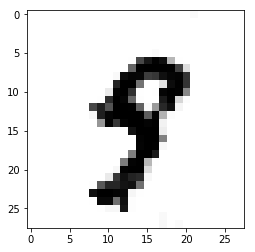

('Estimate:', array([[ 21.91830826]], dtype=float32))


('Iteration:', 93900, 'at', datetime.datetime(2018, 3, 12, 13, 41, 59, 434428))


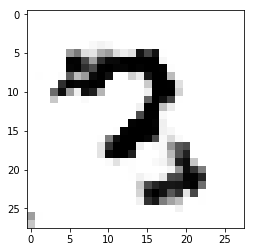

('Estimate:', array([[ 31.00268745]], dtype=float32))


('Iteration:', 94000, 'at', datetime.datetime(2018, 3, 12, 13, 42, 4, 95657))


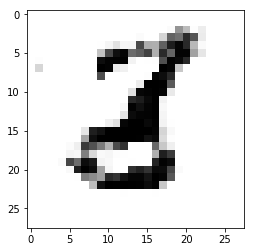

('Estimate:', array([[ 11.08478069]], dtype=float32))


('Iteration:', 94100, 'at', datetime.datetime(2018, 3, 12, 13, 42, 8, 721063))


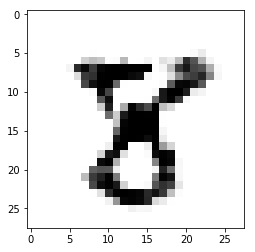

('Estimate:', array([[ 0.44300097]], dtype=float32))


('Iteration:', 94200, 'at', datetime.datetime(2018, 3, 12, 13, 42, 13, 461367))


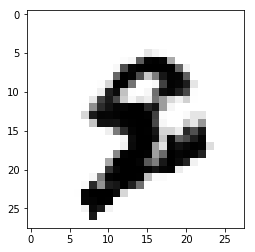

('Estimate:', array([[ 22.73582649]], dtype=float32))


('Iteration:', 94300, 'at', datetime.datetime(2018, 3, 12, 13, 42, 18, 194668))


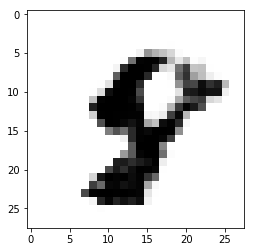

('Estimate:', array([[ 7.56258726]], dtype=float32))


('Iteration:', 94400, 'at', datetime.datetime(2018, 3, 12, 13, 42, 22, 797962))


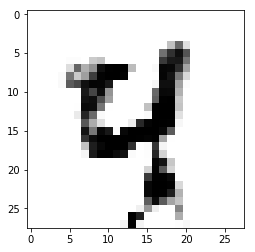

('Estimate:', array([[ 34.31679916]], dtype=float32))


('Iteration:', 94500, 'at', datetime.datetime(2018, 3, 12, 13, 42, 27, 457007))


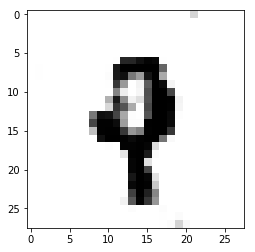

('Estimate:', array([[ 3.65903759]], dtype=float32))


('Iteration:', 94600, 'at', datetime.datetime(2018, 3, 12, 13, 42, 31, 966926))


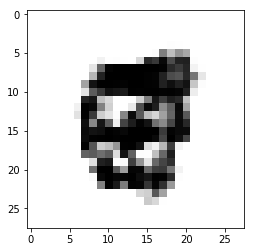

('Estimate:', array([[-13.48831272]], dtype=float32))


('Iteration:', 94700, 'at', datetime.datetime(2018, 3, 12, 13, 42, 36, 557678))


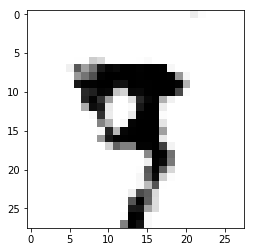

('Estimate:', array([[ 16.30347443]], dtype=float32))


('Iteration:', 94800, 'at', datetime.datetime(2018, 3, 12, 13, 42, 41, 204885))


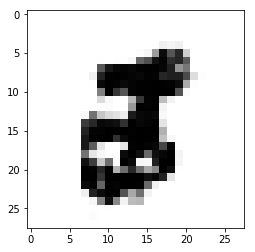

('Estimate:', array([[ 11.07705307]], dtype=float32))


('Iteration:', 94900, 'at', datetime.datetime(2018, 3, 12, 13, 42, 45, 752040))


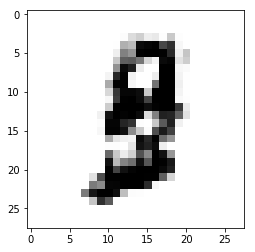

('Estimate:', array([[-12.80660057]], dtype=float32))


('Iteration:', 95000, 'at', datetime.datetime(2018, 3, 12, 13, 42, 50, 267559))


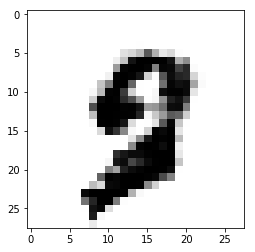

('Estimate:', array([[-6.21144581]], dtype=float32))


('Iteration:', 95100, 'at', datetime.datetime(2018, 3, 12, 13, 42, 54, 807545))


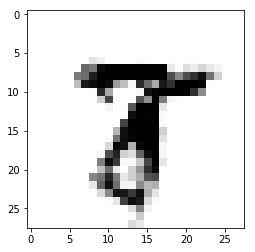

('Estimate:', array([[-1.25348866]], dtype=float32))


('Iteration:', 95200, 'at', datetime.datetime(2018, 3, 12, 13, 42, 59, 380395))


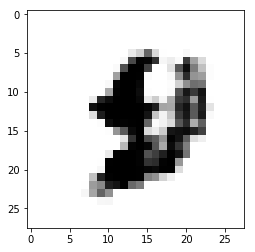

('Estimate:', array([[ 14.2769146]], dtype=float32))


('Iteration:', 95300, 'at', datetime.datetime(2018, 3, 12, 13, 43, 3, 966365))


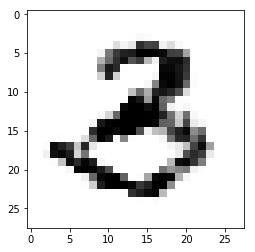

('Estimate:', array([[ 12.39153385]], dtype=float32))


('Iteration:', 95400, 'at', datetime.datetime(2018, 3, 12, 13, 43, 8, 605656))


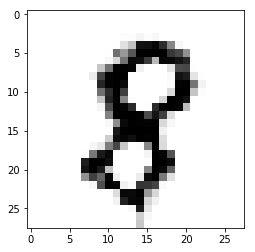

('Estimate:', array([[ 39.88850021]], dtype=float32))


('Iteration:', 95500, 'at', datetime.datetime(2018, 3, 12, 13, 43, 13, 175818))


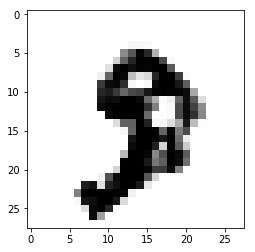

('Estimate:', array([[ 7.13650751]], dtype=float32))


('Iteration:', 95600, 'at', datetime.datetime(2018, 3, 12, 13, 43, 17, 873023))


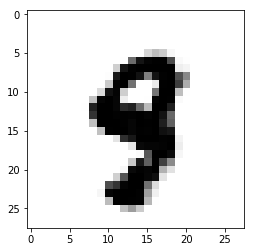

('Estimate:', array([[ 1.68634856]], dtype=float32))


('Iteration:', 95700, 'at', datetime.datetime(2018, 3, 12, 13, 43, 22, 589135))


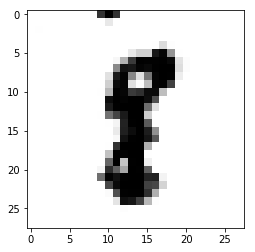

('Estimate:', array([[ 3.68664551]], dtype=float32))


('Iteration:', 95800, 'at', datetime.datetime(2018, 3, 12, 13, 43, 27, 168282))


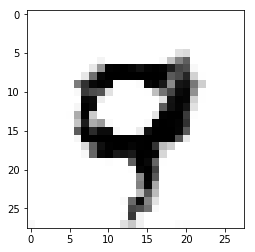

('Estimate:', array([[ 50.0384903]], dtype=float32))


('Iteration:', 95900, 'at', datetime.datetime(2018, 3, 12, 13, 43, 31, 790679))


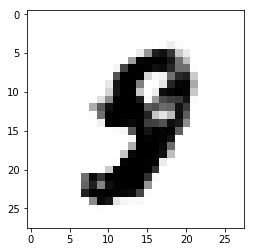

('Estimate:', array([[-7.84017515]], dtype=float32))


('Iteration:', 96000, 'at', datetime.datetime(2018, 3, 12, 13, 43, 36, 377998))


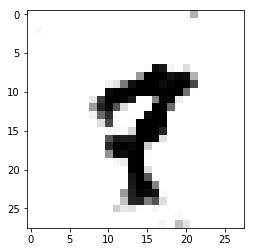

('Estimate:', array([[-9.93385792]], dtype=float32))


('Iteration:', 96100, 'at', datetime.datetime(2018, 3, 12, 13, 43, 41, 52949))


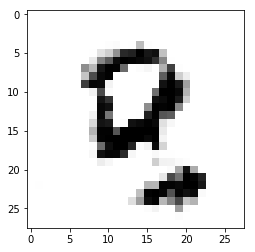

('Estimate:', array([[ 32.42954636]], dtype=float32))


('Iteration:', 96200, 'at', datetime.datetime(2018, 3, 12, 13, 43, 45, 705192))


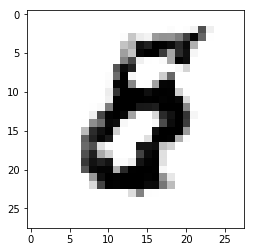

('Estimate:', array([[ 17.83378029]], dtype=float32))


('Iteration:', 96300, 'at', datetime.datetime(2018, 3, 12, 13, 43, 50, 371273))


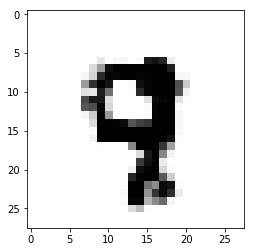

('Estimate:', array([[-0.15813227]], dtype=float32))


('Iteration:', 96400, 'at', datetime.datetime(2018, 3, 12, 13, 43, 55, 63177))


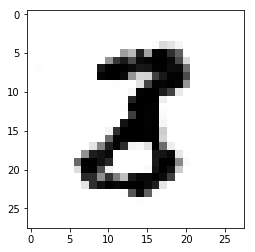

('Estimate:', array([[ 18.35565948]], dtype=float32))


('Iteration:', 96500, 'at', datetime.datetime(2018, 3, 12, 13, 43, 59, 832445))


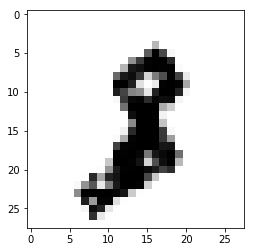

('Estimate:', array([[ 1.07928097]], dtype=float32))


('Iteration:', 96600, 'at', datetime.datetime(2018, 3, 12, 13, 44, 4, 548516))


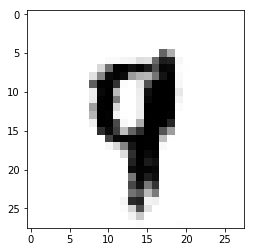

('Estimate:', array([[ 2.70635462]], dtype=float32))


('Iteration:', 96700, 'at', datetime.datetime(2018, 3, 12, 13, 44, 9, 255374))


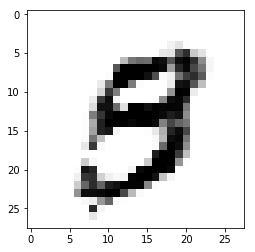

('Estimate:', array([[ 8.67433167]], dtype=float32))


('Iteration:', 96800, 'at', datetime.datetime(2018, 3, 12, 13, 44, 13, 828669))


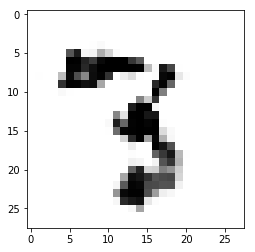

('Estimate:', array([[ 2.42255616]], dtype=float32))


('Iteration:', 96900, 'at', datetime.datetime(2018, 3, 12, 13, 44, 18, 492261))


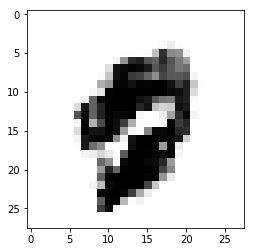

('Estimate:', array([[-15.76539803]], dtype=float32))


('Iteration:', 97000, 'at', datetime.datetime(2018, 3, 12, 13, 44, 23, 114431))


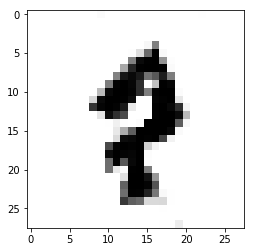

('Estimate:', array([[-14.5743103]], dtype=float32))


('Iteration:', 97100, 'at', datetime.datetime(2018, 3, 12, 13, 44, 27, 785492))


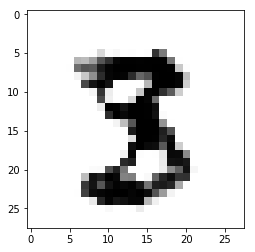

('Estimate:', array([[ 5.89634895]], dtype=float32))


('Iteration:', 97200, 'at', datetime.datetime(2018, 3, 12, 13, 44, 32, 444413))


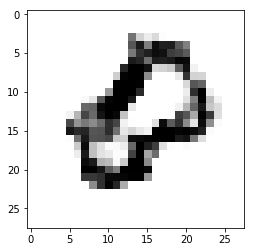

('Estimate:', array([[ 26.41358757]], dtype=float32))


('Iteration:', 97300, 'at', datetime.datetime(2018, 3, 12, 13, 44, 37, 52949))


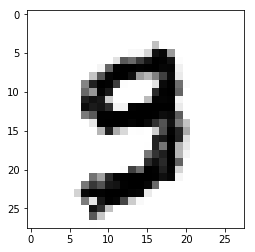

('Estimate:', array([[-22.64330864]], dtype=float32))


('Iteration:', 97400, 'at', datetime.datetime(2018, 3, 12, 13, 44, 41, 732755))


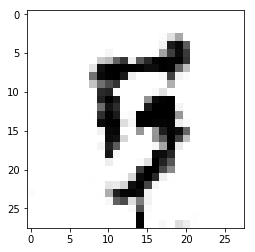

('Estimate:', array([[-48.90795135]], dtype=float32))


('Iteration:', 97500, 'at', datetime.datetime(2018, 3, 12, 13, 44, 46, 514420))


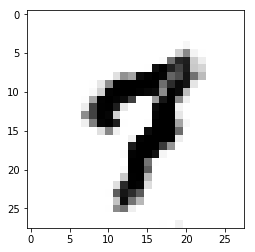

('Estimate:', array([[ 7.52998495]], dtype=float32))


('Iteration:', 97600, 'at', datetime.datetime(2018, 3, 12, 13, 44, 51, 306183))


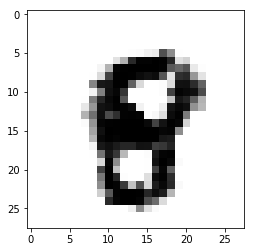

('Estimate:', array([[-8.79382324]], dtype=float32))


('Iteration:', 97700, 'at', datetime.datetime(2018, 3, 12, 13, 44, 55, 950423))


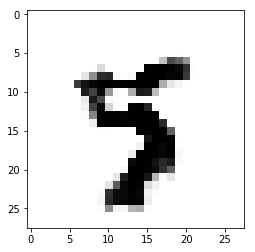

('Estimate:', array([[ 13.84974194]], dtype=float32))


('Iteration:', 97800, 'at', datetime.datetime(2018, 3, 12, 13, 45, 0, 809424))


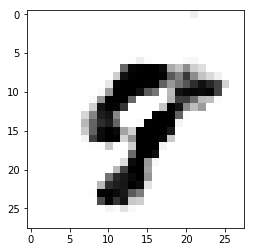

('Estimate:', array([[-10.12878895]], dtype=float32))


('Iteration:', 97900, 'at', datetime.datetime(2018, 3, 12, 13, 45, 5, 439524))


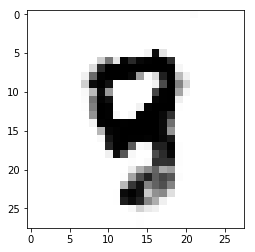

('Estimate:', array([[ 4.05226278]], dtype=float32))


('Iteration:', 98000, 'at', datetime.datetime(2018, 3, 12, 13, 45, 10, 239563))


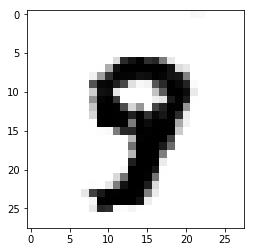

('Estimate:', array([[-17.19569969]], dtype=float32))


('Iteration:', 98100, 'at', datetime.datetime(2018, 3, 12, 13, 45, 15, 41216))


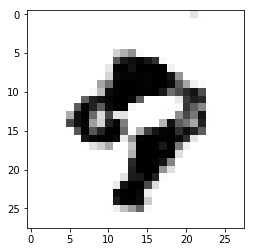

('Estimate:', array([[ 17.77781868]], dtype=float32))


('Iteration:', 98200, 'at', datetime.datetime(2018, 3, 12, 13, 45, 19, 744175))


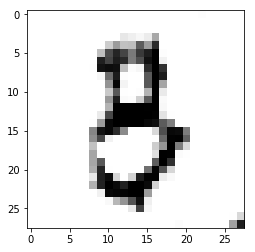

('Estimate:', array([[-7.24846458]], dtype=float32))


('Iteration:', 98300, 'at', datetime.datetime(2018, 3, 12, 13, 45, 24, 430495))


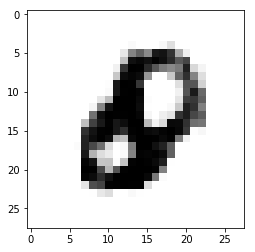

('Estimate:', array([[ 9.12236691]], dtype=float32))


('Iteration:', 98400, 'at', datetime.datetime(2018, 3, 12, 13, 45, 29, 60800))


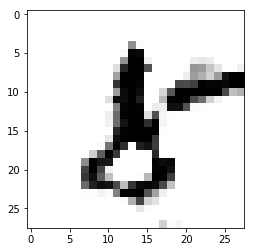

('Estimate:', array([[ 47.85084152]], dtype=float32))


('Iteration:', 98500, 'at', datetime.datetime(2018, 3, 12, 13, 45, 33, 814480))


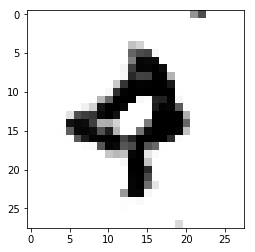

('Estimate:', array([[ 15.89655685]], dtype=float32))


('Iteration:', 98600, 'at', datetime.datetime(2018, 3, 12, 13, 45, 38, 598219))


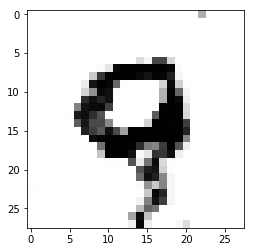

('Estimate:', array([[ 28.31447029]], dtype=float32))


('Iteration:', 98700, 'at', datetime.datetime(2018, 3, 12, 13, 45, 43, 379240))


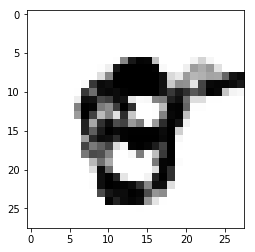

('Estimate:', array([[ 38.17156219]], dtype=float32))


('Iteration:', 98800, 'at', datetime.datetime(2018, 3, 12, 13, 45, 48, 188921))


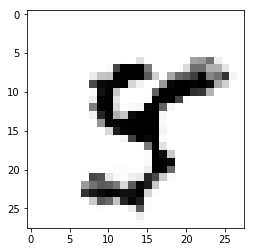

('Estimate:', array([[-3.51180911]], dtype=float32))


('Iteration:', 98900, 'at', datetime.datetime(2018, 3, 12, 13, 45, 52, 958005))


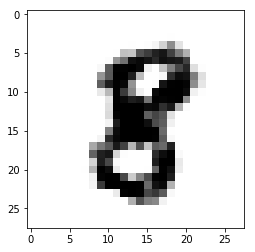

('Estimate:', array([[ 3.78692865]], dtype=float32))


('Iteration:', 99000, 'at', datetime.datetime(2018, 3, 12, 13, 45, 57, 870846))


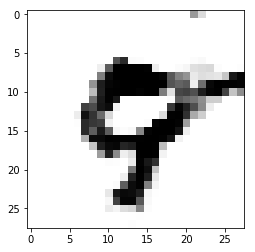

('Estimate:', array([[ 21.742136]], dtype=float32))


('Iteration:', 99100, 'at', datetime.datetime(2018, 3, 12, 13, 46, 2, 584093))


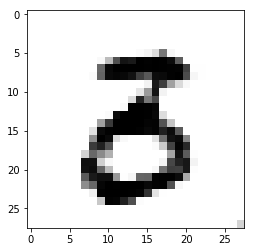

('Estimate:', array([[ 4.69350433]], dtype=float32))


('Iteration:', 99200, 'at', datetime.datetime(2018, 3, 12, 13, 46, 7, 345498))


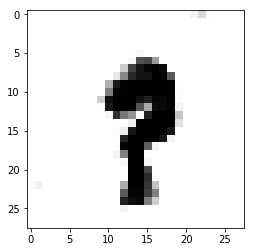

('Estimate:', array([[ 22.51896858]], dtype=float32))


('Iteration:', 99300, 'at', datetime.datetime(2018, 3, 12, 13, 46, 12, 86842))


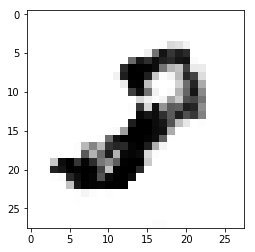

('Estimate:', array([[ 15.06864262]], dtype=float32))


('Iteration:', 99400, 'at', datetime.datetime(2018, 3, 12, 13, 46, 16, 795585))


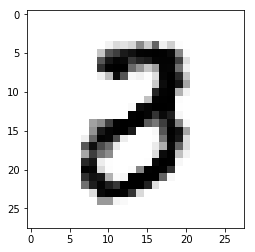

('Estimate:', array([[ 10.80309963]], dtype=float32))


('Iteration:', 99500, 'at', datetime.datetime(2018, 3, 12, 13, 46, 22, 984924))


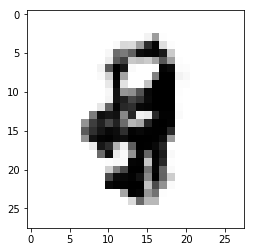

('Estimate:', array([[ 16.29924583]], dtype=float32))


('Iteration:', 99600, 'at', datetime.datetime(2018, 3, 12, 13, 46, 27, 955826))


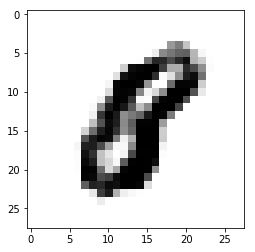

('Estimate:', array([[-2.66000223]], dtype=float32))


('Iteration:', 99700, 'at', datetime.datetime(2018, 3, 12, 13, 46, 32, 814311))


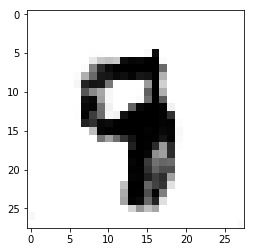

('Estimate:', array([[ 23.53812218]], dtype=float32))


('Iteration:', 99800, 'at', datetime.datetime(2018, 3, 12, 13, 46, 37, 785297))


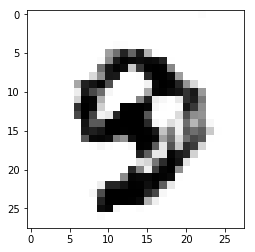

('Estimate:', array([[ 23.06195068]], dtype=float32))


('Iteration:', 99900, 'at', datetime.datetime(2018, 3, 12, 13, 46, 42, 624110))


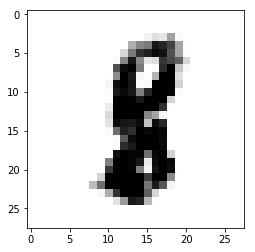

('Estimate:', array([[-1.30717087]], dtype=float32))


In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

Because it can take so long to train a GAN, we recommend that you skip the cell above and execute the following cell. It loads a model that we've already trained for several hours on a fast GPU machine, and lets you experiment with the output of a trained GAN.

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()

## Training difficulties

GANs are notoriously difficult to train. Without the right hyperparameters, network architecture, and training procedure, the discriminator can overpower the generator, or vice-versa.

In one common failure mode, the discriminator overpowers the generator, classifying generated images as fake with absolute certainty. When the discriminator responds with absolute certainty, it leaves no gradient for the generator to descend. This is partly why we built our discriminator to produce unscaled output rather than passing its output through a sigmoid function that would push its evaluation toward either 0 or 1.

In another common failure mode known as **mode collapse**, the generator discovers and exploits some weakness in the discriminator. You can recognize mode collapse in your GAN if it generates many very similar images regardless of variation in the generator input _z_. Mode collapse can sometimes be corrected by "strengthening" the discriminator in some way—for instance, by adjusting its training rate or by reconfiguring its layers.

Researchers have identified a handful of ["GAN hacks"](https://github.com/soumith/ganhacks) that can be helpful in building stable GANs.

## Closing thoughts

GANs have tremendous potential to reshape the digital world that we interact with every day. The field is still very young, and the next great GAN discovery could be yours!

## Other resources

- [The original GAN paper](https://arxiv.org/abs/1406.2661) by Ian Goodfellow and his collaborators, published in 2014
- [A more recent tutorial by Goodfellow](https://arxiv.org/abs/1701.00160) that explains GANs in somewhat more accessible terms
- [A paper by Alec Radford, Luke Metz, and Soumith Chintala](https://arxiv.org/abs/1511.06434) that introduces deep convolutional GANs, whose basic structure we use in our generator in this tutorial. Also see [their DCGAN code on GitHub](https://github.com/Newmu/dcgan_code).
- [A reference collection of generative networks by Agustinus Kristiadi](https://github.com/wiseodd/generative-models), implemented in TensorFlow